## Imports

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt

## Divisão dos dados em X e Y

Label Encoder do y & Normalização do X

In [3]:
dataset_path = 'feature_extraction.csv' 
data = pd.read_csv(dataset_path)

X = data.drop(columns=['file_id', 'class', 'fold']) 
y = data['class'] 

#One Hot Encoder de y
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

#Normalização de X
scaler = MinMaxScaler() 
X = scaler.fit_transform(X)

print(pd.DataFrame(X).head())
print(np.unique(y))

         0         1         2         3         4         5         6   \
0  0.683183  0.017093  0.621973  0.469777  0.383277  0.638431  0.505458   
1  0.718800  0.105597  0.460109  0.637143  0.377176  0.563590  0.472180   
2  0.728638  0.092748  0.416206  0.685898  0.283718  0.519607  0.469577   
3  0.478898  0.036833  0.516766  0.653926  0.260736  0.470929  0.489646   
4  0.496398  0.700244  0.422515  0.824047  0.313228  0.513074  0.495865   

         7         8         9   ...        13        14        15        16  \
0  0.035471  0.092136  0.036746  ...  0.077481  0.165125  0.026641  0.279333   
1  0.138060  0.186574  0.273884  ...  0.395330  0.385121  0.297618  0.668237   
2  0.104300  0.098335  0.046947  ...  0.325160  0.241995  0.111223  0.464770   
3  0.139243  0.087479  0.104135  ...  0.125955  0.218403  0.084630  0.418222   
4  0.135814  0.168407  0.233478  ...  0.402947  0.331131  0.254352  0.459972   

         17        18        19        20        21   22  
0  0.0266

## PCA

Aplicação do PCA ao dataset extraído para evitar variáveis correlacionadas (e consequentemente overfitting). O número de componentes foi escolhido através do gráfico de variância acumulada à medida que se adicionam componentes ao PCA (10 componentes que explicam cerca de 90% da variância do dataset)

In [4]:
pca = PCA(n_components=10) 
new_X = pca.fit_transform(X)

## Número de camadas escondidas

Duas camadas escondidas já são capazes de representar qualquer relação entre os dados, mesmo aquelas que não podem ser representadas por equações. Mais do que duas camadas escondidas só são necessárias em problemas ainda mais complexos como séries temporais e visão computacional, onde há uma certa inter-relação entre as dimensões que os dados contêm

In [5]:
n_camadas = [2, 3]
print ("Range do nº de camadas: ", n_camadas)

Range do nº de camadas:  [2, 3]


## Número de neurónios em cada camada escondida

Abordagens:  
O número de neurônios escondidos deve estar entre o tamanho da camada de entrada e o da camada de saída.  
O número de neurônios escondidos deve ser 2/3 do tamanho da camada de entrada, mais o tamanho da camada de saída

In [6]:
def n_neuronios(X):
    n_neur = [0] * 3
    input_dim = X.shape[1]
    output_dim = len(label_encoder.classes_)
    #Neurónios na camada escondida 1
    n_neur [0] = int((input_dim + output_dim)/2)
    #Neurónios na camada escondida 2
    n_neur [1] = int((input_dim + output_dim)/3)
    #Neurónios na camada escondida 3
    n_neur [2] = int((input_dim + output_dim)/4)
    return n_neur, output_dim

## Inicialização dos pesos

Função gaussiana para inicializar os pesos

In [7]:
def initialize_weights(shape, dtype=None):
    mean = 0.0
    stddev = 0.01
    return tf.constant(np.random.normal(loc=mean, scale=stddev, size=shape), dtype=dtype)

## Ajuste do Learning Rate ao longo da aprendizagem

Ajustar o Learning Rate para metade do seu valor de 10 em 10 epochs

In [8]:
def scheduler(epoch, lr): 
    lr_scheduler = LearningRateScheduler(scheduler)
    if epoch > 0 and epoch % 10 == 0: 
        return lr / 2 
    return lr

## Early Stop

Verificar se a validation loss (no fold de desenvolvimento) não melhora em 10 epochs consecutivos, e para o treino caso isso aconteça

In [9]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

## Grid Search

Função que faz um grid search para encontrar o melhor learning rate para o otimizador Adam e o melhor número de epochs e batch size para o modelo. Os valores em cada grid foram pedidos ao ChatGPT. A cada modelo é aplicada uma 10-cross validation, com 8 folds a serem usados para treino, 1 para teste e 1 para desenvolvimento

In [10]:
def grid_search(model, X):
    learning_rate = [0.1, 0.01, 0.001]
    epochs = [50, 100, 200]
    batch_size = [16, 32, 64, 128]
    best_model = None
    best_model_accuracy = 0
    for i in learning_rate:
        for j in epochs:
            for m in batch_size:
                adam_optimizer = tf.keras.optimizers.Adam(learning_rate=i)
                # Definir o modelo
                model = model
            
                kf = KFold(n_splits=10, shuffle=True, random_state=42)
                folds = list(kf.split(X))
                all_accuracies = []
                all_confusion_matrices = []
                all_losses = []
                for fold_idx in range(len(folds)):
                    train_val_indices, test_indices = folds[fold_idx]

                    dev_fold_idx = (fold_idx + 1) % len(folds)
                    train_indices, dev_indices = folds[dev_fold_idx]

                    X_train, y_train = X[train_val_indices], y[train_val_indices]
                    X_dev, y_dev = X[dev_indices], y[dev_indices]

                    X_test, y_test = X[test_indices], y[test_indices]

                    model.compile(optimizer=adam_optimizer, loss='sparse_categorical_crossentropy', metrics=["accuracy"])

                    model.fit(X_train, y_train, epochs=j, batch_size=m, validation_data=(X_dev, y_dev), callbacks=[lr_scheduler, early_stopping])

                    loss, accuracy = model.evaluate(X_test, y_test)

                    all_accuracies.append(accuracy) 
                    y_pred = model.predict(X_test) 
                    y_pred_classes = np.argmax(y_pred, axis=1) 
                    cm = confusion_matrix(y_test, y_pred_classes) 
                    all_confusion_matrices.append(cm)
                    all_losses.append(loss)

                accumulated_cm = np.sum(all_confusion_matrices, axis=0) 
                accumulated_cm_percentage = accumulated_cm / np.sum(accumulated_cm) * 100
                mean_accuracy = np.mean(all_accuracies) 
                std_accuracy = np.std(all_accuracies)
                mean_loss = np.mean(all_losses)
                
                if best_model == None or mean_accuracy > best_model_accuracy:
                    best_model = model
                    best_model_accuracy = mean_accuracy
                    best_model_cfm = accumulated_cm_percentage
                    best_model_loss = mean_loss
                    best_model_std = std_accuracy
                    best_model_lr = i
                    best_model_epochs = j
                    best_model_batch_size = m
    return best_model, best_model_accuracy, best_model_cfm, best_model_loss, best_model_std, best_model_lr, best_model_epochs, best_model_batch_size

## Escolha de funções de ativação

Para as camadas escondidas testámos modelos com funções de ativação ReLU e funções de ativação LeakyReLU  
"The ReLU function is the default activation function for hidden layers in modern MLP and CNN neural network models"  
"(The LeakyReLU function) does not have any linear component with zero derivatives (slopes). Therefore, it can avoid the dying ReLU problem"  
"The same usage of the ReLU function is also valid for the leaky ReLU function"  

Para as camadas de output usámos sempre a função de ativação softmax  
"We must use the softmax function in the output layer of a multiclass classification problem"

In [11]:
models = []

## MLP com 2 camadas escondidas e funções de ativação ReLU

In [12]:
def model1(X, n_neur, output_dim):    
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Input(shape=(X.shape[1],)), 
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'), 
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'), 
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights) 
        ])
    return model
models.append(model1)

## MLP com 2 camadas escondidas e funções de ativação LeakyReLU

In [13]:
def model2(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model2)

## MLP com 3 camadas escondidas e funções de ativação ReLU

In [14]:
def model3(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([ 
        tf.keras.layers.Input(shape=(X.shape[1],)), 
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights, activation='relu'), 
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights, activation='relu'),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights) 
    ])
    return model
models.append(model3)

## MLP com 3 camadas escondidas e funções de ativação LeakyReLU

In [15]:
def model4(X, n_neur, output_dim):
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(X.shape[1],)),
        tf.keras.layers.Dense(n_neur[0], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[1], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(n_neur[2], kernel_initializer=initialize_weights),
        tf.keras.layers.LeakyReLU(negative_slope=0.01),
        tf.keras.layers.Dense(output_dim, activation='softmax', kernel_initializer=initialize_weights)
    ])
    return model
models.append(model4)

## Encontrar o melhor modelo MLP (dataset original)

In [17]:
best_model = None
best_model_accuracy = 0
for model_func in models:
    n_neur, output_dim = n_neuronios(X)
    model = model_func(X, n_neur, output_dim)
    model, model_accuracy, model_cfm, model_loss, model_std, model_lr, model_epochs, model_batch_size = grid_search(model, X)
    if best_model == None or model_accuracy > best_model_accuracy:
        best_model = model
        best_model_accuracy = model_accuracy
        best_model_cfm = model_cfm
        best_model_loss = model_loss
        best_model_std = model_std
        best_model_lr = model_lr
        best_model_epochs = model_epochs
        best_model_batch_size = model_batch_size

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1887 - loss: 2.0610 - val_accuracy: 0.2712 - val_loss: 1.8145 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.2430 - loss: 1.8760 - val_accuracy: 0.2403 - val_loss: 1.8340 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.2526 - loss: 1.8668 - val_accuracy: 0.2666 - val_loss: 1.7987 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.2448 - loss: 1.8630 - val_accuracy: 0.2368 - val_loss: 1.8276 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.2559 - loss: 1.8379 - val_accuracy: 0.2735 - val_loss: 1.8133 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2403 - loss: 1.8701 - val_accuracy: 0.2551 - val_loss: 1.8042 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2455 - loss: 1

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - accuracy: 0.2286 - loss: 1.8375
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2499 - loss: 1.8607 - val_accuracy: 0.2669 - val_loss: 1.8277 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.2498 - loss: 1.8477 - val_accuracy: 0.2497 - val_loss: 1.8669 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.2627 - loss: 1.8526 - val_accuracy: 0.2738 - val_loss: 1.8199 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 785us/step - accuracy: 0.2563 - loss: 1.8658 - val_accuracy: 0.2211 - val_loss: 1.9963 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.2562 - loss: 1.8921 - val_accuracy: 0.2772 - val_loss: 1.8847 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.2566 - loss: 1.8583 - val_accuracy: 0.2635 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.2442 - loss: 1.9337
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2714 - loss: 1.8231 - val_accuracy: 0.2371 - val_loss: 1.8236 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.2736 - loss: 1.8110 - val_accuracy: 0.2658 - val_loss: 1.7976 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.2775 - loss: 1.8005 - val_accuracy: 0.2394 - val_loss: 1.7761 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.2747 - loss: 1.8088 - val_accuracy: 0.2726 - val_loss: 1.7464 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.2687 - loss: 1.8254 - val_accuracy: 0.2543 - val_loss: 1.9506 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.2629 - loss: 1.8692 - val_accuracy: 0.2635 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.2729 - loss: 1.8147
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2835 - loss: 1.8060 - val_accuracy: 0.2806 - val_loss: 1.7902 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.2561 - loss: 1.8507 - val_accuracy: 0.2795 - val_loss: 1.7796 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.2746 - loss: 1.8046 - val_accuracy: 0.2761 - val_loss: 1.7932 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.2631 - loss: 1.8092 - val_accuracy: 0.2784 - val_loss: 1.7931 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.2641 - loss: 1.8255 - val_accuracy: 0.2852 - val_loss: 1.7726 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.2622 - loss: 1.8246 - val_accuracy: 0.3081 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1975 - loss: 2.0246 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2616 - loss: 1.8228 - val_accuracy: 0.2975 - val_loss: 1.7783 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.2766 - loss: 1.7990 - val_accuracy: 0.2906 - val_loss: 1.7740 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2932 - loss: 1.7814 - val_accuracy: 0.2826 - val_loss: 1.7555 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2712 - loss: 1.8068 - val_accuracy: 0.2860 - val_loss: 1.7980 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2777 - loss: 1.8071 - val_accuracy: 0.2929 - val_loss: 1.7681 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2656 - loss: 1.8064 - val_accuracy: 0.3009 - val_loss: 1.7

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.2605 - loss: 1.7913
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2746 - loss: 1.8004 - val_accuracy: 0.2715 - val_loss: 1.8185 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2847 - loss: 1.7781 - val_accuracy: 0.2612 - val_loss: 1.8461 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.2666 - loss: 1.8121 - val_accuracy: 0.3093 - val_loss: 1.7959 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.2901 - loss: 1.7858 - val_accuracy: 0.2967 - val_loss: 1.8112 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2852 - loss: 1.7897 - val_accuracy: 0.2852 - val_loss: 1.8240 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.2760 - loss: 1.7843 - val_accuracy: 0.2772 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2173 - loss: 1.8679 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2621 - loss: 1.7974 - val_accuracy: 0.2680 - val_loss: 1.8255 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.2827 - loss: 1.8177 - val_accuracy: 0.2806 - val_loss: 1.8009 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2814 - loss: 1.7998 - val_accuracy: 0.2589 - val_loss: 1.7954 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.2907 - loss: 1.7967 - val_accuracy: 0.2486 - val_loss: 1.7995 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2830 - loss: 1.7913 - val_accuracy: 0.2841 - val_loss: 1.7995 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2923 - loss: 1.7883 - val_accuracy: 0.2829 - val_loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - accuracy: 0.2826 - loss: 1.8181
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2754 - loss: 1.7940 - val_accuracy: 0.2829 - val_loss: 1.7581 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2945 - loss: 1.7733 - val_accuracy: 0.2841 - val_loss: 1.7692 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.2826 - loss: 1.7685 - val_accuracy: 0.2910 - val_loss: 1.7772 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2867 - loss: 1.7755 - val_accuracy: 0.2726 - val_loss: 1.7621 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2898 - loss: 1.7762 - val_accuracy: 0.2852 - val_loss: 1.7595 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2924 - loss: 1.7854 - val_accuracy: 0.2990 - val_loss: 1.7716 - learn

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.2523 - loss: 1.8556 - val_accuracy: 0.2188 - val_loss: 1.8723 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.2005 - loss: 1.8685
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2558 - loss: 1.8396 - val_accuracy: 0.2417 - val_loss: 1.8939 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step - accuracy: 0.2561 - loss: 1.8649 - val_accuracy: 0.2806 - val_loss: 1.8366 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.2623 - loss: 1.8433 - val_accuracy: 0.2554 - val_loss: 1.8816 - learning_rate: 0.1000
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.2658 - loss: 1.8472 - val_accuracy: 0.2749 - val_loss: 1.8931 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.2529 - loss: 1.8548 - val_accuracy: 0.2566 - val_loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.2646 - loss: 1.8237 - val_accuracy: 0.2852 - val_loss: 1.7979 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2743 - loss: 1.8226 - val_accuracy: 0.2818 - val_loss: 1.8084 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2681 - loss: 1.8061 - val_accuracy: 0.2543 - val_loss: 1.7842 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2457 - loss: 1.8834 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2525 - loss: 1.8414 - val_accuracy: 0.2589 - val_loss: 1.7861 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2745 - loss: 1.8248 - val_accuracy: 0.2875 - val_loss: 1.7667 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.2795 - loss: 1.8029 - val_accuracy: 0.2589 - val_loss: 1.8026

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2606 - loss: 1.8349 - val_accuracy: 0.2680 - val_loss: 1.8328 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2662 - loss: 1.8375 - val_accuracy: 0.2829 - val_loss: 1.8249 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.2662 - loss: 1.8104 - val_accuracy: 0.3047 - val_loss: 1.8120 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.2712 - loss: 1.8186
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2675 - loss: 1.8223 - val_accuracy: 0.2612 - val_loss: 1.9399 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.2854 - loss: 1.8079 - val_accuracy: 0.2509 - val_loss: 1.8184 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.2795 - loss: 1.8033 - val_accuracy: 0.2761 - v

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2748 - loss: 1.8031 - val_accuracy: 0.2772 - val_loss: 1.7600 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2766 - loss: 1.7821 - val_accuracy: 0.2772 - val_loss: 1.7413 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.2771 - loss: 1.8120 - val_accuracy: 0.3150 - val_loss: 1.7618 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.2856 - loss: 1.7903 - val_accuracy: 0.2841 - val_loss: 1.7666 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.2515 - loss: 1.7822
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2737 - loss: 1.8351 - val_accuracy: 0.2669 - val_loss: 1.8308 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2705 - loss: 1.8304 - val_accuracy: 0.2852 - val_

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2775 - loss: 1.7990 - val_accuracy: 0.3001 - val_loss: 1.7954 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2749 - loss: 1.8033 - val_accuracy: 0.2898 - val_loss: 1.7789 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.2861 - loss: 1.7911 - val_accuracy: 0.2921 - val_loss: 1.7975 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2658 - loss: 1.8004 - val_accuracy: 0.2738 - val_loss: 1.7898 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.2585 - loss: 1.8106
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2962 - loss: 1.7778 - val_accuracy: 0.2944 - val_loss: 1.8210 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2928 - loss: 1.7715 - val_accuracy: 0.2875 - val_l

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2877 - loss: 1.7914 - val_accuracy: 0.2990 - val_loss: 1.7536 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2917 - loss: 1.7839 - val_accuracy: 0.2898 - val_loss: 1.7595 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2855 - loss: 1.7737 - val_accuracy: 0.2955 - val_loss: 1.7874 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2827 - loss: 1.7934 - val_accuracy: 0.2990 - val_loss: 1.7669 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.2582 - loss: 1.8464
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2871 - loss: 1.7863 - val_accuracy: 0.2772 - val_loss: 1.7567 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2942 - loss: 1.7721 - val_accuracy: 0.2726 - val_loss: 1.7402 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2752 - loss: 1.7887 - val_accuracy: 0.2689 - val_loss: 1.8422 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2905 - loss: 1.7838 - val_accuracy: 0.2529 - val_loss: 1.8520 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2947 - loss: 1.7660 - val_accuracy: 0.2838 - val_loss: 1.7868 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2936 - loss: 1.7724 - val_accuracy: 0.2746 - val_loss: 1.7761 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.2606 - loss: 1.8206
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2722 - loss: 1.8617 - val_accuracy: 0.2757 - val_loss: 1.8172 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.2580 - loss: 1.8845 - val_accuracy: 0.2391 - val_loss: 1.8712 - learni

Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.2540 - loss: 1.8428 - val_accuracy: 0.2875 - val_loss: 1.8632 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.2435 - loss: 1.8772 - val_accuracy: 0.2680 - val_loss: 1.8097 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.2697 - loss: 1.8491 - val_accuracy: 0.2337 - val_loss: 1.8596 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.2584 - loss: 1.8452 - val_accuracy: 0.2463 - val_loss: 1.9191 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.2431 - loss: 1.9376
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 966us/step - accuracy: 0.2619 - loss: 1.8733 - val_accuracy: 0.2394 - val_loss: 1.9209 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 867us/step - accuracy: 0.2751 - loss: 1.8264 - val_accuracy: 0.27

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2655 - loss: 1.8170 - val_accuracy: 0.2932 - val_loss: 1.8028 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.2850 - loss: 1.8029 - val_accuracy: 0.2726 - val_loss: 1.8130 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2747 - loss: 1.8129 - val_accuracy: 0.2841 - val_loss: 1.8137 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.2718 - loss: 1.8530 - val_accuracy: 0.2829 - val_loss: 1.7826 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.2760 - loss: 1.8061 - val_accuracy: 0.2715 - val_loss: 1.8002 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.2819 - loss: 1.8021 - val_accuracy: 0.3093 - val_loss: 1.7489 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.2717 - loss: 1.8354
28/28 ━━━━

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2672 - loss: 1.8381 - val_accuracy: 0.2654 - val_loss: 1.8174 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.2779 - loss: 1.7944 - val_accuracy: 0.2551 - val_loss: 1.8273 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2841 - loss: 1.8138 - val_accuracy: 0.2368 - val_loss: 1.8277 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2766 - loss: 1.8102 - val_accuracy: 0.2700 - val_loss: 1.7948 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2788 - loss: 1.8193 - val_accuracy: 0.2895 - val_loss: 1.7899 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.2658 - loss: 1.8308 - val_accuracy: 0.2506 - val_loss: 1.7984 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.2637 - loss: 1.8184 -

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2715 - loss: 1.8150 - val_accuracy: 0.2818 - val_loss: 1.7526 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2858 - loss: 1.8000 - val_accuracy: 0.2852 - val_loss: 1.7557 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2719 - loss: 1.8215 - val_accuracy: 0.2761 - val_loss: 1.7673 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2963 - loss: 1.7839 - val_accuracy: 0.2932 - val_loss: 1.7683 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.2749 - loss: 1.8074 - val_accuracy: 0.2738 - val_loss: 1.8306 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2786 - loss: 1.8033 - val_accuracy: 0.2497 - val_loss: 1.8192 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2801 - loss: 

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.2851 - loss: 1.7889 - val_accuracy: 0.2669 - val_loss: 1.8108 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.2783 - loss: 1.8334 - val_accuracy: 0.3058 - val_loss: 1.7669 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.2649 - loss: 1.8078 - val_accuracy: 0.2703 - val_loss: 1.7769 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.2784 - loss: 1.7948 - val_accuracy: 0.2978 - val_loss: 1.7914 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2869 - loss: 1.7983 - val_accuracy: 0.3036 - val_loss: 1.7662 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2806 - loss: 1.7902 - val_accuracy: 0.2543 - val_loss: 1.8368 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2675 - 

Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2882 - loss: 1.7755 - val_accuracy: 0.3070 - val_loss: 1.7531 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2805 - loss: 1.8024 - val_accuracy: 0.3036 - val_loss: 1.7796 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2820 - loss: 1.7860 - val_accuracy: 0.2944 - val_loss: 1.8097 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2889 - loss: 1.7883 - val_accuracy: 0.2784 - val_loss: 1.7738 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2738 - loss: 1.7977 - val_accuracy: 0.3162 - val_loss: 1.7502 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2789 - loss: 1.7837 - val_accuracy: 0.2818 - val_loss: 1.7766 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2887 - loss: 1.7754 - val_acc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2856 - loss: 1.7805 - val_accuracy: 0.2735 - val_loss: 1.7780 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2879 - loss: 1.7710 - val_accuracy: 0.2574 - val_loss: 1.7868 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2893 - loss: 1.7698 - val_accuracy: 0.2872 - val_loss: 1.7685 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2939 - loss: 1.7860 - val_accuracy: 0.2506 - val_loss: 1.7771 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2773 - loss: 1.7803 - val_accuracy: 0.2860 - val_loss: 1.7670 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2985 - loss: 1.7630 - val_accuracy: 0.2723 - val_loss: 1.8802 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2900 - loss: 1.8112 - val_accuracy: 0.296

Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.2991 - loss: 1.7662 - val_accuracy: 0.3265 - val_loss: 1.7312 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.2970 - loss: 1.7771 - val_accuracy: 0.3093 - val_loss: 1.7414 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.2888 - loss: 1.7675 - val_accuracy: 0.3242 - val_loss: 1.7351 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.3095 - loss: 1.7619 - val_accuracy: 0.3036 - val_loss: 1.7288 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.3004 - loss: 1.7668 - val_accuracy: 0.3001 - val_loss: 1.7317 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.3001 - loss: 1.7537 - val_accuracy: 0.2955 - val_loss: 1.7421 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.3077 - l

Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.2929 - loss: 1.7543 - val_accuracy: 0.3036 - val_loss: 1.7509 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.2932 - loss: 1.7608 - val_accuracy: 0.2875 - val_loss: 1.7606 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 717us/step - accuracy: 0.2988 - loss: 1.7608 - val_accuracy: 0.3036 - val_loss: 1.7510 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.2861 - loss: 1.7579 - val_accuracy: 0.2967 - val_loss: 1.7516 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.3005 - loss: 1.7553 - val_accuracy: 0.2818 - val_loss: 1.7649 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.2868 - loss: 1.7699 - val_accuracy: 0.2990 - val_loss: 1.7534 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.2853 - l

Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.2988 - loss: 1.7505 - val_accuracy: 0.3184 - val_loss: 1.7417 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2934 - loss: 1.7661 - val_accuracy: 0.3127 - val_loss: 1.7389 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.2794 - loss: 1.7675 - val_accuracy: 0.3162 - val_loss: 1.7413 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.2941 - loss: 1.7636 - val_accuracy: 0.3184 - val_loss: 1.7368 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.2905 - loss: 1.7436 - val_accuracy: 0.2932 - val_loss: 1.7529 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.2847 - loss: 1.7646 - val_accuracy: 0.2772 - val_loss: 1.7426 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.2950 - los

Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.3062 - loss: 1.7380 - val_accuracy: 0.2818 - val_loss: 1.7888 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.2931 - loss: 1.7711 - val_accuracy: 0.3058 - val_loss: 1.7829 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.3000 - loss: 1.7569 - val_accuracy: 0.2623 - val_loss: 1.7893 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.2900 - loss: 1.7458 - val_accuracy: 0.2898 - val_loss: 1.7882 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.2992 - loss: 1.7560 - val_accuracy: 0.2967 - val_loss: 1.7824 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.2823 - loss: 1.7668 - val_accuracy: 0.2978 - val_loss: 1.7846 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.2908 - l

Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.2941 - loss: 1.7673 - val_accuracy: 0.2963 - val_loss: 1.7685 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.2903 - loss: 1.7663 - val_accuracy: 0.2895 - val_loss: 1.7535 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.2950 - loss: 1.7502 - val_accuracy: 0.2757 - val_loss: 1.7545 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.2960 - loss: 1.7610 - val_accuracy: 0.2689 - val_loss: 1.7580 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.2965 - loss: 1.7603 - val_accuracy: 0.2860 - val_loss: 1.7601 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.3031 - loss: 1.7594 - val_accuracy: 0.2654 - val_loss: 1.7756 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.2911 - l

Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3139 - loss: 1.7390 - val_accuracy: 0.3093 - val_loss: 1.7272 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2886 - loss: 1.7708 - val_accuracy: 0.3150 - val_loss: 1.7294 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3013 - loss: 1.7467 - val_accuracy: 0.3036 - val_loss: 1.7314 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2907 - loss: 1.7445 - val_accuracy: 0.3207 - val_loss: 1.7388 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.2948 - loss: 1.7750 - val_accuracy: 0.3184 - val_loss: 1.7297 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3010 - loss: 1.7505 - val_accuracy: 0.3242 - val_loss: 1.7325 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2936 - loss: 1.7780 

Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2873 - loss: 1.7644 - val_accuracy: 0.2875 - val_loss: 1.7536 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2942 - loss: 1.7552 - val_accuracy: 0.2967 - val_loss: 1.7457 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3182 - loss: 1.7450 - val_accuracy: 0.3036 - val_loss: 1.7658 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2905 - loss: 1.7788 - val_accuracy: 0.2680 - val_loss: 1.7575 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.2910 - loss: 1.7573 - val_accuracy: 0.3150 - val_loss: 1.7488 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2984 - loss: 1.7534 - val_accuracy: 0.2910 - val_loss: 1.7527 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.3016 - loss: 1.746

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3062 - loss: 1.7523 - val_accuracy: 0.2898 - val_loss: 1.7827 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2995 - loss: 1.7604 - val_accuracy: 0.3070 - val_loss: 1.7845 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3001 - loss: 1.7636 - val_accuracy: 0.2990 - val_loss: 1.7840 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3033 - loss: 1.7470 - val_accuracy: 0.2910 - val_loss: 1.7835 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2948 - loss: 1.7492 - val_accuracy: 0.2887 - val_loss: 1.7830 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3061 - loss: 1.7425 - val_accuracy: 0.2944 - val_loss: 1.7799 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2941 - loss: 1.7475 - val_accuracy: 0.2818 - va

Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.2886 - loss: 1.7671 - val_accuracy: 0.3162 - val_loss: 1.7516 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.3074 - loss: 1.7643 - val_accuracy: 0.3104 - val_loss: 1.7436 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.3024 - loss: 1.7481 - val_accuracy: 0.2955 - val_loss: 1.7305 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.2983 - loss: 1.7521 - val_accuracy: 0.3070 - val_loss: 1.7287 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.2875 - loss: 1.7662 - val_accuracy: 0.3036 - val_loss: 1.7464 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.2871 - loss: 1.7567 - val_accuracy: 0.3242 - val_loss: 1.7298 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.2

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2888 - loss: 1.7606 - val_accuracy: 0.3196 - val_loss: 1.7405 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.2899 - loss: 1.7646 - val_accuracy: 0.3104 - val_loss: 1.7363 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.2892 - loss: 1.7515 - val_accuracy: 0.3184 - val_loss: 1.7326 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.2949 - loss: 1.7557 - val_accuracy: 0.3058 - val_loss: 1.7501 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.2945 - loss: 1.7577 - val_accuracy: 0.2921 - val_loss: 1.7407 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.3043 - loss: 1.7616 - val_accuracy: 0.2944 - val_loss: 1.7535 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.3024 - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2859 - loss: 1.7443 - val_accuracy: 0.2978 - val_loss: 1.7856 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.2884 - loss: 1.7450 - val_accuracy: 0.3024 - val_loss: 1.7827 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.2937 - loss: 1.7620 - val_accuracy: 0.2967 - val_loss: 1.7833 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.2911 - loss: 1.7768 - val_accuracy: 0.2761 - val_loss: 1.7965 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.2888 - loss: 1.7579 - val_accuracy: 0.3001 - val_loss: 1.7872 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.3037 - loss: 1.7570 - val_accuracy: 0.2944 - val_loss: 1.7935 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.2662 - loss: 1.8015
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3059 - loss: 1.7693 - val_accuracy: 0.3024 - val_loss: 1.7314 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2975 - loss: 1.7654 - val_accuracy: 0.3093 - val_loss: 1.7335 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.3180 - loss: 1.7555 - val_accuracy: 0.3173 - val_loss: 1.7268 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.3014 - loss: 1.7725 - val_accuracy: 0.2875 - val_loss: 1.7309 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.2948 - loss: 1.7546 - val_accuracy: 0.2990 - val_loss: 1.7369 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.3050 - loss: 1.7524 - val_accuracy: 0.2932 - 

Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3024 - loss: 1.7512 - val_accuracy: 0.2895 - val_loss: 1.7438 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.2508 - loss: 1.8034
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2946 - loss: 1.7556 - val_accuracy: 0.3104 - val_loss: 1.7362 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2948 - loss: 1.7476 - val_accuracy: 0.2955 - val_loss: 1.7382 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2899 - loss: 1.7551 - val_accuracy: 0.3104 - val_loss: 1.7364 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2964 - loss: 1.7519 - val_accuracy: 0.2932 - val_loss: 1.7454 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2886 - loss: 1.7552 - val_accuracy: 0.2715 - val_loss: 1.7463 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3010 - loss: 1.7641 - val_accuracy: 0.3013 - val_loss: 1.7565 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.2723 - loss: 1.7884
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2987 - loss: 1.7515 - val_accuracy: 0.2883 - val_loss: 1.7541 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2919 - loss: 1.7437 - val_accuracy: 0.2826 - val_loss: 1.7502 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2919 - loss: 1.7650 - val_accuracy: 0.2918 - val_loss: 1.7542 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3028 - loss: 1.7373 - val_accuracy: 0.2838 - val_loss: 1.7579 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3009 - loss: 1.7564 - val_accuracy: 0.2826 - val_loss: 1.7520 - learning_rate

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.2892 - loss: 1.7439 - val_accuracy: 0.2921 - val_loss: 1.7360 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 621us/step - accuracy: 0.2549 - loss: 1.8105
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.2903 - loss: 1.7810 - val_accuracy: 0.2749 - val_loss: 1.7599 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.2842 - loss: 1.7720 - val_accuracy: 0.3047 - val_loss: 1.7353 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.2929 - loss: 1.7532 - val_accuracy: 0.2978 - val_loss: 1.7325 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.2991 - loss: 1.7528 - val_accuracy: 0.3070 - val_loss: 1.7310 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.3025 - loss: 1.7564 - val_accuracy: 0.30

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.2968 - loss: 1.7586 - val_accuracy: 0.2906 - val_loss: 1.7493 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.2889 - loss: 1.7694 - val_accuracy: 0.3078 - val_loss: 1.7496 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.2947 - loss: 1.7662 - val_accuracy: 0.2941 - val_loss: 1.7485 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 776us/step - accuracy: 0.2633 - loss: 1.8008
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2999 - loss: 1.7558 - val_accuracy: 0.3001 - val_loss: 1.7511 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2855 - loss: 1.7699 - val_accuracy: 0.2990 - val_loss: 1.7472 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.3021 - loss: 1.7414 - val_accuracy: 0.2921 - val_loss: 1

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.2960 - loss: 1.7634 - val_accuracy: 0.3047 - val_loss: 1.7794 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.3003 - loss: 1.7493 - val_accuracy: 0.3036 - val_loss: 1.7568 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.2823 - loss: 1.7930 - val_accuracy: 0.3036 - val_loss: 1.7559 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.2977 - loss: 1.7508 - val_accuracy: 0.3070 - val_loss: 1.7626 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.2928 - loss: 1.7723 - val_accuracy: 0.3253 - val_loss: 1.7627 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 675us/step - accuracy: 0.2642 - loss: 1.7925
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3018 - loss: 1.7387 - val_accuracy: 0.2906 - val_loss:

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2942 - loss: 1.7646 - val_accuracy: 0.2738 - val_loss: 1.7456 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2863 - loss: 1.7615 - val_accuracy: 0.2852 - val_loss: 1.7290 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.2853 - loss: 1.7523 - val_accuracy: 0.2921 - val_loss: 1.7291 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2979 - loss: 1.7492 - val_accuracy: 0.2864 - val_loss: 1.7299 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.3021 - loss: 1.7554 - val_accuracy: 0.2784 - val_loss: 1.7281 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.2775 - loss: 1.8114
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2962 - loss: 1.7578 - val_accuracy: 0.2978 - val

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.3090 - loss: 1.7477 - val_accuracy: 0.2806 - val_loss: 1.7431 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2874 - loss: 1.7613 - val_accuracy: 0.2749 - val_loss: 1.7577 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2795 - loss: 1.7535 - val_accuracy: 0.2898 - val_loss: 1.7457 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3058 - loss: 1.7361 - val_accuracy: 0.2887 - val_loss: 1.7489 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3087 - loss: 1.7535 - val_accuracy: 0.2875 - val_loss: 1.7537 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.2514 - loss: 1.8533
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2992 - loss: 1.7515 - val_accuracy: 0.3127 - val_l

Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3023 - loss: 1.7508 - val_accuracy: 0.2986 - val_loss: 1.7412 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2855 - loss: 1.7621 - val_accuracy: 0.3055 - val_loss: 1.7436 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3043 - loss: 1.7476 - val_accuracy: 0.2986 - val_loss: 1.7476 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2879 - loss: 1.7575 - val_accuracy: 0.3043 - val_loss: 1.7444 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2917 - loss: 1.7449 - val_accuracy: 0.3032 - val_loss: 1.7406 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.2462 - loss: 1.7992
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2987 - loss: 1.7618 - val_accuracy: 0.2967 - val_loss: 1.7343 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2939 - loss: 1.7473 - val_accuracy: 0.2715 - val_loss: 1.7640 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2882 - loss: 1.7521 - val_accuracy: 0.3093 - val_loss: 1.7582 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3094 - loss: 1.7475 - val_accuracy: 0.2955 - val_loss: 1.7560 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2799 - loss: 1.7581 - val_accuracy: 0.3253 - val_loss: 1.7562 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3035 - loss: 1.7483 - val_accuracy: 0.2932 - val_loss: 1.7594 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2328 - loss: 1.8026 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2894 - loss: 1.7536 - val_accuracy: 0.3124 - val_loss: 1.7500 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 833us/step - accuracy: 0.3068 - loss: 1.7451 - val_accuracy: 0.2944 - val_loss: 1.7243 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.3138 - loss: 1.7404 - val_accuracy: 0.2955 - val_loss: 1.7254 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.2951 - loss: 1.7550 - val_accuracy: 0.2921 - val_loss: 1.7242 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3011 - loss: 1.7576 - val_accuracy: 0.2898 - val_loss: 1.7249 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.3050 - loss: 1.7499 - val_accuracy: 0.2944 - val_loss: 1.7246 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.2859 - loss: 1.8047
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3098 - loss: 1.7381 - val_accuracy: 0.3173 - val_loss: 1.7247

Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.3074 - loss: 1.7576 - val_accuracy: 0.3036 - val_loss: 1.7439 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.3065 - loss: 1.7508 - val_accuracy: 0.2978 - val_loss: 1.7441 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.3069 - loss: 1.7349 - val_accuracy: 0.2864 - val_loss: 1.7440 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.3099 - loss: 1.7379 - val_accuracy: 0.2864 - val_loss: 1.7454 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.3039 - loss: 1.7389 - val_accuracy: 0.2921 - val_loss: 1.7444 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.2797 - loss: 1.8421
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.3023 - loss: 1.7454 - val_accuracy: 0.2955 - v

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.3020 - loss: 1.7688 - val_accuracy: 0.3101 - val_loss: 1.7387 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2994 - loss: 1.7484 - val_accuracy: 0.3135 - val_loss: 1.7398 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.3079 - loss: 1.7572 - val_accuracy: 0.3066 - val_loss: 1.7402 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.3039 - loss: 1.7473 - val_accuracy: 0.3101 - val_loss: 1.7386 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.3033 - loss: 1.7354 - val_accuracy: 0.3009 - val_loss: 1.7393 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.2699 - loss: 1.7984
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3050 - loss: 1.7401 - val_accuracy: 0.3276 - val_l

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.2963 - loss: 1.7428 - val_accuracy: 0.2990 - val_loss: 1.7738 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.3093 - loss: 1.7507 - val_accuracy: 0.2967 - val_loss: 1.7740 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.3008 - loss: 1.7385 - val_accuracy: 0.2944 - val_loss: 1.7744 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.3077 - loss: 1.7326 - val_accuracy: 0.3070 - val_loss: 1.7746 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3062 - loss: 1.7545 - val_accuracy: 0.3058 - val_loss: 1.7739 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 794us/step - accuracy: 0.3048 - loss: 1.7574
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3057 - loss: 1.7411 - val_accuracy: 0.3013 - val_l

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3062 - loss: 1.7436 - val_accuracy: 0.3242 - val_loss: 1.7553 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.3105 - loss: 1.7430 - val_accuracy: 0.3196 - val_loss: 1.7581 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.3128 - loss: 1.7355 - val_accuracy: 0.3196 - val_loss: 1.7552 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.3044 - loss: 1.7368 - val_accuracy: 0.3207 - val_loss: 1.7550 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.3214 - loss: 1.7184 - val_accuracy: 0.3219 - val_loss: 1.7551 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2525 - loss: 1.7934 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3067 - loss: 1.7373 - val_accuracy: 0.3032 - val_lo

Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3102 - loss: 1.7387 - val_accuracy: 0.2898 - val_loss: 1.7243 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3052 - loss: 1.7478 - val_accuracy: 0.2910 - val_loss: 1.7241 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2993 - loss: 1.7589 - val_accuracy: 0.2967 - val_loss: 1.7248 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2997 - loss: 1.7442 - val_accuracy: 0.2932 - val_loss: 1.7260 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.3038 - loss: 1.7493 - val_accuracy: 0.2932 - val_loss: 1.7247 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.2842 - loss: 1.8021
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3185 - loss: 1.7366 - val_accuracy: 0.3230 - val_loss: 1

Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3038 - loss: 1.7365 - val_accuracy: 0.2864 - val_loss: 1.7430 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.3002 - loss: 1.7398 - val_accuracy: 0.2898 - val_loss: 1.7433 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3119 - loss: 1.7214 - val_accuracy: 0.2875 - val_loss: 1.7427 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3180 - loss: 1.7337 - val_accuracy: 0.2898 - val_loss: 1.7428 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3090 - loss: 1.7366 - val_accuracy: 0.2864 - val_loss: 1.7435 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.2787 - loss: 1.8411
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3111 - loss: 1.7383 - val_accuracy: 0.2967 - val_loss: 1

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2970 - loss: 1.7605 - val_accuracy: 0.3036 - val_loss: 1.7740 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2992 - loss: 1.7552 - val_accuracy: 0.3001 - val_loss: 1.7738 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3028 - loss: 1.7383 - val_accuracy: 0.2955 - val_loss: 1.7738 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3049 - loss: 1.7480 - val_accuracy: 0.3013 - val_loss: 1.7738 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3063 - loss: 1.7538 - val_accuracy: 0.2955 - val_loss: 1.7739 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3118 - loss: 1.7568 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3015 - loss: 1.7566 - val_accuracy: 0.3024 - val_loss: 1.7799 - learning_rate: 0.00

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - accuracy: 0.2943 - loss: 1.7599 - val_accuracy: 0.2967 - val_loss: 1.7263 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 926us/step - accuracy: 0.2991 - loss: 1.7645 - val_accuracy: 0.2910 - val_loss: 1.7255 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3015 - loss: 1.7476 - val_accuracy: 0.2967 - val_loss: 1.7245 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 879us/step - accuracy: 0.3061 - loss: 1.7427 - val_accuracy: 0.2898 - val_loss: 1.7237 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accuracy: 0.3037 - loss: 1.7399 - val_accuracy: 0.2921 - val_loss: 1.7252 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.2647 - loss: 1.8137
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3021 - loss: 1.7546 - val_accuracy: 0.3265 - val_loss: 1

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.3075 - loss: 1.7485 - val_accuracy: 0.3101 - val_loss: 1.7394 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.2959 - loss: 1.7591 - val_accuracy: 0.3021 - val_loss: 1.7388 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.3066 - loss: 1.7463 - val_accuracy: 0.2998 - val_loss: 1.7397 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2992 - loss: 1.7515 - val_accuracy: 0.3135 - val_loss: 1.7382 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.3112 - loss: 1.7316 - val_accuracy: 0.3089 - val_loss: 1.7380 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3017 - loss: 1.7523 - val_accuracy: 0.3078 - val_loss: 1.7388 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.3112 - loss: 1.7

Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.3026 - loss: 1.7532 - val_accuracy: 0.2990 - val_loss: 1.7742 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3065 - loss: 1.7590 - val_accuracy: 0.3013 - val_loss: 1.7741 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.3033 - loss: 1.7570 - val_accuracy: 0.2990 - val_loss: 1.7738 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3021 - loss: 1.7589 - val_accuracy: 0.3058 - val_loss: 1.7742 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.2994 - loss: 1.7498 - val_accuracy: 0.3036 - val_loss: 1.7739 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.2982 - loss: 1.7633 - val_accuracy: 0.2990 - val_loss: 1.7746 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.2935

Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.2967 - loss: 1.7481 - val_accuracy: 0.2887 - val_loss: 1.7239 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2971 - loss: 1.7494 - val_accuracy: 0.2955 - val_loss: 1.7252 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3044 - loss: 1.7490 - val_accuracy: 0.2921 - val_loss: 1.7237 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3050 - loss: 1.7416 - val_accuracy: 0.2921 - val_loss: 1.7238 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3033 - loss: 1.7372 - val_accuracy: 0.2910 - val_loss: 1.7236 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3049 - loss: 1.7343 - val_accuracy: 0.2898 - val_loss: 1.7240 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.2912 - loss

Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3070 - loss: 1.7548 - val_accuracy: 0.2910 - val_loss: 1.7426 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3018 - loss: 1.7539 - val_accuracy: 0.2887 - val_loss: 1.7420 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3062 - loss: 1.7454 - val_accuracy: 0.2910 - val_loss: 1.7423 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.3110 - loss: 1.7324 - val_accuracy: 0.2864 - val_loss: 1.7425 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.3008 - loss: 1.7355 - val_accuracy: 0.2875 - val_loss: 1.7422 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2989 - loss: 1.7476 - val_accuracy: 0.2932 - val_loss: 1.7443 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3096 - loss

Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3021 - loss: 1.7454 - val_accuracy: 0.3124 - val_loss: 1.7380 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2995 - loss: 1.7505 - val_accuracy: 0.3089 - val_loss: 1.7380 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3024 - loss: 1.7485 - val_accuracy: 0.3112 - val_loss: 1.7383 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3128 - loss: 1.7441 - val_accuracy: 0.3112 - val_loss: 1.7385 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3047 - loss: 1.7523 - val_accuracy: 0.3101 - val_loss: 1.7390 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3032 - loss: 1.7410 - val_accuracy: 0.3101 - val_loss: 1.7381 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3083 - loss: 1.7476 - val_acc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3000 - loss: 1.7521 - val_accuracy: 0.3230 - val_loss: 1.7546 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3101 - loss: 1.7575 - val_accuracy: 0.3184 - val_loss: 1.7545 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3060 - loss: 1.7461 - val_accuracy: 0.3219 - val_loss: 1.7545 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3036 - loss: 1.7613 - val_accuracy: 0.3265 - val_loss: 1.7544 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3056 - loss: 1.7494 - val_accuracy: 0.3253 - val_loss: 1.7542 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3114 - loss: 1.7544 - val_accuracy: 0.3253 - val_loss: 1.7553 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2989 - loss: 1.7508 - val_accuracy: 0.321

Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.3151 - loss: 1.7428 - val_accuracy: 0.2967 - val_loss: 1.7267 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3011 - loss: 1.7472 - val_accuracy: 0.2898 - val_loss: 1.7238 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.3084 - loss: 1.7403 - val_accuracy: 0.2875 - val_loss: 1.7236 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.3043 - loss: 1.7459 - val_accuracy: 0.2944 - val_loss: 1.7234 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 900us/step - accuracy: 0.2901 - loss: 1.7596 - val_accuracy: 0.2990 - val_loss: 1.7249 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 840us/step - accuracy: 0.3007 - loss: 1.7524 - val_accuracy: 0.2955 - val_loss: 1.7257 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.295

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2926 - loss: 1.7607 - val_accuracy: 0.3066 - val_loss: 1.7393 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.3026 - loss: 1.7581 - val_accuracy: 0.3066 - val_loss: 1.7383 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.3000 - loss: 1.7566 - val_accuracy: 0.3089 - val_loss: 1.7392 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.3014 - loss: 1.7551 - val_accuracy: 0.3124 - val_loss: 1.7381 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.3069 - loss: 1.7446 - val_accuracy: 0.3124 - val_loss: 1.7378 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.3062 - loss: 1.7474 - val_accuracy: 0.3146 - val_loss: 1.7381 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.3132 - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.2675 - loss: 1.7761
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3058 - loss: 1.7562 - val_accuracy: 0.3230 - val_loss: 1.7542 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.3092 - loss: 1.7462 - val_accuracy: 0.3242 - val_loss: 1.7542 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.3077 - loss: 1.7468 - val_accuracy: 0.3184 - val_loss: 1.7537 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3048 - loss: 1.7470 - val_accuracy: 0.3184 - val_loss: 1.7540 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.3039 - loss: 1.7424 - val_accuracy: 0.3253 - val_loss: 1.7546 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.3021 - loss: 1.7433 - val_accuracy: 0.3253 - 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.2827 - loss: 1.8147
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3011 - loss: 1.7519 - val_accuracy: 0.2932 - val_loss: 1.7232 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2941 - loss: 1.7504 - val_accuracy: 0.2921 - val_loss: 1.7231 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3020 - loss: 1.7491 - val_accuracy: 0.2944 - val_loss: 1.7232 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3095 - loss: 1.7464 - val_accuracy: 0.2898 - val_loss: 1.7230 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2943 - loss: 1.7505 - val_accuracy: 0.2944 - val_loss: 1.7235 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2979 - loss: 1.7586 - val_accuracy: 0.2910 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 617us/step - accuracy: 0.2849 - loss: 1.7953
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3059 - loss: 1.7496 - val_accuracy: 0.2967 - val_loss: 1.7415 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2975 - loss: 1.7571 - val_accuracy: 0.2910 - val_loss: 1.7420 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.2991 - loss: 1.7617 - val_accuracy: 0.2978 - val_loss: 1.7441 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3061 - loss: 1.7249 - val_accuracy: 0.2910 - val_loss: 1.7420 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3028 - loss: 1.7635 - val_accuracy: 0.2898 - val_loss: 1.7423 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.3035 - loss: 1.7462 - val_accuracy: 0.2910 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.2823 - loss: 1.7997
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3030 - loss: 1.7489 - val_accuracy: 0.3066 - val_loss: 1.7383 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3076 - loss: 1.7348 - val_accuracy: 0.3112 - val_loss: 1.7380 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3058 - loss: 1.7423 - val_accuracy: 0.3124 - val_loss: 1.7379 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3034 - loss: 1.7622 - val_accuracy: 0.3112 - val_loss: 1.7383 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3048 - loss: 1.7487 - val_accuracy: 0.3135 - val_loss: 1.7381 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3094 - loss: 1.7276 - val_accuracy: 0.3101 - val_loss: 1.7390 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.2731 - loss: 1.7762
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.2991 - loss: 1.7591 - val_accuracy: 0.3184 - val_loss: 1.7554 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3038 - loss: 1.7523 - val_accuracy: 0.3230 - val_loss: 1.7551 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3127 - loss: 1.7443 - val_accuracy: 0.3207 - val_loss: 1.7542 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3089 - loss: 1.7366 - val_accuracy: 0.3230 - val_loss: 1.7540 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3017 - loss: 1.7358 - val_accuracy: 0.3184 - val_loss: 1.7556 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3082 - loss: 1.7486 - val_accuracy: 0.3265 - val_loss: 1.7538 - l

Epoch 22/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5221 - loss: 1.2695 - val_accuracy: 0.5149 - val_loss: 1.2558 - learning_rate: 0.0250
Epoch 23/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.5110 - loss: 1.2672 - val_accuracy: 0.5629 - val_loss: 1.2308 - learning_rate: 0.0250
Epoch 24/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.5191 - loss: 1.2802 - val_accuracy: 0.5572 - val_loss: 1.2120 - learning_rate: 0.0250
Epoch 25/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5201 - loss: 1.2712 - val_accuracy: 0.5286 - val_loss: 1.2245 - learning_rate: 0.0250
Epoch 26/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.5395 - loss: 1.2433 - val_accuracy: 0.5606 - val_loss: 1.2175 - learning_rate: 0.0250
Epoch 27/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.5457 - loss: 1.2182 - val_accuracy: 0.5698 - val_loss: 1.1853 - learning_rate: 0.0250
Epoch 28/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.5

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6012 - loss: 1.1125 - val_accuracy: 0.6186 - val_loss: 1.0876 - learning_rate: 7.8125e-04
Epoch 36/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.6075 - loss: 1.0994 - val_accuracy: 0.6186 - val_loss: 1.0864 - learning_rate: 7.8125e-04
Epoch 37/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6178 - loss: 1.0803 - val_accuracy: 0.6197 - val_loss: 1.0861 - learning_rate: 7.8125e-04
Epoch 38/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6004 - loss: 1.1053 - val_accuracy: 0.6254 - val_loss: 1.0850 - learning_rate: 7.8125e-04
Epoch 39/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6070 - loss: 1.0926 - val_accuracy: 0.6197 - val_loss: 1.0852 - learning_rate: 7.8125e-04
Epoch 40/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6018 - loss: 1.1049 - val_accuracy: 0.6174 - val_loss: 1.0869 - learning_rate: 7.8125e-04
Epoch 41/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accurac

Epoch 35/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.6038 - loss: 1.0988 - val_accuracy: 0.6071 - val_loss: 1.0779 - learning_rate: 4.8828e-05
Epoch 36/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 784us/step - accuracy: 0.6059 - loss: 1.1030 - val_accuracy: 0.6071 - val_loss: 1.0779 - learning_rate: 4.8828e-05
Epoch 37/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 933us/step - accuracy: 0.6048 - loss: 1.1061 - val_accuracy: 0.6071 - val_loss: 1.0780 - learning_rate: 4.8828e-05
Epoch 38/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step - accuracy: 0.5981 - loss: 1.1132 - val_accuracy: 0.6071 - val_loss: 1.0779 - learning_rate: 4.8828e-05
Epoch 39/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 792us/step - accuracy: 0.6031 - loss: 1.1065 - val_accuracy: 0.6071 - val_loss: 1.0779 - learning_rate: 4.8828e-05
Epoch 40/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 789us/step - accuracy: 0.6040 - loss: 1.1019 - val_accuracy: 0.6071 - val_loss: 1.0779 - learning_rate: 4.8828e-05
Epoch 41/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 79

Epoch 16/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6081 - loss: 1.1037 - val_accuracy: 0.6220 - val_loss: 1.0379 - learning_rate: 1.2207e-05
Epoch 17/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6086 - loss: 1.0906 - val_accuracy: 0.6220 - val_loss: 1.0379 - learning_rate: 1.2207e-05
Epoch 18/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.6010 - loss: 1.0992 - val_accuracy: 0.6220 - val_loss: 1.0379 - learning_rate: 1.2207e-05
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 618us/step - accuracy: 0.5722 - loss: 1.1394
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6011 - loss: 1.0961 - val_accuracy: 0.5704 - val_loss: 1.1298 - learning_rate: 1.2207e-05
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5977 - loss: 1.1106 - val_accuracy: 0.5704 - val_loss: 1.1298 - learning_rate: 1.2207e-05
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.5982 - loss: 1.1058 - val_

Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5501 - loss: 1.2085 - val_accuracy: 0.5950 - val_loss: 1.1358 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 791us/step - accuracy: 0.5657 - loss: 1.1932 - val_accuracy: 0.5343 - val_loss: 1.2119 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.5448 - loss: 1.2038 - val_accuracy: 0.5114 - val_loss: 1.3483 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.5460 - loss: 1.2362 - val_accuracy: 0.5664 - val_loss: 1.1689 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.5567 - loss: 1.2041
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5558 - loss: 1.2151 - val_accuracy: 0.5750 - val_loss: 1.2044 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.5438 - loss: 1.2331 - val_accuracy: 0.5830 - val

Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.5877 - loss: 1.2545 - val_accuracy: 0.6151 - val_loss: 1.0960 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.5803 - loss: 1.1650 - val_accuracy: 0.6231 - val_loss: 1.0573 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.6006 - loss: 1.1572 - val_accuracy: 0.6060 - val_loss: 1.0897 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5941 - loss: 1.1279 - val_accuracy: 0.6197 - val_loss: 1.0952 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.5674 - loss: 1.1883
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5963 - loss: 1.1329 - val_accuracy: 0.5853 - val_loss: 1.1359 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.6018 - loss: 1.1213 - val_accuracy: 0.5739 - val_l

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.6684 - loss: 0.9756 - val_accuracy: 0.6598 - val_loss: 0.9931 - learning_rate: 0.0063
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.6612 - loss: 0.9800 - val_accuracy: 0.6609 - val_loss: 0.9916 - learning_rate: 0.0063
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.6627 - loss: 0.9608
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6553 - loss: 0.9765 - val_accuracy: 0.6773 - val_loss: 0.9780 - learning_rate: 0.0063
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - accuracy: 0.6580 - loss: 0.9967 - val_accuracy: 0.6590 - val_loss: 0.9839 - learning_rate: 0.0063
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.6673 - loss: 0.9790 - val_accuracy: 0.6751 - val_loss: 0.9820 - learning_rate: 0.0063
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.6637 - loss: 0.9619 - val_accuracy: 0.6785 - val_loss: 0.98

Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.6382 - loss: 1.0277 - val_accuracy: 0.6541 - val_loss: 1.0201 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 1.0034 - val_accuracy: 0.6609 - val_loss: 1.0033 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.6923 - loss: 0.9891
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6417 - loss: 1.0408 - val_accuracy: 0.6300 - val_loss: 1.0154 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6299 - loss: 1.0531 - val_accuracy: 0.6380 - val_loss: 0.9890 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6360 - loss: 1.0264 - val_accuracy: 0.6048 - val_loss: 1.0572 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6432 - loss: 1.0080 - val_accuracy: 0.6392 - val_loss:

Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.6613 - loss: 0.9732 - val_accuracy: 0.6586 - val_loss: 0.9381 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.6334 - loss: 1.0456 - val_accuracy: 0.6758 - val_loss: 0.9302 - learning_rate: 0.1000
Epoch 11/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.6592 - loss: 0.9897 - val_accuracy: 0.6827 - val_loss: 0.9047 - learning_rate: 0.0500
Epoch 12/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.6588 - loss: 0.9934 - val_accuracy: 0.6942 - val_loss: 0.9022 - learning_rate: 0.0500
Epoch 13/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.6600 - loss: 0.9797 - val_accuracy: 0.6964 - val_loss: 0.8879 - learning_rate: 0.0500
Epoch 14/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.6585 - loss: 0.9760 - val_accuracy: 0.6964 - val_loss: 0.8907 - learning_rate: 0.0500
Epoch 15/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6589

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6440 - loss: 0.9835 - val_accuracy: 0.6838 - val_loss: 0.9564 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6642 - loss: 0.9669 - val_accuracy: 0.6724 - val_loss: 0.9638 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6541 - loss: 0.9803 - val_accuracy: 0.6953 - val_loss: 0.9446 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6677 - loss: 0.9677 - val_accuracy: 0.6770 - val_loss: 0.9491 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6578 - loss: 0.9973 - val_accuracy: 0.6598 - val_loss: 0.9697 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 0.9704 - val_accuracy: 0.6724 - val_loss: 0.9456 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6607 - loss: 0.9660 - val_accuracy: 0.6838 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6939 - loss: 0.9117 - val_accuracy: 0.7194 - val_loss: 0.8296 - learning_rate: 0.0125
Epoch 35/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7093 - loss: 0.8737 - val_accuracy: 0.7194 - val_loss: 0.8321 - learning_rate: 0.0125
Epoch 36/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6896 - loss: 0.9001 - val_accuracy: 0.7148 - val_loss: 0.8310 - learning_rate: 0.0125
Epoch 37/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6919 - loss: 0.8913 - val_accuracy: 0.7262 - val_loss: 0.8292 - learning_rate: 0.0125
Epoch 38/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7087 - loss: 0.8815 - val_accuracy: 0.7251 - val_loss: 0.8322 - learning_rate: 0.0125
Epoch 39/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6979 - loss: 0.8773 - val_accuracy: 0.7251 - val_loss: 0.8365 - learning_rate: 0.0125
Epoch 40/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7082 - loss: 0.8857 - val_accuracy: 0.7

Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.5929 - loss: 1.1477 - val_accuracy: 0.6197 - val_loss: 1.1190 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step - accuracy: 0.6277 - loss: 1.0973 - val_accuracy: 0.5956 - val_loss: 1.1536 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.6156 - loss: 1.1061 - val_accuracy: 0.6025 - val_loss: 1.2352 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5979 - loss: 1.1967 - val_accuracy: 0.5659 - val_loss: 1.1716 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.6067 - loss: 1.1598 - val_accuracy: 0.5888 - val_loss: 1.1684 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6038 - loss: 1.1415 - val_accuracy: 0.5853 - val_loss: 1.2099 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.5829 - loss: 1

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.6321 - loss: 1.1504 - val_accuracy: 0.6529 - val_loss: 1.0765 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.6321 - loss: 1.0817 - val_accuracy: 0.6266 - val_loss: 1.0830 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.6238 - loss: 1.1211 - val_accuracy: 0.6483 - val_loss: 1.0303 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6357 - loss: 1.0713 - val_accuracy: 0.6506 - val_loss: 1.0373 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.6343 - loss: 1.0668 - val_accuracy: 0.6220 - val_loss: 1.0730 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6375 - loss: 1.0675 - val_accuracy: 0.6518 - val_loss: 1.0521 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.6281 - loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6336 - loss: 1.0511 - val_accuracy: 0.6590 - val_loss: 1.0376 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.6180 - loss: 1.9293 - val_accuracy: 0.6579 - val_loss: 1.0369 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.6300 - loss: 1.0659 - val_accuracy: 0.6419 - val_loss: 1.0201 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.6454 - loss: 1.0551 - val_accuracy: 0.6430 - val_loss: 1.0333 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.6272 - loss: 1.0862 - val_accuracy: 0.6522 - val_loss: 1.0442 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6417 - loss: 1.0446 - val_accuracy: 0.6785 - val_loss: 0.9936 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.6467 - loss: 1.

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6392 - loss: 1.0482
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6543 - loss: 1.0275 - val_accuracy: 0.6472 - val_loss: 1.0352 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6366 - loss: 1.1342 - val_accuracy: 0.6220 - val_loss: 1.0892 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6257 - loss: 1.1065 - val_accuracy: 0.6323 - val_loss: 1.0563 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6494 - loss: 1.0403 - val_accuracy: 0.6586 - val_loss: 0.9952 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6448 - loss: 1.0434 - val_accuracy: 0.6472 - val_loss: 1.0079 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6483 - loss: 1.0327 - val_accuracy: 0.6529 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 589us/step - accuracy: 0.6731 - loss: 0.9846
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6459 - loss: 1.0363 - val_accuracy: 0.6827 - val_loss: 0.9983 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6660 - loss: 0.9838 - val_accuracy: 0.6128 - val_loss: 1.1202 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6345 - loss: 1.1117 - val_accuracy: 0.6735 - val_loss: 1.0306 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6459 - loss: 1.0370 - val_accuracy: 0.6575 - val_loss: 1.0274 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6482 - loss: 1.0453 - val_accuracy: 0.6861 - val_loss: 0.9852 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6574 - loss: 1.0021 - val_accuracy: 0.6793 - val_loss: 0.9917 -

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 694us/step - accuracy: 0.6883 - loss: 0.9449
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6609 - loss: 1.0113 - val_accuracy: 0.6602 - val_loss: 0.9883 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6680 - loss: 0.9791 - val_accuracy: 0.6762 - val_loss: 0.9709 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6737 - loss: 0.9725 - val_accuracy: 0.6842 - val_loss: 0.9580 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6763 - loss: 0.9599 - val_accuracy: 0.6693 - val_loss: 0.9821 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6688 - loss: 0.9894 - val_accuracy: 0.6819 - val_loss: 0.9567 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6696 - loss: 0.9937 - val_accuracy: 0.6728 - val_loss: 0.9866 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5943 - loss: 1.1794 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6256 - loss: 1.0939 - val_accuracy: 0.6186 - val_loss: 1.1192 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.6289 - loss: 1.0950 - val_accuracy: 0.6369 - val_loss: 1.1095 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - accuracy: 0.6276 - loss: 1.0763 - val_accuracy: 0.6426 - val_loss: 1.0780 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.6239 - loss: 1.0796 - val_accuracy: 0.6151 - val_loss: 1.0947 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 841us/step - accuracy: 0.6118 - loss: 1.1111 - val_accuracy: 0.6208 - val_loss: 1.1649 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.6173 - loss: 1.1012 - val_accuracy: 0.6529 -

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.6511 - loss: 1.0363 - val_accuracy: 0.6625 - val_loss: 1.0186 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.6435 - loss: 1.0424 - val_accuracy: 0.6625 - val_loss: 1.0117 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.6803 - loss: 1.0064
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6500 - loss: 1.0331 - val_accuracy: 0.6289 - val_loss: 1.0779 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.6359 - loss: 1.0566 - val_accuracy: 0.6598 - val_loss: 1.0247 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6358 - loss: 1.0635 - val_accuracy: 0.6621 - val_loss: 1.0360 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.6343 - loss: 1.0946 - val_accuracy: 0.6644 - val_loss:

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.6446 - loss: 1.0431 - val_accuracy: 0.6506 - val_loss: 1.0359 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.6326 - loss: 1.0442 - val_accuracy: 0.6312 - val_loss: 1.0629 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.6422 - loss: 1.0602 - val_accuracy: 0.6392 - val_loss: 1.0530 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.6429 - loss: 1.0348 - val_accuracy: 0.6289 - val_loss: 1.0640 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step - accuracy: 0.6293 - loss: 1.0349
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6443 - loss: 1.0385 - val_accuracy: 0.6487 - val_loss: 1.7247 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.5586 - loss: 5.7268 - val_accuracy: 0.6396 - val_loss: 

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6580 - loss: 1.0180 - val_accuracy: 0.6690 - val_loss: 0.9735 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6460 - loss: 1.0145 - val_accuracy: 0.6770 - val_loss: 0.9458 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.6435 - loss: 1.0296 - val_accuracy: 0.6758 - val_loss: 0.9814 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.6711 - loss: 0.9935 - val_accuracy: 0.6644 - val_loss: 0.9683 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.6548 - loss: 1.0113 - val_accuracy: 0.6724 - val_loss: 0.9778 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - accuracy: 0.6160 - loss: 1.0818
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6656 - loss: 1.0079 - val_accuracy: 0.6712

Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6734 - loss: 0.9667 - val_accuracy: 0.6773 - val_loss: 0.9398 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.9644 - val_accuracy: 0.6716 - val_loss: 0.9746 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.9825 - val_accuracy: 0.6773 - val_loss: 0.9432 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6635 - loss: 0.9822 - val_accuracy: 0.6831 - val_loss: 0.9440 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6830 - loss: 0.9526 - val_accuracy: 0.6773 - val_loss: 0.9782 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.6526 - loss: 1.0083
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6677 - loss: 0.9882 - val_accuracy: 0.6964 - val_loss: 0.9554 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6724 - loss: 0.9766 - val_accuracy: 0.6816 - val_loss: 0.9667 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6743 - loss: 0.9612 - val_accuracy: 0.6667 - val_loss: 0.9431 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6784 - loss: 0.9619 - val_accuracy: 0.6942 - val_loss: 0.9248 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6758 - loss: 0.9353 - val_accuracy: 0.6838 - val_loss: 0.9445 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6861 - loss: 0.9266 - val_accuracy: 0.6781 - val_loss: 0.9394 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.6952 - loss: 0.9244
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6848 - loss: 0.9398 - val_accuracy: 0.6751 - val_loss: 0.9565 - learning_r

Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.6887 - loss: 0.9262 - val_accuracy: 0.6781 - val_loss: 0.9212 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6797 - loss: 0.9409 - val_accuracy: 0.6850 - val_loss: 0.9125 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.6872 - loss: 0.9275 - val_accuracy: 0.6987 - val_loss: 0.9268 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6904 - loss: 0.9134 - val_accuracy: 0.6770 - val_loss: 0.9183 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 990us/step - accuracy: 0.6801 - loss: 0.9431 - val_accuracy: 0.6712 - val_loss: 0.9412 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6827 - loss: 0.9692
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6941 - loss: 0.9110 - val_accuracy: 0.6838 - val

Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.7018 - loss: 0.8926 - val_accuracy: 0.7205 - val_loss: 0.8775 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.7026 - loss: 0.8966 - val_accuracy: 0.7159 - val_loss: 0.8717 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.6964 - loss: 0.9058 - val_accuracy: 0.7216 - val_loss: 0.8720 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.6998 - loss: 0.9071 - val_accuracy: 0.7090 - val_loss: 0.8783 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.7038 - loss: 0.8962 - val_accuracy: 0.7205 - val_loss: 0.8640 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6761 - loss: 0.9354 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6875 - loss: 0.9107 - val_accuracy: 0.6999 - val_

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6994 - loss: 0.8866 - val_accuracy: 0.7082 - val_loss: 0.8610 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.6986 - loss: 0.8904 - val_accuracy: 0.7197 - val_loss: 0.8538 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6950 - loss: 0.8925 - val_accuracy: 0.7254 - val_loss: 0.8534 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7101 - loss: 0.8821 - val_accuracy: 0.7243 - val_loss: 0.8552 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7051 - loss: 0.8931 - val_accuracy: 0.7128 - val_loss: 0.8591 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step - accuracy: 0.7110 - loss: 0.8749
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6943 - loss: 0.9140 - val_accuracy: 0.7216 - val_loss:

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7046 - loss: 0.8852 - val_accuracy: 0.7010 - val_loss: 0.8707 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.7102 - loss: 0.8784 - val_accuracy: 0.6976 - val_loss: 0.8779 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7080 - loss: 0.8784 - val_accuracy: 0.6942 - val_loss: 0.8705 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.7091 - loss: 0.8836 - val_accuracy: 0.7079 - val_loss: 0.8686 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.7097 - loss: 0.8824 - val_accuracy: 0.7056 - val_loss: 0.8751 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.6825 - loss: 0.9049
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7069 - loss: 0.8867 - val_accuracy: 0.6816 - val

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.7152 - loss: 0.8530 - val_accuracy: 0.7090 - val_loss: 0.8743 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.7118 - loss: 0.8789 - val_accuracy: 0.7079 - val_loss: 0.8755 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7096 - loss: 0.8540 - val_accuracy: 0.7102 - val_loss: 0.8714 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7045 - loss: 0.8781 - val_accuracy: 0.7090 - val_loss: 0.8746 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.7072 - loss: 0.8868 - val_accuracy: 0.7056 - val_loss: 0.8810 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.7182 - loss: 0.8603
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7075 - loss: 0.8733 - val_accuracy: 0.7220 - val_l

Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7117 - loss: 0.8632 - val_accuracy: 0.7113 - val_loss: 0.8662 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.7100 - loss: 0.8674 - val_accuracy: 0.7033 - val_loss: 0.8759 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7183 - loss: 0.8575 - val_accuracy: 0.7148 - val_loss: 0.8673 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7068 - loss: 0.8664 - val_accuracy: 0.7125 - val_loss: 0.8671 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7160 - loss: 0.8606 - val_accuracy: 0.7182 - val_loss: 0.8615 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.7306 - loss: 0.8892
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7102 - loss: 0.8678 - val_accuracy: 0.7090 - val_loss:

Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7124 - loss: 0.8656 - val_accuracy: 0.7342 - val_loss: 0.8382 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7190 - loss: 0.8470 - val_accuracy: 0.7331 - val_loss: 0.8326 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7189 - loss: 0.8509 - val_accuracy: 0.7262 - val_loss: 0.8364 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.7158 - loss: 0.8500 - val_accuracy: 0.7342 - val_loss: 0.8291 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7215 - loss: 0.8418 - val_accuracy: 0.7354 - val_loss: 0.8378 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step - accuracy: 0.6880 - loss: 0.9086
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7206 - loss: 0.8391 - val_accuracy: 0.7125 - val_loss:

Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7085 - loss: 0.8882 - val_accuracy: 0.7277 - val_loss: 0.8226 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7165 - loss: 0.8662 - val_accuracy: 0.7334 - val_loss: 0.8223 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7111 - loss: 0.8686 - val_accuracy: 0.7323 - val_loss: 0.8211 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.7149 - loss: 0.8594 - val_accuracy: 0.7368 - val_loss: 0.8206 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7148 - loss: 0.8500 - val_accuracy: 0.7277 - val_loss: 0.8219 - learning_rate: 0.0100
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7039 - loss: 0.8917 - val_accuracy: 0.7311 - val_loss: 0.8185 - learning_rate: 0.0050
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7149 - loss: 0.8356 - val_accur

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step - accuracy: 0.7036 - loss: 0.8798
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7069 - loss: 0.8683 - val_accuracy: 0.7090 - val_loss: 0.8436 - learning_rate: 0.0025
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7200 - loss: 0.8379 - val_accuracy: 0.7102 - val_loss: 0.8438 - learning_rate: 0.0025
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7192 - loss: 0.8482 - val_accuracy: 0.7136 - val_loss: 0.8451 - learning_rate: 0.0025
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7081 - loss: 0.8574 - val_accuracy: 0.7102 - val_loss: 0.8442 - learning_rate: 0.0025
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7211 - loss: 0.8420 - val_accuracy: 0.7113 - val_loss: 0.8448 - learning_rate: 0.0025
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7219 - loss: 0.8468 - val_accuracy: 0.7125 - val_loss: 0.8444 - learnin

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 823us/step - accuracy: 0.7283 - loss: 0.8327 - val_accuracy: 0.7090 - val_loss: 0.8435 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.6708 - loss: 0.9351
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.7185 - loss: 0.8623 - val_accuracy: 0.6861 - val_loss: 0.8877 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - accuracy: 0.7139 - loss: 0.8549 - val_accuracy: 0.7033 - val_loss: 0.8796 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 805us/step - accuracy: 0.7162 - loss: 0.8588 - val_accuracy: 0.6873 - val_loss: 0.8918 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.7116 - loss: 0.8580 - val_accuracy: 0.6884 - val_loss: 0.8893 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.7079 - loss: 0.8739 - val_accuracy: 0.6907 - val_loss

Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.7318 - loss: 0.8183 - val_accuracy: 0.7216 - val_loss: 0.8172 - learning_rate: 3.1250e-04
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.7114 - loss: 0.8580 - val_accuracy: 0.7194 - val_loss: 0.8174 - learning_rate: 3.1250e-04
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.7207 - loss: 0.8407 - val_accuracy: 0.7194 - val_loss: 0.8171 - learning_rate: 3.1250e-04
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - accuracy: 0.7167 - loss: 0.8549 - val_accuracy: 0.7228 - val_loss: 0.8169 - learning_rate: 3.1250e-04
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 780us/step - accuracy: 0.7179 - loss: 0.8581 - val_accuracy: 0.7228 - val_loss: 0.8170 - learning_rate: 3.1250e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.7507 - loss: 0.8180
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.7186 - loss: 0.8528 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7161 - loss: 0.8498 - val_accuracy: 0.7380 - val_loss: 0.7941 - learning_rate: 0.0025
Epoch 28/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7292 - loss: 0.8042 - val_accuracy: 0.7426 - val_loss: 0.7953 - learning_rate: 0.0025
Epoch 29/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.7211 - loss: 0.8234 - val_accuracy: 0.7380 - val_loss: 0.7969 - learning_rate: 0.0025
Epoch 30/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 822us/step - accuracy: 0.7326 - loss: 0.8267 - val_accuracy: 0.7437 - val_loss: 0.7946 - learning_rate: 0.0025
Epoch 31/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.7325 - loss: 0.8168 - val_accuracy: 0.7426 - val_loss: 0.7939 - learning_rate: 0.0012
Epoch 32/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.7226 - loss: 0.8310 - val_accuracy: 0.7391 - val_loss: 0.7938 - learning_rate: 0.0012
Epoch 33/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7268 - 

Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.7143 - loss: 0.8261 - val_accuracy: 0.7297 - val_loss: 0.8347 - learning_rate: 3.1250e-04
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.7177 - loss: 0.8428 - val_accuracy: 0.7297 - val_loss: 0.8347 - learning_rate: 3.1250e-04
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7296 - loss: 0.8215 - val_accuracy: 0.7285 - val_loss: 0.8349 - learning_rate: 3.1250e-04
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7264 - loss: 0.8322 - val_accuracy: 0.7297 - val_loss: 0.8339 - learning_rate: 3.1250e-04
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7183 - loss: 0.8328 - val_accuracy: 0.7297 - val_loss: 0.8348 - learning_rate: 3.1250e-04
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.7268 - loss: 0.8276 - val_accuracy: 0.7285 - val_loss: 0.8351 - learning_rate: 3.1250e-04
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 82

Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7252 - loss: 0.8269 - val_accuracy: 0.7411 - val_loss: 0.8031 - learning_rate: 3.1250e-04
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7311 - loss: 0.8227 - val_accuracy: 0.7423 - val_loss: 0.8032 - learning_rate: 3.1250e-04
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.7217 - loss: 0.8435 - val_accuracy: 0.7411 - val_loss: 0.8029 - learning_rate: 3.1250e-04
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.7327 - loss: 0.8078 - val_accuracy: 0.7411 - val_loss: 0.8027 - learning_rate: 3.1250e-04
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.7341 - loss: 0.8150 - val_accuracy: 0.7423 - val_loss: 0.8029 - learning_rate: 3.1250e-04
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 788us/step - accuracy: 0.7273 - loss: 0.8101 - val_accuracy: 0.7400 - val_loss: 0.8031 - learning_rate: 3.1250e-04
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 79

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.7209 - loss: 0.8401 - val_accuracy: 0.7079 - val_loss: 0.8648 - learning_rate: 0.0050
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.7275 - loss: 0.8105 - val_accuracy: 0.7056 - val_loss: 0.8625 - learning_rate: 0.0050
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.7190 - loss: 0.8245 - val_accuracy: 0.7159 - val_loss: 0.8608 - learning_rate: 0.0050
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7198 - loss: 0.8252 - val_accuracy: 0.7102 - val_loss: 0.8636 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 626us/step - accuracy: 0.7403 - loss: 0.8691
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7256 - loss: 0.8300 - val_accuracy: 0.7262 - val_loss: 0.8143 - learning_rate: 0.0050
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7220 - loss: 0.8310 - val_accuracy: 0.7262 - val_loss: 0

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7165 - loss: 0.8367 - val_accuracy: 0.7251 - val_loss: 0.8292 - learning_rate: 0.0050
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.7178 - loss: 0.8586 - val_accuracy: 0.7182 - val_loss: 0.8275 - learning_rate: 0.0050
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.7248 - loss: 0.8428 - val_accuracy: 0.7239 - val_loss: 0.8295 - learning_rate: 0.0050
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.7239 - loss: 0.8322 - val_accuracy: 0.7228 - val_loss: 0.8278 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7480 - loss: 0.7790
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7241 - loss: 0.8419 - val_accuracy: 0.7251 - val_loss: 0.8168 - learning_rate: 0.0050
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7289 - loss: 0.8135 - val_accuracy: 0.7262 -

Epoch 18/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7333 - loss: 0.8103 - val_accuracy: 0.7391 - val_loss: 0.7856 - learning_rate: 0.0050
Epoch 19/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7238 - loss: 0.8286 - val_accuracy: 0.7357 - val_loss: 0.7871 - learning_rate: 0.0050
Epoch 20/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7234 - loss: 0.8426 - val_accuracy: 0.7346 - val_loss: 0.7901 - learning_rate: 0.0050
Epoch 21/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7204 - loss: 0.8305 - val_accuracy: 0.7368 - val_loss: 0.7864 - learning_rate: 0.0025
Epoch 22/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7296 - loss: 0.8065 - val_accuracy: 0.7357 - val_loss: 0.7860 - learning_rate: 0.0025
Epoch 23/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7324 - loss: 0.8039 - val_accuracy: 0.7380 - val_loss: 0.7874 - learning_rate: 0.0025
Epoch 24/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7318 - loss: 0.8038 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7266 - loss: 0.8071 - val_accuracy: 0.7297 - val_loss: 0.8138 - learning_rate: 0.0025
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.7262 - loss: 0.8294 - val_accuracy: 0.7251 - val_loss: 0.8136 - learning_rate: 0.0025
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7161 - loss: 0.8489 - val_accuracy: 0.7285 - val_loss: 0.8140 - learning_rate: 0.0025
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7255 - loss: 0.8164 - val_accuracy: 0.7297 - val_loss: 0.8143 - learning_rate: 0.0025
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7287 - loss: 0.8242 - val_accuracy: 0.7285 - val_loss: 0.8136 - learning_rate: 0.0025
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7276 - loss: 0.8316 - val_accuracy: 0.7262 - val_loss: 0.8147 - learning_rate: 0.0025
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7245 - loss: 0.8154 - val_accuracy: 0

Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7270 - loss: 0.8362 - val_accuracy: 0.7331 - val_loss: 0.8333 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.7165 - loss: 0.8574 - val_accuracy: 0.7228 - val_loss: 0.8354 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step - accuracy: 0.7177 - loss: 0.8324 - val_accuracy: 0.7297 - val_loss: 0.8354 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 692us/step - accuracy: 0.7178 - loss: 0.8488 - val_accuracy: 0.7274 - val_loss: 0.8364 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.7230 - loss: 0.8342 - val_accuracy: 0.7171 - val_loss: 0.8411 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 759us/step - accuracy: 0.7068 - loss: 0.8581 - val_accuracy: 0.7320 - val_loss: 0.8343 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.7

246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.7297 - loss: 0.8135 - val_accuracy: 0.7563 - val_loss: 0.7873 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.7356 - loss: 0.8164 - val_accuracy: 0.7529 - val_loss: 0.7732 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7236 - loss: 0.8457 - val_accuracy: 0.7471 - val_loss: 0.7818 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.7253 - loss: 0.8310 - val_accuracy: 0.7540 - val_loss: 0.7703 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.7272 - loss: 0.8342 - val_accuracy: 0.7517 - val_loss: 0.7727 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7302 - loss: 0.8291 - val_accuracy: 0.7540 - val_loss: 0.7615 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.7319 - loss: 0.80

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7268 - loss: 0.8255 - val_accuracy: 0.7285 - val_loss: 0.8115 - learning_rate: 0.0050
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.7278 - loss: 0.8099 - val_accuracy: 0.7388 - val_loss: 0.8079 - learning_rate: 0.0050
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7264 - loss: 0.8198 - val_accuracy: 0.7388 - val_loss: 0.8083 - learning_rate: 0.0050
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.7358 - loss: 0.8150 - val_accuracy: 0.7262 - val_loss: 0.8139 - learning_rate: 0.0050
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.7320 - loss: 0.8202 - val_accuracy: 0.7354 - val_loss: 0.8075 - learning_rate: 0.0050
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.7318 - loss: 0.8040 - val_accuracy: 0.7365 - val_loss: 0.8087 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7618 - loss: 0.749

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7401 - loss: 0.7954 - val_accuracy: 0.7159 - val_loss: 0.8462 - learning_rate: 0.0050
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7402 - loss: 0.8099 - val_accuracy: 0.7113 - val_loss: 0.8490 - learning_rate: 0.0050
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7382 - loss: 0.8129 - val_accuracy: 0.7022 - val_loss: 0.8524 - learning_rate: 0.0050
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7344 - loss: 0.8196 - val_accuracy: 0.7068 - val_loss: 0.8473 - learning_rate: 0.0050
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7401 - loss: 0.7917 - val_accuracy: 0.7068 - val_loss: 0.8503 - learning_rate: 0.0050
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7412 - loss: 0.8069 - val_accuracy: 0.7068 - val_loss: 0.8476 - learning_rate: 0.0050
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━

Epoch 33/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7436 - loss: 0.8166 - val_accuracy: 0.7677 - val_loss: 0.7540 - learning_rate: 0.0012
Epoch 34/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7388 - loss: 0.8018 - val_accuracy: 0.7677 - val_loss: 0.7536 - learning_rate: 0.0012
Epoch 35/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7452 - loss: 0.8049 - val_accuracy: 0.7643 - val_loss: 0.7539 - learning_rate: 0.0012
Epoch 36/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7411 - loss: 0.7982 - val_accuracy: 0.7700 - val_loss: 0.7535 - learning_rate: 0.0012
Epoch 37/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7283 - loss: 0.8201 - val_accuracy: 0.7654 - val_loss: 0.7529 - learning_rate: 0.0012
Epoch 38/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7411 - loss: 0.8045 - val_accuracy: 0.7666 - val_loss: 0.7541 - learning_rate: 0.0012
Epoch 39/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.7369 - loss: 0.8134 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7413 - loss: 0.8001 - val_accuracy: 0.7377 - val_loss: 0.8029 - learning_rate: 6.2500e-04
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7373 - loss: 0.8091 - val_accuracy: 0.7365 - val_loss: 0.8028 - learning_rate: 6.2500e-04
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7480 - loss: 0.7908 - val_accuracy: 0.7365 - val_loss: 0.8028 - learning_rate: 6.2500e-04
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7418 - loss: 0.8033 - val_accuracy: 0.7388 - val_loss: 0.8028 - learning_rate: 6.2500e-04
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7382 - loss: 0.8102 - val_accuracy: 0.7400 - val_loss: 0.8030 - learning_rate: 6.2500e-04
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7366 - loss: 0.8106 - val_accuracy: 0.7365 - val_loss: 0.8028 - learning_rate: 6.2500e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7677 - loss: 0.7423
28/28 

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.7349 - loss: 0.7987 - val_accuracy: 0.7159 - val_loss: 0.8433 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 925us/step - accuracy: 0.7388 - loss: 0.8048 - val_accuracy: 0.7136 - val_loss: 0.8449 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7369 - loss: 0.8170 - val_accuracy: 0.7136 - val_loss: 0.8460 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 912us/step - accuracy: 0.7373 - loss: 0.8060 - val_accuracy: 0.7148 - val_loss: 0.8458 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.7355 - loss: 0.7948 - val_accuracy: 0.7182 - val_loss: 0.8432 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.7395 - loss: 0.7859 - val_accuracy: 0.7171 - val_loss: 0.8437 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.7477 - 

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.7424 - loss: 0.8103 - val_accuracy: 0.7483 - val_loss: 0.7900 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.7441 - loss: 0.7989 - val_accuracy: 0.7426 - val_loss: 0.7924 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.7396 - loss: 0.8122 - val_accuracy: 0.7391 - val_loss: 0.7914 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 850us/step - accuracy: 0.7335 - loss: 0.8168 - val_accuracy: 0.7460 - val_loss: 0.7913 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step - accuracy: 0.7363 - loss: 0.8260 - val_accuracy: 0.7437 - val_loss: 0.7905 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 807us/step - accuracy: 0.7405 - loss: 0.8052 - val_accuracy: 0.7494 - val_loss: 0.7926 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.7445 - 

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.7388 - loss: 0.7991 - val_accuracy: 0.7262 - val_loss: 0.8415 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7388 - loss: 0.8012 - val_accuracy: 0.7274 - val_loss: 0.8410 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.7361 - loss: 0.8284 - val_accuracy: 0.7274 - val_loss: 0.8401 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.7360 - loss: 0.8033 - val_accuracy: 0.7274 - val_loss: 0.8413 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.7392 - loss: 0.7892 - val_accuracy: 0.7285 - val_loss: 0.8407 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.7449 - loss: 0.8024 - val_accuracy: 0.7274 - val_loss: 0.8405 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.7441 - lo

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7267 - loss: 0.8336 - val_accuracy: 0.7331 - val_loss: 0.8005 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.7380 - loss: 0.7992 - val_accuracy: 0.7400 - val_loss: 0.8036 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - accuracy: 0.7386 - loss: 0.8000 - val_accuracy: 0.7377 - val_loss: 0.8007 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.7322 - loss: 0.8315 - val_accuracy: 0.7377 - val_loss: 0.8012 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.7454 - loss: 0.7909 - val_accuracy: 0.7377 - val_loss: 0.8010 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.7378 - loss: 0.8083 - val_accuracy: 0.7388 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.7369 - 

Epoch 15/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7373 - loss: 0.8078 - val_accuracy: 0.7677 - val_loss: 0.7534 - learning_rate: 5.0000e-04
Epoch 16/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.7400 - loss: 0.8148 - val_accuracy: 0.7654 - val_loss: 0.7535 - learning_rate: 5.0000e-04
Epoch 17/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7416 - loss: 0.8036 - val_accuracy: 0.7712 - val_loss: 0.7533 - learning_rate: 5.0000e-04
Epoch 18/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.7373 - loss: 0.7945 - val_accuracy: 0.7677 - val_loss: 0.7532 - learning_rate: 5.0000e-04
Epoch 19/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7325 - loss: 0.8228 - val_accuracy: 0.7677 - val_loss: 0.7533 - learning_rate: 5.0000e-04
Epoch 20/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7354 - loss: 0.8102 - val_accuracy: 0.7689 - val_loss: 0.7530 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.7442 - loss: 0.7952 - val_accuracy: 0.7274 - val_loss: 0.8006 - learning_rate: 5.0000e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.7333 - loss: 0.8334 - val_accuracy: 0.7308 - val_loss: 0.8006 - learning_rate: 5.0000e-04
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.7349 - loss: 0.8108 - val_accuracy: 0.7285 - val_loss: 0.8004 - learning_rate: 5.0000e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7359 - loss: 0.7924 - val_accuracy: 0.7285 - val_loss: 0.8004 - learning_rate: 5.0000e-04
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.7316 - loss: 0.8204 - val_accuracy: 0.7308 - val_loss: 0.8007 - learning_rate: 5.0000e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.7432 - loss: 0.7927 - val_accuracy: 0.7274 - val_loss: 0.8009 - learning_rate: 5.0000e-04
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy

Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7485 - loss: 0.7824 - val_accuracy: 0.7354 - val_loss: 0.7980 - learning_rate: 5.0000e-04
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7383 - loss: 0.8170 - val_accuracy: 0.7354 - val_loss: 0.7980 - learning_rate: 5.0000e-04
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.7354 - loss: 0.8212 - val_accuracy: 0.7365 - val_loss: 0.7982 - learning_rate: 5.0000e-04
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7474 - loss: 0.7909 - val_accuracy: 0.7354 - val_loss: 0.7978 - learning_rate: 5.0000e-04
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.7360 - loss: 0.8069 - val_accuracy: 0.7377 - val_loss: 0.7976 - learning_rate: 5.0000e-04
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.7451 - loss: 0.7844 - val_accuracy: 0.7354 - val_loss: 0.7979 - learning_rate: 5.0000e-04
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - ac

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7439 - loss: 0.7888 - val_accuracy: 0.7572 - val_loss: 0.7769 - learning_rate: 5.0000e-04
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7422 - loss: 0.7823 - val_accuracy: 0.7606 - val_loss: 0.7769 - learning_rate: 5.0000e-04
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7445 - loss: 0.7963 - val_accuracy: 0.7606 - val_loss: 0.7770 - learning_rate: 5.0000e-04
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7368 - loss: 0.8364 - val_accuracy: 0.7617 - val_loss: 0.7772 - learning_rate: 5.0000e-04
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7491 - loss: 0.7748 - val_accuracy: 0.7629 - val_loss: 0.7774 - learning_rate: 5.0000e-04
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7463 - loss: 0.7848 - val_accuracy: 0.7617 - val_loss: 0.7772 - learning_rate: 5.0000e-04
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.7535 - loss: 0.8172
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 967us/step - accuracy: 0.7331 - loss: 0.8141 - val_accuracy: 0.7251 - val_loss: 0.8406 - learning_rate: 5.0000e-04
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 756us/step - accuracy: 0.7412 - loss: 0.8015 - val_accuracy: 0.7239 - val_loss: 0.8401 - learning_rate: 5.0000e-04
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7416 - loss: 0.8071 - val_accuracy: 0.7285 - val_loss: 0.8409 - learning_rate: 5.0000e-04
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.7494 - loss: 0.7854 - val_accuracy: 0.7262 - val_loss: 0.8403 - learning_rate: 5.0000e-04
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 806us/step - accuracy: 0.7415 - loss: 0.8047 - val_accuracy: 0.7251 - val_loss: 0.8404 - learning_rate: 5.0000e-04
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 942us/step - accuracy: 0.7407 - loss: 0.7964 -

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.7420 - loss: 0.7874 - val_accuracy: 0.7629 - val_loss: 0.7755 - learning_rate: 5.0000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.7139 - loss: 0.8336
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7379 - loss: 0.7895 - val_accuracy: 0.7411 - val_loss: 0.8005 - learning_rate: 5.0000e-04
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.7343 - loss: 0.8118 - val_accuracy: 0.7365 - val_loss: 0.7988 - learning_rate: 5.0000e-04
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.7443 - loss: 0.7838 - val_accuracy: 0.7365 - val_loss: 0.7994 - learning_rate: 5.0000e-04
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.7325 - loss: 0.8112 - val_accuracy: 0.7365 - val_loss: 0.7994 - learning_rate: 5.0000e-04
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.7437 - loss: 0.8027 - 

Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.7365 - loss: 0.8091 - val_accuracy: 0.7654 - val_loss: 0.7535 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7460 - loss: 0.7978 - val_accuracy: 0.7689 - val_loss: 0.7530 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.7491 - loss: 0.7685
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7446 - loss: 0.8041 - val_accuracy: 0.7526 - val_loss: 0.8106 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.7177 - loss: 0.8337 - val_accuracy: 0.7491 - val_loss: 0.8141 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.7349 - loss: 0.8151 - val_accuracy: 0.7537 - val_loss: 0.8132 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.7349 - loss: 0.8107 - val_accuracy: 0.7491

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.7380 - loss: 0.8060 - val_accuracy: 0.7297 - val_loss: 0.7956 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7373 - loss: 0.8035 - val_accuracy: 0.7354 - val_loss: 0.7970 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.7427 - loss: 0.7943 - val_accuracy: 0.7354 - val_loss: 0.7957 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.7393 - loss: 0.8131 - val_accuracy: 0.7365 - val_loss: 0.7953 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.7591 - loss: 0.7815
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7369 - loss: 0.7985 - val_accuracy: 0.7540 - val_loss: 0.7892 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.7357 - loss: 0.8150 - val_accuracy: 0.7437 - val_loss:

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.7422 - loss: 0.7831 - val_accuracy: 0.7583 - val_loss: 0.7759 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.7362 - loss: 0.7988 - val_accuracy: 0.7617 - val_loss: 0.7754 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.7379 - loss: 0.8053 - val_accuracy: 0.7572 - val_loss: 0.7769 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.7366 - loss: 0.7970 - val_accuracy: 0.7606 - val_loss: 0.7750 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.7390 - loss: 0.8113 - val_accuracy: 0.7617 - val_loss: 0.7750 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.7149 - loss: 0.8338
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7374 - loss: 0.8027 - val_accuracy: 0.7365

Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7433 - loss: 0.7889 - val_accuracy: 0.7712 - val_loss: 0.7514 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.7382 - loss: 0.8062 - val_accuracy: 0.7700 - val_loss: 0.7521 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7332 - loss: 0.8159 - val_accuracy: 0.7723 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7466 - loss: 0.7855 - val_accuracy: 0.7712 - val_loss: 0.7516 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7369 - loss: 0.8187 - val_accuracy: 0.7723 - val_loss: 0.7517 - learning_rate: 0.0010
Epoch 11/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7349 - loss: 0.8187 - val_accuracy: 0.7700 - val_loss: 0.7516 - learning_rate: 5.0000e-04
Epoch 12/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7429 - loss: 0.7967 

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7392 - loss: 0.8003 - val_accuracy: 0.7388 - val_loss: 0.7986 - learning_rate: 2.5000e-04
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7397 - loss: 0.7865 - val_accuracy: 0.7365 - val_loss: 0.7988 - learning_rate: 2.5000e-04
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7364 - loss: 0.8253 - val_accuracy: 0.7365 - val_loss: 0.7988 - learning_rate: 2.5000e-04
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7331 - loss: 0.8018 - val_accuracy: 0.7354 - val_loss: 0.7989 - learning_rate: 2.5000e-04
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7349 - loss: 0.8317 - val_accuracy: 0.7365 - val_loss: 0.7989 - learning_rate: 2.5000e-04
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7360 - loss: 0.7992 - val_accuracy: 0.7365 - val_loss: 0.7989 - learning_rate: 2.5000e-04
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7460 - loss: 0.78

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.7515 - loss: 0.7706 - val_accuracy: 0.7251 - val_loss: 0.8388 - learning_rate: 2.5000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - accuracy: 0.7237 - loss: 0.8382
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7416 - loss: 0.7918 - val_accuracy: 0.7308 - val_loss: 0.7974 - learning_rate: 2.5000e-04
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.7499 - loss: 0.7820 - val_accuracy: 0.7297 - val_loss: 0.7977 - learning_rate: 2.5000e-04
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 958us/step - accuracy: 0.7394 - loss: 0.8003 - val_accuracy: 0.7297 - val_loss: 0.7974 - learning_rate: 2.5000e-04
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.7312 - loss: 0.8223 - val_accuracy: 0.7308 - val_loss: 0.7973 - learning_rate: 2.5000e-04
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.7367 - loss: 0.8000 - 

Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 800us/step - accuracy: 0.7344 - loss: 0.8082 - val_accuracy: 0.7377 - val_loss: 0.7987 - learning_rate: 2.5000e-04
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7314 - loss: 0.8046 - val_accuracy: 0.7400 - val_loss: 0.7983 - learning_rate: 2.5000e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 684us/step - accuracy: 0.7662 - loss: 0.7391
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7413 - loss: 0.7921 - val_accuracy: 0.7342 - val_loss: 0.7952 - learning_rate: 2.5000e-04
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.7363 - loss: 0.8063 - val_accuracy: 0.7377 - val_loss: 0.7952 - learning_rate: 2.5000e-04
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.7390 - loss: 0.8100 - val_accuracy: 0.7365 - val_loss: 0.7953 - learning_rate: 2.5000e-04
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.7426 - loss: 0.8058 - 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.7353 - loss: 0.8005 - val_accuracy: 0.7514 - val_loss: 0.8085 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7407 - loss: 0.8094 - val_accuracy: 0.7526 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.7441 - loss: 0.7965 - val_accuracy: 0.7514 - val_loss: 0.8134 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 754us/step - accuracy: 0.7654 - loss: 0.7588
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7416 - loss: 0.7861 - val_accuracy: 0.7216 - val_loss: 0.8131 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.7345 - loss: 0.8212 - val_accuracy: 0.7228 - val_loss: 0.8152 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.7311 - loss: 0.8057 - val_accuracy: 0.7228 - val_loss:

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.7310 - loss: 0.8303 - val_accuracy: 0.7449 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.7435 - loss: 0.8021 - val_accuracy: 0.7437 - val_loss: 0.7877 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.7315 - loss: 0.8281 - val_accuracy: 0.7460 - val_loss: 0.7888 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 867us/step - accuracy: 0.7351 - loss: 0.8093 - val_accuracy: 0.7471 - val_loss: 0.7882 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.7508 - loss: 0.7872 - val_accuracy: 0.7426 - val_loss: 0.7872 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.7296 - loss: 0.8426
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7343 - loss: 0.8062 - val_accuracy: 0.7723 - val_loss:

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7405 - loss: 0.7886 - val_accuracy: 0.7228 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7340 - loss: 0.7972 - val_accuracy: 0.7216 - val_loss: 0.8373 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7413 - loss: 0.7862 - val_accuracy: 0.7274 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7473 - loss: 0.7919 - val_accuracy: 0.7262 - val_loss: 0.8379 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7445 - loss: 0.8008 - val_accuracy: 0.7285 - val_loss: 0.8399 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.7274 - loss: 0.8391
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7450 - loss: 0.7913 - val_accuracy: 0.7308 - val_los

Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.7470 - loss: 0.7832 - val_accuracy: 0.7388 - val_loss: 0.7966 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.7410 - loss: 0.8112 - val_accuracy: 0.7411 - val_loss: 0.7977 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.7344 - loss: 0.8119 - val_accuracy: 0.7388 - val_loss: 0.7979 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.7319 - loss: 0.8163 - val_accuracy: 0.7434 - val_loss: 0.7979 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7385 - loss: 0.8045 - val_accuracy: 0.7400 - val_loss: 0.7981 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - accuracy: 0.7671 - loss: 0.7412
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7405 - loss: 0.7977 - val_accuracy: 0.7320 -

Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7411 - loss: 0.7916 - val_accuracy: 0.7526 - val_loss: 0.8092 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7373 - loss: 0.7939 - val_accuracy: 0.7491 - val_loss: 0.8086 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7370 - loss: 0.8039 - val_accuracy: 0.7514 - val_loss: 0.8089 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7368 - loss: 0.7975 - val_accuracy: 0.7526 - val_loss: 0.8091 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7335 - loss: 0.8286 - val_accuracy: 0.7514 - val_loss: 0.8093 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 633us/step - accuracy: 0.7661 - loss: 0.7586
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7349 - loss: 0.8001 - val_accuracy: 0.7182 - val_loss: 0.8133 - 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7434 - loss: 0.8020 - val_accuracy: 0.7449 - val_loss: 0.7869 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7392 - loss: 0.7914 - val_accuracy: 0.7471 - val_loss: 0.7866 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.7440 - loss: 0.7849 - val_accuracy: 0.7483 - val_loss: 0.7868 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.7375 - loss: 0.8074 - val_accuracy: 0.7460 - val_loss: 0.7861 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.7349 - loss: 0.8148 - val_accuracy: 0.7460 - val_loss: 0.7853 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.7298 - loss: 0.8399
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1133 - loss: 2.2808 - val_accuracy: 0.1201 - val_loss: 2.2702 - learn

Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1128 - loss: 2.2798 - val_accuracy: 0.1042 - val_loss: 2.3003 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.1162 - loss: 2.2699 - val_accuracy: 0.1260 - val_loss: 2.2854 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 959us/step - accuracy: 0.1135 - loss: 2.2806 - val_accuracy: 0.0997 - val_loss: 2.2904 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 870us/step - accuracy: 0.1181 - loss: 2.2813 - val_accuracy: 0.1260 - val_loss: 2.2759 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.1124 - loss: 2.2809 - val_accuracy: 0.1260 - val_loss: 2.2760 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step - accuracy: 0.1132 - loss: 2.2618
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1109 - loss: 2.2719 - val_accuracy: 0.1111 - val_l

Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.1126 - loss: 2.2758 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.1116 - loss: 2.2705 - val_accuracy: 0.1088 - val_loss: 2.2775 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1114 - loss: 2.2814 - val_accuracy: 0.1226 - val_loss: 2.2652 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.1042 - loss: 2.2785 - val_accuracy: 0.0939 - val_loss: 2.2690 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.1024 - loss: 2.2821 - val_accuracy: 0.1226 - val_loss: 2.2726 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.1247 - loss: 2.2775
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1124 - loss: 2.2797 - val_accuracy: 0.1134 - val_l

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.1166 - loss: 2.2724 - val_accuracy: 0.1042 - val_loss: 2.2621 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1159 - loss: 2.2678 - val_accuracy: 0.1306 - val_loss: 2.2519 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.1138 - loss: 2.2727 - val_accuracy: 0.1180 - val_loss: 2.2823 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1213 - loss: 2.2688 - val_accuracy: 0.1042 - val_loss: 2.2570 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.1070 - loss: 2.2682 - val_accuracy: 0.1271 - val_loss: 2.2572 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1356 - loss: 2.2711 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1226 - loss: 2.2658 - val_accuracy: 0.1180 - val_loss

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.1152 - loss: 2.2731 - val_accuracy: 0.1134 - val_loss: 2.2757 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.1106 - loss: 2.2692 - val_accuracy: 0.1134 - val_loss: 2.2662 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.1166 - loss: 2.2725 - val_accuracy: 0.1111 - val_loss: 2.2785 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.0986 - loss: 2.2770 - val_accuracy: 0.1123 - val_loss: 2.2677 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.1083 - loss: 2.2697 - val_accuracy: 0.1111 - val_loss: 2.2805 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 640us/step - accuracy: 0.1093 - loss: 2.2912
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.2705 - val_accuracy: 0.1088 - val

Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.1099 - loss: 2.2676 - val_accuracy: 0.1133 - val_loss: 2.2755 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.1145 - loss: 2.2731 - val_accuracy: 0.1121 - val_loss: 2.2737 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.1095 - loss: 2.2773 - val_accuracy: 0.1156 - val_loss: 2.2740 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2720 - val_accuracy: 0.1121 - val_loss: 2.2722 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.1094 - loss: 2.2736 - val_accuracy: 0.1259 - val_loss: 2.2650 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.1105 - loss: 2.2822
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1146 - loss: 2.2746 - val_accuracy: 0.1224 - val_l

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.1147 - loss: 2.2653 - val_accuracy: 0.1042 - val_loss: 2.2800 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.1178 - loss: 2.2634 - val_accuracy: 0.1077 - val_loss: 2.2731 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.1055 - loss: 2.2663 - val_accuracy: 0.1260 - val_loss: 2.2703 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.1100 - loss: 2.2731 - val_accuracy: 0.1100 - val_loss: 2.2745 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.1144 - loss: 2.2642 - val_accuracy: 0.1168 - val_loss: 2.2744 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - accuracy: 0.0923 - loss: 2.2644
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1131 - loss: 2.2639 - val_accuracy: 0.1111 - val_loss: 2.27

Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1076 - loss: 2.2652 - val_accuracy: 0.1226 - val_loss: 2.2671 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.1130 - loss: 2.2691 - val_accuracy: 0.1271 - val_loss: 2.2624 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2647 - val_accuracy: 0.1168 - val_loss: 2.2607 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1083 - loss: 2.2730 - val_accuracy: 0.1088 - val_loss: 2.2622 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1165 - loss: 2.2637 - val_accuracy: 0.0939 - val_loss: 2.2652 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.1192 - loss: 2.2702
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1030 - loss: 2.2733 - val_accuracy: 0.1317 - val_loss: 2

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1163 - loss: 2.2578 - val_accuracy: 0.1111 - val_loss: 2.2722 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.2685 - val_accuracy: 0.1054 - val_loss: 2.2721 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.2584 - val_accuracy: 0.1134 - val_loss: 2.2723 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1094 - loss: 2.2689 - val_accuracy: 0.1111 - val_loss: 2.2718 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1098 - loss: 2.2688 - val_accuracy: 0.1111 - val_loss: 2.2672 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.1093 - loss: 2.2706
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1118 - loss: 2.2692 - val_accuracy: 0.1226 - val_loss: 2.2636 - learning_rate: 0.

Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.1113 - loss: 2.2777 - val_accuracy: 0.1100 - val_loss: 2.2762 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.1128 - loss: 2.2760 - val_accuracy: 0.1042 - val_loss: 2.2938 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.1177 - loss: 2.2757 - val_accuracy: 0.1123 - val_loss: 2.2862 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.1219 - loss: 2.2706 - val_accuracy: 0.1077 - val_loss: 2.2867 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.1147 - loss: 2.2780 - val_accuracy: 0.1100 - val_loss: 2.2876 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.1168 - loss: 2.2628
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1082 - loss: 2.2804 - val_accuracy: 0.1111

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1072 - loss: 2.2667 - val_accuracy: 0.1180 - val_loss: 2.2569 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.1067 - loss: 2.2680 - val_accuracy: 0.1042 - val_loss: 2.2565 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.1164 - loss: 2.2735 - val_accuracy: 0.1168 - val_loss: 2.2564 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.1120 - loss: 2.2680 - val_accuracy: 0.1271 - val_loss: 2.2484 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.1118 - loss: 2.2651 - val_accuracy: 0.1180 - val_loss: 2.2514 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1183 - loss: 2.2736 - val_accuracy: 0.1042 - val_loss: 2.2637 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.1197 - loss: 2.2

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - accuracy: 0.1154 - loss: 2.2687 - val_accuracy: 0.1259 - val_loss: 2.2598 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.1090 - loss: 2.2689 - val_accuracy: 0.1236 - val_loss: 2.2644 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1079 - loss: 2.2732 - val_accuracy: 0.1121 - val_loss: 2.2664 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.1196 - loss: 2.2643 - val_accuracy: 0.1053 - val_loss: 2.2651 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2751 - val_accuracy: 0.1133 - val_loss: 2.2851 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.1128 - loss: 2.2763 - val_accuracy: 0.1041 - val_loss: 2.2607 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.1163 - loss: 2.27

Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2664 - val_accuracy: 0.1100 - val_loss: 2.2718 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1035 - loss: 2.2701 - val_accuracy: 0.0997 - val_loss: 2.2982 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1223 - loss: 2.2693 - val_accuracy: 0.1260 - val_loss: 2.2738 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1082 - loss: 2.2758 - val_accuracy: 0.1168 - val_loss: 2.2787 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2683 - val_accuracy: 0.1168 - val_loss: 2.2828 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1071 - loss: 2.2682 - val_accuracy: 0.1260 - val_loss: 2.2731 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1109 - loss: 2.

Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1143 - loss: 2.2704 - val_accuracy: 0.1088 - val_loss: 2.2605 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1108 - loss: 2.2658 - val_accuracy: 0.1168 - val_loss: 2.2653 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1179 - loss: 2.2670 - val_accuracy: 0.1226 - val_loss: 2.2594 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1106 - loss: 2.2656 - val_accuracy: 0.1168 - val_loss: 2.2740 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1099 - loss: 2.2694 - val_accuracy: 0.1271 - val_loss: 2.2565 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1089 - loss: 2.2674 - val_accuracy: 0.1134 - val_loss: 2.2640 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1093 - loss: 2.

Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1122 - loss: 2.2629 - val_accuracy: 0.1042 - val_loss: 2.2542 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1068 - loss: 2.2651 - val_accuracy: 0.1042 - val_loss: 2.2568 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1159 - loss: 2.2640 - val_accuracy: 0.1180 - val_loss: 2.2502 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1232 - loss: 2.2657 - val_accuracy: 0.0974 - val_loss: 2.2653 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2676 - val_accuracy: 0.1180 - val_loss: 2.2508 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1104 - loss: 2.2659 - val_accuracy: 0.1168 - val_loss: 2.2554 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1084 - loss: 2.2650 - val_acc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1111 - loss: 2.2629 - val_accuracy: 0.1236 - val_loss: 2.2590 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1109 - loss: 2.2625 - val_accuracy: 0.1053 - val_loss: 2.2620 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2627 - val_accuracy: 0.1236 - val_loss: 2.2584 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1080 - loss: 2.2657 - val_accuracy: 0.1041 - val_loss: 2.2651 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2657 - val_accuracy: 0.1259 - val_loss: 2.2553 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1114 - loss: 2.2638 - val_accuracy: 0.1121 - val_loss: 2.2597 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1162 - loss: 2.2627 - val_accuracy: 0.123

Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.1220 - loss: 2.2785 - val_accuracy: 0.0997 - val_loss: 2.2862 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1083 - loss: 2.2711 - val_accuracy: 0.1260 - val_loss: 2.2853 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 976us/step - accuracy: 0.1236 - loss: 2.2768 - val_accuracy: 0.0997 - val_loss: 2.2942 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.1139 - loss: 2.2801 - val_accuracy: 0.1214 - val_loss: 2.2817 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.1162 - loss: 2.2704 - val_accuracy: 0.0997 - val_loss: 2.2780 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 888us/step - accuracy: 0.1212 - loss: 2.2733 - val_accuracy: 0.1260 - val_loss: 2.2852 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.114

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1086 - loss: 2.2704 - val_accuracy: 0.1306 - val_loss: 2.2532 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1100 - loss: 2.2719 - val_accuracy: 0.1180 - val_loss: 2.2708 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.1095 - loss: 2.2675 - val_accuracy: 0.1260 - val_loss: 2.2730 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.1086 - loss: 2.2804 - val_accuracy: 0.1306 - val_loss: 2.2553 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1038 - loss: 2.2736 - val_accuracy: 0.1180 - val_loss: 2.2551 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.1109 - loss: 2.2681 - val_accuracy: 0.1271 - val_loss: 2.2486 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.1232 - loss: 2.2740 - val_accuracy: 0.1168 - val_loss: 2.3038 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.1201 - loss: 2.2890
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1127 - loss: 2.2774 - val_accuracy: 0.1041 - val_loss: 2.2705 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1129 - loss: 2.2702 - val_accuracy: 0.1133 - val_loss: 2.2631 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1064 - loss: 2.2668 - val_accuracy: 0.1236 - val_loss: 2.2623 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1198 - loss: 2.2654 - val_accuracy: 0.1053 - val_loss: 2.2635 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1196 - loss: 2.2637 - val_accuracy: 0.1259 - val_loss: 2.2620 -

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1149 - loss: 2.2673 - val_accuracy: 0.1180 - val_loss: 2.2567 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.1099 - loss: 2.2733
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1113 - loss: 2.2646 - val_accuracy: 0.1042 - val_loss: 2.2787 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2673 - val_accuracy: 0.1042 - val_loss: 2.2761 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.1128 - loss: 2.2713 - val_accuracy: 0.1042 - val_loss: 2.2797 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1134 - loss: 2.2739 - val_accuracy: 0.1214 - val_loss: 2.2722 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1099 - loss: 2.2722 - val_accuracy: 0.1077 - val_l

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1093 - loss: 2.2662 - val_accuracy: 0.1226 - val_loss: 2.2563 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.1076 - loss: 2.2825
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1159 - loss: 2.2658 - val_accuracy: 0.1134 - val_loss: 2.2599 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1085 - loss: 2.2680 - val_accuracy: 0.1134 - val_loss: 2.2797 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.1112 - loss: 2.2694 - val_accuracy: 0.1088 - val_loss: 2.2633 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1215 - loss: 2.2667 - val_accuracy: 0.1271 - val_loss: 2.2620 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1198 - loss: 2.2679 - val_accuracy: 0.1271 - val_l

Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1182 - loss: 2.2713 - val_accuracy: 0.1098 - val_loss: 2.2731 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.1027 - loss: 2.2774   
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1090 - loss: 2.2685 - val_accuracy: 0.1306 - val_loss: 2.2444 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1095 - loss: 2.2673 - val_accuracy: 0.1271 - val_loss: 2.2472 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1082 - loss: 2.2638 - val_accuracy: 0.1271 - val_loss: 2.2522 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2645 - val_accuracy: 0.1180 - val_loss: 2.2507 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1137 - loss: 2.2587 - val_accuracy: 0.1168 - val_loss: 2.2632

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1117 - loss: 2.2707 - val_accuracy: 0.1214 - val_loss: 2.2669 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.1164 - loss: 2.2655
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1175 - loss: 2.2630 - val_accuracy: 0.1121 - val_loss: 2.2628 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1160 - loss: 2.2625 - val_accuracy: 0.1236 - val_loss: 2.2579 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1059 - loss: 2.2693 - val_accuracy: 0.1041 - val_loss: 2.2608 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1131 - loss: 2.2602 - val_accuracy: 0.1041 - val_loss: 2.2628 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1158 - loss: 2.2662 - val_accuracy: 0.1259 - val_loss: 2.2643 - learning_rate

Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1220 - loss: 2.2649 - val_accuracy: 0.1157 - val_loss: 2.2533 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.0972 - loss: 2.2713
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1044 - loss: 2.2627 - val_accuracy: 0.1260 - val_loss: 2.2685 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.1135 - loss: 2.2593 - val_accuracy: 0.0997 - val_loss: 2.2717 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.1104 - loss: 2.2631 - val_accuracy: 0.1100 - val_loss: 2.2685 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.1126 - loss: 2.2590 - val_accuracy: 0.1100 - val_loss: 2.2705 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.1192 - loss: 2.2561 - val_accuracy: 0.1077 - val_l

Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.1201 - loss: 2.2608 - val_accuracy: 0.1088 - val_loss: 2.2567 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.1010 - loss: 2.2801
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1147 - loss: 2.2592 - val_accuracy: 0.1271 - val_loss: 2.2577 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 816us/step - accuracy: 0.1162 - loss: 2.2659 - val_accuracy: 0.1088 - val_loss: 2.2557 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.1165 - loss: 2.2615 - val_accuracy: 0.1168 - val_loss: 2.2595 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1148 - loss: 2.2603 - val_accuracy: 0.1088 - val_loss: 2.2580 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.1169 - loss: 2.2620 - val_accuracy: 0.1134 - val_

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.1208 - loss: 2.2621 - val_accuracy: 0.1201 - val_loss: 2.2639 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.1344 - loss: 2.2596
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1069 - loss: 2.2601 - val_accuracy: 0.1042 - val_loss: 2.2482 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.1205 - loss: 2.2628 - val_accuracy: 0.1271 - val_loss: 2.2465 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.1125 - loss: 2.2573 - val_accuracy: 0.1306 - val_loss: 2.2489 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.1159 - loss: 2.2598 - val_accuracy: 0.1260 - val_loss: 2.2499 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.1172 - loss: 2.2559 - val_accuracy: 0.1180 - val

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.1098 - loss: 2.2608 - val_accuracy: 0.1168 - val_loss: 2.2616 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 714us/step - accuracy: 0.1202 - loss: 2.2702
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1040 - loss: 2.2580 - val_accuracy: 0.1363 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.1111 - loss: 2.2570 - val_accuracy: 0.1111 - val_loss: 2.2636 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.1118 - loss: 2.2610 - val_accuracy: 0.1123 - val_loss: 2.2642 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1100 - loss: 2.2613 - val_accuracy: 0.1363 - val_loss: 2.2613 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.1192 - loss: 2.2523 - val_accuracy: 0.1054 - val_l

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.1157 - loss: 2.2580 - val_accuracy: 0.1317 - val_loss: 2.2617 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.1046 - loss: 2.2678
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1117 - loss: 2.2616 - val_accuracy: 0.1156 - val_loss: 2.2562 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.1060 - loss: 2.2617 - val_accuracy: 0.1053 - val_loss: 2.2585 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.1081 - loss: 2.2612 - val_accuracy: 0.1236 - val_loss: 2.2549 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.1004 - loss: 2.2559 - val_accuracy: 0.1236 - val_loss: 2.2550 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.1061 - loss: 2.2624 - val_accuracy: 0.1041 - val

Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.1136 - loss: 2.2624 - val_accuracy: 0.1157 - val_loss: 2.2533 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.0972 - loss: 2.2667
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1160 - loss: 2.2583 - val_accuracy: 0.1168 - val_loss: 2.2680 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.1205 - loss: 2.2564 - val_accuracy: 0.1260 - val_loss: 2.2675 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1129 - loss: 2.2565 - val_accuracy: 0.1168 - val_loss: 2.2686 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1096 - loss: 2.2569 - val_accuracy: 0.1168 - val_loss: 2.2680 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.1200 - loss: 2.2557 - val_accuracy: 0.1260 - val_los

Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1132 - loss: 2.2530 - val_accuracy: 0.1134 - val_loss: 2.2547 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.1149 - loss: 2.2781
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1077 - loss: 2.2564 - val_accuracy: 0.1134 - val_loss: 2.2576 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1077 - loss: 2.2639 - val_accuracy: 0.1134 - val_loss: 2.2568 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1130 - loss: 2.2590 - val_accuracy: 0.1168 - val_loss: 2.2584 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.1168 - loss: 2.2619 - val_accuracy: 0.1134 - val_loss: 2.2575 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2618 - val_accuracy: 0.1134 - val_loss: 2

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1147 - loss: 2.2573 - val_accuracy: 0.1098 - val_loss: 2.2633 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 669us/step - accuracy: 0.1027 - loss: 2.2611   
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1072 - loss: 2.2591 - val_accuracy: 0.1306 - val_loss: 2.2478 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1167 - loss: 2.2614 - val_accuracy: 0.1180 - val_loss: 2.2477 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1063 - loss: 2.2588 - val_accuracy: 0.1042 - val_loss: 2.2480 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1123 - loss: 2.2646 - val_accuracy: 0.1306 - val_loss: 2.2480 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1118 - loss: 2.2551 - val_accuracy: 0.1042 - val_loss: 2.2483 - learning_rate: 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1132 - loss: 2.2571 - val_accuracy: 0.1134 - val_loss: 2.2624 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step - accuracy: 0.0916 - loss: 2.2671
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1091 - loss: 2.2517 - val_accuracy: 0.1236 - val_loss: 2.2556 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1012 - loss: 2.2625 - val_accuracy: 0.1053 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1022 - loss: 2.2600 - val_accuracy: 0.1053 - val_loss: 2.2564 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1072 - loss: 2.2582 - val_accuracy: 0.1053 - val_loss: 2.2564 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1151 - loss: 2.2619 - val_accuracy: 0.1133 - val_loss: 2.2558 - learning_rate: 0.0

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - accuracy: 0.1084 - loss: 2.2656 - val_accuracy: 0.1180 - val_loss: 2.2526 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.1099 - loss: 2.2648
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1102 - loss: 2.2581 - val_accuracy: 0.0997 - val_loss: 2.2704 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.1066 - loss: 2.2695 - val_accuracy: 0.1214 - val_loss: 2.2692 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step - accuracy: 0.1138 - loss: 2.2646 - val_accuracy: 0.0997 - val_loss: 2.2705 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.1040 - loss: 2.2692 - val_accuracy: 0.0997 - val_loss: 2.2724 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 783us/step - accuracy: 0.1125 - loss: 2.2598 - val_accuracy: 0.0997

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.1140 - loss: 2.2569 - val_accuracy: 0.1030 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.1090 - loss: 2.2573 - val_accuracy: 0.1247 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.1183 - loss: 2.2605 - val_accuracy: 0.1247 - val_loss: 2.2618 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.1074 - loss: 2.2602
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1111 - loss: 2.2596 - val_accuracy: 0.1168 - val_loss: 2.2489 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1119 - loss: 2.2571 - val_accuracy: 0.1306 - val_loss: 2.2462 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.1109 - loss: 2.2594 - val_accuracy: 0.0974 - val_loss: 2

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1158 - loss: 2.2594 - val_accuracy: 0.1317 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.1111 - loss: 2.2578 - val_accuracy: 0.1065 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.1112 - loss: 2.2614 - val_accuracy: 0.1065 - val_loss: 2.2634 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1119 - loss: 2.2613 - val_accuracy: 0.1123 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.2605 - val_accuracy: 0.1168 - val_loss: 2.2623 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.1201 - loss: 2.2659
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1115 - loss: 2.2577 - val_accuracy: 0.1041 - val_loss: 2.257

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2632 - val_accuracy: 0.1111 - val_loss: 2.2535 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1069 - loss: 2.2591 - val_accuracy: 0.1180 - val_loss: 2.2535 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1211 - loss: 2.2588 - val_accuracy: 0.1180 - val_loss: 2.2528 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2602 - val_accuracy: 0.1226 - val_loss: 2.2519 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1051 - loss: 2.2602 - val_accuracy: 0.0939 - val_loss: 2.2544 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.1373 - loss: 2.2621
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1079 - loss: 2.2603 - val_accuracy: 0.1168 - val_loss

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1150 - loss: 2.2601 - val_accuracy: 0.1191 - val_loss: 2.2562 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.1204 - loss: 2.2574 - val_accuracy: 0.1168 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1106 - loss: 2.2600 - val_accuracy: 0.1168 - val_loss: 2.2552 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.1130 - loss: 2.2568 - val_accuracy: 0.1134 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1170 - loss: 2.2562 - val_accuracy: 0.1168 - val_loss: 2.2547 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 670us/step - accuracy: 0.1025 - loss: 2.2798
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1002 - loss: 2.2605 - val_accuracy: 0.1271 - val

Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1121 - loss: 2.2590 - val_accuracy: 0.1224 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1119 - loss: 2.2550 - val_accuracy: 0.1224 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1116 - loss: 2.2600 - val_accuracy: 0.1247 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1141 - loss: 2.2571 - val_accuracy: 0.1053 - val_loss: 2.2631 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1159 - loss: 2.2577 - val_accuracy: 0.1098 - val_loss: 2.2631 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.1027 - loss: 2.2599   
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1153 - loss: 2.2593 - val_accuracy: 0.1168 - val_loss: 2.2487

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1173 - loss: 2.2587 - val_accuracy: 0.1168 - val_loss: 2.2619 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1080 - loss: 2.2573 - val_accuracy: 0.1168 - val_loss: 2.2619 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1091 - loss: 2.2607 - val_accuracy: 0.1168 - val_loss: 2.2614 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1113 - loss: 2.2639 - val_accuracy: 0.1168 - val_loss: 2.2619 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1152 - loss: 2.2635 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 761us/step - accuracy: 0.0916 - loss: 2.2676
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1069 - loss: 2.2571 - val_accuracy: 0.1053 - val_loss: 2.2559 - learning_rat

Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.1137 - loss: 2.2621 - val_accuracy: 0.0939 - val_loss: 2.2548 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.1102 - loss: 2.2641 - val_accuracy: 0.1180 - val_loss: 2.2528 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 919us/step - accuracy: 0.1027 - loss: 2.2615 - val_accuracy: 0.1180 - val_loss: 2.2556 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 883us/step - accuracy: 0.1157 - loss: 2.2609 - val_accuracy: 0.1111 - val_loss: 2.2555 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.1139 - loss: 2.2645 - val_accuracy: 0.1180 - val_loss: 2.2536 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 691us/step - accuracy: 0.1099 - loss: 2.2618
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1157 - loss: 2.2611 - val_accuracy: 0.1042 

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.1109 - loss: 2.2624 - val_accuracy: 0.1201 - val_loss: 2.2634 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.1155 - loss: 2.2604 - val_accuracy: 0.1098 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.1197 - loss: 2.2634 - val_accuracy: 0.1053 - val_loss: 2.2644 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1149 - loss: 2.2560 - val_accuracy: 0.1098 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2569 - val_accuracy: 0.1098 - val_loss: 2.2656 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.1156 - loss: 2.2608 - val_accuracy: 0.1030 - val_loss: 2.2656 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.1151 - loss: 2.2

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1052 - loss: 2.2621 - val_accuracy: 0.1111 - val_loss: 2.2635 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.1209 - loss: 2.2566 - val_accuracy: 0.1157 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1119 - loss: 2.2570 - val_accuracy: 0.1111 - val_loss: 2.2630 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1197 - loss: 2.2566 - val_accuracy: 0.1157 - val_loss: 2.2621 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.1133 - loss: 2.2564 - val_accuracy: 0.1168 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1103 - loss: 2.2606 - val_accuracy: 0.1180 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1204 - los

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1213 - loss: 2.2631 - val_accuracy: 0.1180 - val_loss: 2.2531 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1100 - loss: 2.2681 - val_accuracy: 0.1180 - val_loss: 2.2537 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.1129 - loss: 2.2608 - val_accuracy: 0.1180 - val_loss: 2.2526 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.1142 - loss: 2.2579 - val_accuracy: 0.1180 - val_loss: 2.2524 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2575 - val_accuracy: 0.1226 - val_loss: 2.2526 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.1108 - loss: 2.2635 - val_accuracy: 0.1180 - val_loss: 2.2537 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.1222 - 

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.1089 - loss: 2.2593 - val_accuracy: 0.1168 - val_loss: 2.2552 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1134 - loss: 2.2554 - val_accuracy: 0.1226 - val_loss: 2.2548 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.1074 - loss: 2.2579 - val_accuracy: 0.1226 - val_loss: 2.2551 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1062 - loss: 2.2604 - val_accuracy: 0.1134 - val_loss: 2.2556 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1105 - loss: 2.2606 - val_accuracy: 0.1191 - val_loss: 2.2555 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.1259 - loss: 2.2580 - val_accuracy: 0.1077 - val_loss: 2.2562 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.1130 - 

Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1117 - loss: 2.2611 - val_accuracy: 0.1053 - val_loss: 2.2632 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1133 - loss: 2.2622 - val_accuracy: 0.1053 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1114 - loss: 2.2590 - val_accuracy: 0.1053 - val_loss: 2.2630 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1049 - loss: 2.2632 - val_accuracy: 0.1053 - val_loss: 2.2633 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1090 - loss: 2.2615 - val_accuracy: 0.1224 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1138 - loss: 2.2645 - val_accuracy: 0.1224 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1189 - loss: 2.2588 - val_acc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1182 - loss: 2.2555 - val_accuracy: 0.1031 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1184 - loss: 2.2595 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1185 - loss: 2.2664 - val_accuracy: 0.1065 - val_loss: 2.2618 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1091 - loss: 2.2578 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1104 - loss: 2.2617 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1101 - loss: 2.2589 - val_accuracy: 0.1134 - val_loss: 2.2624 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1155 - loss: 2.2574 - val_accuracy: 0.113

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.1195 - loss: 2.2627 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.1117 - loss: 2.2635 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.1137 - loss: 2.2594 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.1166 - loss: 2.2564 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.1177 - loss: 2.2614 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 861us/step - accuracy: 0.1216 - loss: 2.2628 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.1236 - loss: 2.2576

Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.1115 - loss: 2.2609 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.1104 - loss: 2.2551 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1113 - loss: 2.2555 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.1133 - loss: 2.2585 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 813us/step - accuracy: 0.1176 - loss: 2.2596 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step - accuracy: 0.1028 - loss: 2.2601 - val_accuracy: 0.1191 - val_loss: 2.2550 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.1055 - los

Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.1184 - loss: 2.2541 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.1067 - loss: 2.2606 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.1163 - loss: 2.2551 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.1128 - loss: 2.2586 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 864us/step - accuracy: 0.1171 - loss: 2.2605 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.1135 - loss: 2.2609 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.1115 - l

Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.1116 - loss: 2.2614 - val_accuracy: 0.1111 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.1017 - loss: 2.2595 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.1130 - loss: 2.2611 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1248 - loss: 2.2560 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1198 - loss: 2.2573 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.1093 - loss: 2.2561 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1160 - loss: 2

Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.1109 - loss: 2.2562 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.1111 - loss: 2.2582 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.1113 - loss: 2.2580 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1121 - loss: 2.2626 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.1159 - loss: 2.2586 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.1181 - loss: 2.2570 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.1200 - l

Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1056 - loss: 2.2644 - val_accuracy: 0.1180 - val_loss: 2.2526 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.1176 - loss: 2.2633 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1191 - loss: 2.2579 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.1101 - loss: 2.2577 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1172 - loss: 2.2508 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1197 - loss: 2.2586 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.1083 - loss: 2.2

Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1189 - loss: 2.2577 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.1186 - loss: 2.2560 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1158 - loss: 2.2516 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.1126 - loss: 2.2552 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1172 - loss: 2.2589 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.2545 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.1144 - loss: 2.2

Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1173 - loss: 2.2601 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1116 - loss: 2.2554 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1143 - loss: 2.2581 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1191 - loss: 2.2618 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1181 - loss: 2.2616 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1144 - loss: 2.2576 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1078 - loss: 2.2602 - val_accuracy: 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1148 - loss: 2.2595 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - loss: 2.2597 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1063 - loss: 2.2575 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1197 - loss: 2.2576 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1118 - loss: 2.2588 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2571 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1217 - loss: 2.2539 - val_accuracy: 0.1134 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.1178 - loss: 2.2637 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.1060 - loss: 2.2596 - val_accuracy: 0.1180 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - accuracy: 0.1169 - loss: 2.2565 - val_accuracy: 0.1180 - val_loss: 2.2530 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.1181 - loss: 2.2574 - val_accuracy: 0.1157 - val_loss: 2.2530 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.1166 - loss: 2.2588 - val_accuracy: 0.1157 - val_loss: 2.2530 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.1268 - loss: 2.2595 - val_accuracy: 0.1180 - val_loss: 2.2530 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.1182 - loss: 

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1186 - loss: 2.2629 - val_accuracy: 0.1053 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.1139 - loss: 2.2554 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1122 - loss: 2.2588 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.1132 - loss: 2.2594 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.1152 - loss: 2.2629 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 882us/step - accuracy: 0.1188 - loss: 2.2593 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.1118 - loss: 2.26

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.1001 - loss: 2.2633
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1191 - loss: 2.2611 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.1227 - loss: 2.2585 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.1108 - loss: 2.2589 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1171 - loss: 2.2635 - val_accuracy: 0.1134 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.1202 - loss: 2.2577 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.1161 - loss: 2.2571 - val_accuracy: 0.1134 - 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 736us/step - accuracy: 0.0972 - loss: 2.2700
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1137 - loss: 2.2564 - val_accuracy: 0.1180 - val_loss: 2.2525 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2594 - val_accuracy: 0.1180 - val_loss: 2.2526 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1202 - loss: 2.2591 - val_accuracy: 0.1180 - val_loss: 2.2526 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1180 - loss: 2.2639 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1144 - loss: 2.2603 - val_accuracy: 0.1157 - val_loss: 2.2526 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1212 - loss: 2.2570 - val_accuracy: 0.1157 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 641us/step - accuracy: 0.1018 - loss: 2.2687
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1108 - loss: 2.2574 - val_accuracy: 0.1249 - val_loss: 2.2555 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.1154 - loss: 2.2541 - val_accuracy: 0.1249 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.1109 - loss: 2.2577 - val_accuracy: 0.1249 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1120 - loss: 2.2628 - val_accuracy: 0.1191 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.1073 - loss: 2.2607 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1004 - loss: 2.2582 - val_accuracy: 0.1191 - va

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.1164 - loss: 2.2615
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1091 - loss: 2.2610 - val_accuracy: 0.1247 - val_loss: 2.2624 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1130 - loss: 2.2633 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1130 - loss: 2.2606 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1192 - loss: 2.2609 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2613 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1144 - loss: 2.2606 - val_accuracy: 0.1247 - val_loss: 2.2625 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.1001 - loss: 2.2634
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1091 - loss: 2.2529 - val_accuracy: 0.1317 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1159 - loss: 2.2596 - val_accuracy: 0.1317 - val_loss: 2.2619 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1097 - loss: 2.2575 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1134 - loss: 2.2575 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1117 - loss: 2.2574 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1034 - loss: 2.2596 - val_accuracy: 0.1134 - val_loss: 2.2620 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.0921 - loss: 2.2689
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.1049 - loss: 2.2568 - val_accuracy: 0.1226 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.1135 - loss: 2.2592 - val_accuracy: 0.1226 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.1093 - loss: 2.2611 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.1121 - loss: 2.2580 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1157 - loss: 2.2590 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1151 - loss: 2.2612 - val_accuracy: 0.1226 - val

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.1164 - loss: 2.2615
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1094 - loss: 2.2547 - val_accuracy: 0.1247 - val_loss: 2.2624 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.1133 - loss: 2.2565 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1050 - loss: 2.2613 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.1145 - loss: 2.2599 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1109 - loss: 2.2581 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.1092 - loss: 2.2544 - val_accuracy: 0.1247 - val

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.0923 - loss: 2.2576
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1182 - loss: 2.2523 - val_accuracy: 0.1111 - val_loss: 2.2614 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1120 - loss: 2.2582 - val_accuracy: 0.1111 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.1168 - loss: 2.2570 - val_accuracy: 0.1111 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.1126 - loss: 2.2561 - val_accuracy: 0.1111 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.2561 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.1095 - loss: 2.2593 - val_accuracy: 0.1111 - va

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1001 - loss: 2.2634 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1220 - loss: 2.2559 - val_accuracy: 0.1317 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.1114 - loss: 2.2635 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.1204 - loss: 2.2575 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.1209 - loss: 2.2600 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.1193 - loss: 2.2633 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.1172 - loss: 2.2587 - val_accuracy: 0.1134 -

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.1004 - loss: 2.2702
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1164 - loss: 2.2611 - val_accuracy: 0.1180 - val_loss: 2.2525 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.2630 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1075 - loss: 2.2605 - val_accuracy: 0.1180 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2595 - val_accuracy: 0.1180 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1156 - loss: 2.2648 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1172 - loss: 2.2661 - val_accuracy: 0.1157 - val_loss:

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0921 - loss: 2.2688 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1035 - loss: 2.2664 - val_accuracy: 0.1226 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1214 - loss: 2.2555 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.1131 - loss: 2.2602 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.1148 - loss: 2.2602 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2575 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1142 - loss: 2.2588 - val_accuracy: 0.1191 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 726us/step - accuracy: 0.1164 - loss: 2.2615
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1156 - loss: 2.2585 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1084 - loss: 2.2528 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1132 - loss: 2.2541 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1179 - loss: 2.2518 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.1137 - loss: 2.2578 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.1184 - loss: 2.2634 - val_accuracy: 0.1053 - val_loss: 2.2627

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.1001 - loss: 2.2634
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1122 - loss: 2.2565 - val_accuracy: 0.1317 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1138 - loss: 2.2555 - val_accuracy: 0.1317 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1087 - loss: 2.2569 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1261 - loss: 2.2591 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1162 - loss: 2.2606 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1197 - loss: 2.2559 - val_accuracy: 0.1134 - val_loss: 2.2620 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.3820 - loss: 1.5041
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4139 - loss: 1.5050 - val_accuracy: 0.4570 - val_loss: 1.4406 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.3811 - loss: 1.9309 - val_accuracy: 0.4238 - val_loss: 1.5087 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.3964 - loss: 1.5457 - val_accuracy: 0.4192 - val_loss: 2.6703 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.3370 - loss: 2.6081 - val_accuracy: 0.4502 - val_loss: 1.5054 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4070 - loss: 1.5557 - val_accuracy: 0.4582 - val_loss: 1.4188 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.4123 - loss: 1.5607 - val_accuracy: 0.4490 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3836 - loss: 1.4946 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4627 - loss: 1.6440 - val_accuracy: 0.4668 - val_loss: 1.3716 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4768 - loss: 1.3637 - val_accuracy: 0.4748 - val_loss: 1.3489 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.4736 - loss: 1.3562 - val_accuracy: 0.4863 - val_loss: 1.3407 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.4690 - loss: 1.3731 - val_accuracy: 0.4611 - val_loss: 1.3490 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.4770 - loss: 1.3675 - val_accuracy: 0.4725 - val_loss: 1.3287 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.4736 - loss: 1.3572 - val_accuracy: 0.5172 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4150 - loss: 1.3674 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4890 - loss: 1.3257 - val_accuracy: 0.5189 - val_loss: 1.3008 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.4911 - loss: 1.3201 - val_accuracy: 0.5097 - val_loss: 1.3187 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5112 - loss: 1.3005 - val_accuracy: 0.4742 - val_loss: 1.3769 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.5048 - loss: 1.3198 - val_accuracy: 0.5258 - val_loss: 1.2989 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.5023 - loss: 1.2982 - val_accuracy: 0.4685 - val_loss: 1.4187 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5007 - loss: 1.3169 - val_accuracy: 0.4971 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4941 - loss: 1.2404 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5076 - loss: 1.3004 - val_accuracy: 0.4994 - val_loss: 1.2989 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.5094 - loss: 1.2912 - val_accuracy: 0.5281 - val_loss: 1.2639 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.5179 - loss: 1.2645 - val_accuracy: 0.5097 - val_loss: 1.3287 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5063 - loss: 1.3008 - val_accuracy: 0.5086 - val_loss: 1.2615 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.5287 - loss: 1.2718 - val_accuracy: 0.4708 - val_loss: 1.3597 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.5143 - loss: 1.2960 - val_accuracy: 0.5143 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - accuracy: 0.5460 - loss: 1.2777
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5448 - loss: 1.2631 - val_accuracy: 0.5498 - val_loss: 1.2623 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5494 - loss: 1.2543 - val_accuracy: 0.5578 - val_loss: 1.2296 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5552 - loss: 1.2398 - val_accuracy: 0.5544 - val_loss: 1.2421 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5569 - loss: 1.2232 - val_accuracy: 0.5464 - val_loss: 1.2550 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5553 - loss: 1.2325 - val_accuracy: 0.5361 - val_loss: 1.2500 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5565 - loss: 1.2112 - val_accuracy: 0.5808 - val_loss: 1.2

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 700us/step - accuracy: 0.5599 - loss: 1.1904
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5599 - loss: 1.2325 - val_accuracy: 0.5830 - val_loss: 1.1582 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5550 - loss: 1.2156 - val_accuracy: 0.5876 - val_loss: 1.1360 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5565 - loss: 1.1964 - val_accuracy: 0.3528 - val_loss: 2.8744 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4540 - loss: 1.7171 - val_accuracy: 0.5533 - val_loss: 1.2123 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5297 - loss: 1.2884 - val_accuracy: 0.5739 - val_loss: 1.1842 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5523 - loss: 1.2418 - val_accuracy: 0.5911 - val_loss: 1.16

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.5560 - loss: 1.2067
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5660 - loss: 1.2017 - val_accuracy: 0.5835 - val_loss: 1.2056 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5658 - loss: 1.2125 - val_accuracy: 0.6087 - val_loss: 1.1608 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5825 - loss: 1.1720 - val_accuracy: 0.5995 - val_loss: 1.1618 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5724 - loss: 1.1819 - val_accuracy: 0.5870 - val_loss: 1.1575 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5684 - loss: 1.1910 - val_accuracy: 0.5927 - val_loss: 1.1438 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5821 - loss: 1.1914 - val_accuracy: 0.5973 - val_loss: 1.1751 - learning

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5879 - loss: 1.1487 - val_accuracy: 0.5876 - val_loss: 1.1559 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5873 - loss: 1.1513 - val_accuracy: 0.5556 - val_loss: 1.1493 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5921 - loss: 1.1451 - val_accuracy: 0.5647 - val_loss: 1.1757 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5926 - loss: 1.1632 - val_accuracy: 0.5899 - val_loss: 1.1454 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5900 - loss: 1.1499 - val_accuracy: 0.5808 - val_loss: 1.1645 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5824 - loss: 1.1535 - val_accuracy: 0.5670 - val_loss: 1.1909 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy:

492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5088 - loss: 1.3849 - val_accuracy: 0.5166 - val_loss: 1.3666 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5259 - loss: 1.3441 - val_accuracy: 0.5269 - val_loss: 1.3379 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5397 - loss: 1.2926 - val_accuracy: 0.5601 - val_loss: 1.2216 - learning_rate: 0.1000
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.5251 - loss: 1.3876 - val_accuracy: 0.5819 - val_loss: 1.2278 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.5603 - loss: 1.2356 - val_accuracy: 0.5418 - val_loss: 1.2357 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5480 - loss: 1.2332 - val_accuracy: 0.5659 - val_loss: 1.2022 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5479 - loss: 1.2406 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - accuracy: 0.5386 - loss: 1.2538
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5285 - loss: 1.2895 - val_accuracy: 0.5538 - val_loss: 1.2898 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.5298 - loss: 1.3030 - val_accuracy: 0.5824 - val_loss: 1.1513 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5549 - loss: 1.2129 - val_accuracy: 0.5378 - val_loss: 1.3332 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.5465 - loss: 1.2326 - val_accuracy: 0.5458 - val_loss: 1.2493 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5313 - loss: 1.3016 - val_accuracy: 0.6076 - val_loss: 1.1547 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.5356 - loss: 1.2453 - val_accuracy: 0.5114 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5349 - loss: 1.2624 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5648 - loss: 1.1968 - val_accuracy: 0.5200 - val_loss: 1.3148 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.5504 - loss: 1.2392 - val_accuracy: 0.5510 - val_loss: 1.1914 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.5747 - loss: 1.1741 - val_accuracy: 0.5727 - val_loss: 1.1915 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.5673 - loss: 1.2000 - val_accuracy: 0.5922 - val_loss: 1.1513 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5576 - loss: 1.1909 - val_accuracy: 0.5521 - val_loss: 1.2310 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5551 - loss: 1.2103 - val_accuracy: 0.5865 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.5479 - loss: 1.1334
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5559 - loss: 1.2382 - val_accuracy: 0.5659 - val_loss: 1.2089 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.5699 - loss: 1.2189 - val_accuracy: 0.5876 - val_loss: 1.1831 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.5677 - loss: 1.2097 - val_accuracy: 0.5773 - val_loss: 1.1866 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5785 - loss: 1.2026 - val_accuracy: 0.5704 - val_loss: 1.2206 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.5551 - loss: 1.2293 - val_accuracy: 0.5991 - val_loss: 1.1538 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.5735 - loss: 1.1883 - val_accuracy: 0.5876 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 606us/step - accuracy: 0.5678 - loss: 1.1751
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5880 - loss: 1.1555 - val_accuracy: 0.5613 - val_loss: 1.1948 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.5881 - loss: 1.1496 - val_accuracy: 0.5991 - val_loss: 1.1469 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5880 - loss: 1.1521 - val_accuracy: 0.6140 - val_loss: 1.1215 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.5965 - loss: 1.1334 - val_accuracy: 0.6117 - val_loss: 1.1489 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.5763 - loss: 1.1824 - val_accuracy: 0.5785 - val_loss: 1.1730 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5988 - loss: 1.1278 - val_accuracy: 0.5590 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step - accuracy: 0.5838 - loss: 1.1311
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5907 - loss: 1.1431 - val_accuracy: 0.6312 - val_loss: 1.0592 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.6062 - loss: 1.1277 - val_accuracy: 0.6186 - val_loss: 1.0523 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5987 - loss: 1.1115 - val_accuracy: 0.6174 - val_loss: 1.0730 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5981 - loss: 1.1401 - val_accuracy: 0.5991 - val_loss: 1.0699 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6009 - loss: 1.1042 - val_accuracy: 0.6243 - val_loss: 1.0991 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 1.1018 - val_accuracy: 0.6163 - val_los

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 659us/step - accuracy: 0.5697 - loss: 1.1853
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5935 - loss: 1.1337 - val_accuracy: 0.6236 - val_loss: 1.0993 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6014 - loss: 1.1701 - val_accuracy: 0.6373 - val_loss: 1.0632 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6135 - loss: 1.1051 - val_accuracy: 0.6030 - val_loss: 1.0934 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6183 - loss: 1.0975 - val_accuracy: 0.6213 - val_loss: 1.1195 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6085 - loss: 1.1037 - val_accuracy: 0.6041 - val_loss: 1.1079 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5945 - loss: 1.1429 - val_accuracy: 0.6224 - val_loss: 1.0623 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.5927 - loss: 1.1089
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.5910 - loss: 1.1527 - val_accuracy: 0.5762 - val_loss: 1.1720 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6066 - loss: 1.1132 - val_accuracy: 0.6037 - val_loss: 1.1356 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 1.1021 - val_accuracy: 0.6105 - val_loss: 1.1294 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 1.0869 - val_accuracy: 0.6094 - val_loss: 1.1177 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 1.0958 - val_accuracy: 0.6048 - val_loss: 1.1452 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6114 - loss: 1.1063 - val_accuracy: 0.6002 - val_loss: 1.1218 - le

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.6048 - loss: 1.1460
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5791 - loss: 1.1798 - val_accuracy: 0.5533 - val_loss: 1.2720 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.5678 - loss: 1.2216 - val_accuracy: 0.5739 - val_loss: 1.2104 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.5659 - loss: 1.2109 - val_accuracy: 0.5934 - val_loss: 1.1542 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5797 - loss: 1.1927 - val_accuracy: 0.6071 - val_loss: 1.1908 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - accuracy: 0.5644 - loss: 1.2471 - val_accuracy: 0.6208 - val_loss: 1.1323 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.5818 - loss: 1.1753 - val_accuracy: 0.5246 - v

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 858us/step - accuracy: 0.5951 - loss: 1.1720 - val_accuracy: 0.6030 - val_loss: 1.1201 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.5705 - loss: 1.2160
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5859 - loss: 1.1752 - val_accuracy: 0.6247 - val_loss: 1.1219 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - accuracy: 0.6061 - loss: 1.1313 - val_accuracy: 0.5561 - val_loss: 1.3274 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.5501 - loss: 2.6483 - val_accuracy: 0.5961 - val_loss: 1.1313 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.5852 - loss: 1.1942 - val_accuracy: 0.6224 - val_loss: 1.0855 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5942 - loss: 1.1456 - val_accuracy: 0.5812 - 

Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.5976 - loss: 1.1395 - val_accuracy: 0.6002 - val_loss: 1.1493 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.5997 - loss: 1.1307 - val_accuracy: 0.5601 - val_loss: 1.1934 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.6013 - loss: 1.0875
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5977 - loss: 1.1389 - val_accuracy: 0.5704 - val_loss: 1.2111 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.5980 - loss: 1.1231 - val_accuracy: 0.6048 - val_loss: 1.1443 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.5820 - loss: 1.1703 - val_accuracy: 0.6002 - val_loss: 1.1918 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.6016 - loss: 1.1423 - val_accuracy: 0.5624 

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6209 - loss: 1.1092 - val_accuracy: 0.6483 - val_loss: 1.0759 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6250 - loss: 1.0793 - val_accuracy: 0.6598 - val_loss: 1.0526 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6578 - loss: 1.0587
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6240 - loss: 1.1104 - val_accuracy: 0.6506 - val_loss: 1.0870 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6155 - loss: 1.0915 - val_accuracy: 0.6369 - val_loss: 1.0642 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 1.0776 - val_accuracy: 0.6289 - val_loss: 1.0950 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6173 - loss: 1.1007 - val_accuracy: 0.6346 - val_loss

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 1.0588 - val_accuracy: 0.6048 - val_loss: 1.1209 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6252 - loss: 1.0912 - val_accuracy: 0.6128 - val_loss: 1.0867 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 743us/step - accuracy: 0.6732 - loss: 0.9993
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6066 - loss: 27.5831 - val_accuracy: 0.4822 - val_loss: 1.8838 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5226 - loss: 1.6144 - val_accuracy: 0.5991 - val_loss: 1.1306 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.5854 - loss: 1.1880 - val_accuracy: 0.5510 - val_loss: 1.2184 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5852 - loss: 1.1923 - val_accuracy: 0.6048 - val_l

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6154 - loss: 1.0962 - val_accuracy: 0.6178 - val_loss: 1.1094 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6077 - loss: 1.1295 - val_accuracy: 0.6156 - val_loss: 1.1524 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.5693 - loss: 1.2261
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6045 - loss: 1.1504 - val_accuracy: 0.6167 - val_loss: 1.0652 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 1.0828 - val_accuracy: 0.6133 - val_loss: 1.0918 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6168 - loss: 1.0950 - val_accuracy: 0.6396 - val_loss: 1.0522 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6152 - loss: 1.0809 - val_accuracy: 0.6178 - val_loss: 1.1311

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6027 - loss: 1.1224 - val_accuracy: 0.6037 - val_loss: 1.1023 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6206 - loss: 1.1171 - val_accuracy: 0.5934 - val_loss: 1.0915 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.6383 - loss: 1.0209
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.6136 - loss: 1.1210 - val_accuracy: 0.6128 - val_loss: 1.1033 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 1.0592 - val_accuracy: 0.6289 - val_loss: 1.0693 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6280 - loss: 1.0887 - val_accuracy: 0.6357 - val_loss: 1.0915 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6411 - loss: 1.0405 - val_accuracy: 0.6300 - val_loss: 1.1163 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6498 - loss: 1.0225 - val_accuracy: 0.6266 - val_loss: 1.0681 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6564 - loss: 1.0145 - val_accuracy: 0.6346 - val_loss: 1.0602 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6747 - loss: 0.9699 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6500 - loss: 1.0220 - val_accuracy: 0.6724 - val_loss: 0.9629 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6527 - loss: 1.0310 - val_accuracy: 0.6724 - val_loss: 0.9675 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.6501 - loss: 1.0403 - val_accuracy: 0.6884 - val_loss: 0.9581 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6644 - loss: 1.0108 - val_accuracy: 0.6793 - val_loss: 0.9573 - lea

Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6472 - loss: 1.0436 - val_accuracy: 0.6785 - val_loss: 1.0138 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6545 - loss: 1.0340 - val_accuracy: 0.6728 - val_loss: 1.0126 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.6323 - loss: 1.0711
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6598 - loss: 1.0210 - val_accuracy: 0.6648 - val_loss: 0.9996 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6636 - loss: 1.0111 - val_accuracy: 0.6545 - val_loss: 0.9953 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6639 - loss: 1.0236 - val_accuracy: 0.6716 - val_loss: 1.0016 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6632 - loss: 1.0213 - val_accuracy: 0.6751 - val_loss: 1.

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6513 - loss: 1.0271 - val_accuracy: 0.6632 - val_loss: 1.0333 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6582 - loss: 1.0173 - val_accuracy: 0.6541 - val_loss: 1.0418 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.6339 - loss: 1.0771
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6684 - loss: 0.9908 - val_accuracy: 0.6770 - val_loss: 0.9867 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6568 - loss: 1.0192 - val_accuracy: 0.6735 - val_loss: 0.9946 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6525 - loss: 1.0188 - val_accuracy: 0.6564 - val_loss: 0.9933 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6606 - loss: 1.0158 - val_accuracy: 0.6564 - val_loss: 0.9960 - le

Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6633 - loss: 1.0159 - val_accuracy: 0.6518 - val_loss: 1.0250 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6631 - loss: 1.0102 - val_accuracy: 0.6609 - val_loss: 1.0270 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6722 - loss: 0.9377 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6570 - loss: 1.0181 - val_accuracy: 0.6460 - val_loss: 1.0579 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6578 - loss: 1.0042 - val_accuracy: 0.6472 - val_loss: 1.0496 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6537 - loss: 1.0363 - val_accuracy: 0.6415 - val_loss: 1.0598 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 1.0125 - val_accuracy: 0.6369 - val_loss: 1.0

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 1.0114 - val_accuracy: 0.6816 - val_loss: 0.9897 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.9962 - val_accuracy: 0.6724 - val_loss: 1.0121 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 716us/step - accuracy: 0.6572 - loss: 1.0317
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6626 - loss: 1.0138 - val_accuracy: 0.6678 - val_loss: 1.0134 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6472 - loss: 1.0284 - val_accuracy: 0.6609 - val_loss: 1.0123 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6560 - loss: 1.0252 - val_accuracy: 0.6621 - val_loss: 1.0087 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - accuracy: 0.6638 - loss: 1.0209 - val_accuracy: 0.6667 - val_loss: 1.0122 - lear

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 1.0014 - val_accuracy: 0.6602 - val_loss: 1.0144 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6554 - loss: 1.0231 - val_accuracy: 0.6773 - val_loss: 0.9956 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.6353 - loss: 1.0707
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6645 - loss: 1.0104 - val_accuracy: 0.6705 - val_loss: 0.9839 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6603 - loss: 1.0232 - val_accuracy: 0.6785 - val_loss: 0.9905 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6697 - loss: 1.0060 - val_accuracy: 0.6716 - val_loss: 0.9882 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6572 - loss: 1.0329 - val_accuracy: 0.6773 - val_loss: 0.9897 - learning_rate:

Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6703 - loss: 1.0026 - val_accuracy: 0.6506 - val_loss: 1.0319 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6795 - loss: 0.9476
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6682 - loss: 0.9973 - val_accuracy: 0.6552 - val_loss: 1.0444 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6757 - loss: 0.9867 - val_accuracy: 0.6483 - val_loss: 1.0451 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6618 - loss: 1.0082 - val_accuracy: 0.6380 - val_loss: 1.0485 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6658 - loss: 1.0026 - val_accuracy: 0.6460 - val_loss: 1.0445 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6642 - loss: 1.0166 - val_accuracy: 0.6380 - val_loss: 1.0523 - learnin

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6587 - loss: 1.0244 - val_accuracy: 0.6403 - val_loss: 1.0564 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.6785 - loss: 0.9449
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6669 - loss: 1.0039 - val_accuracy: 0.6942 - val_loss: 0.9550 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 955us/step - accuracy: 0.6510 - loss: 1.0278 - val_accuracy: 0.6896 - val_loss: 0.9524 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.6635 - loss: 1.0076 - val_accuracy: 0.6964 - val_loss: 0.9488 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6608 - loss: 1.0155 - val_accuracy: 0.6884 - val_loss: 0.9570 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.6676 - loss: 0.9922 - val_accuracy: 0.6919 - va

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6554 - loss: 1.0391 - val_accuracy: 0.6716 - val_loss: 1.0255 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6227 - loss: 1.0779
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6537 - loss: 1.0344 - val_accuracy: 0.6808 - val_loss: 0.9861 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6626 - loss: 1.0214 - val_accuracy: 0.6739 - val_loss: 1.0012 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.6579 - loss: 1.0132 - val_accuracy: 0.6659 - val_loss: 0.9840 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6636 - loss: 1.0143 - val_accuracy: 0.6636 - val_loss: 0.9950 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6601 - loss: 1.0113 - val_accuracy: 0.6705 - val_

Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6473 - loss: 1.0243 - val_accuracy: 0.6541 - val_loss: 1.0301 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6394 - loss: 1.0481
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6623 - loss: 1.0018 - val_accuracy: 0.6690 - val_loss: 0.9795 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6599 - loss: 1.0153 - val_accuracy: 0.6678 - val_loss: 0.9803 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6616 - loss: 0.9867 - val_accuracy: 0.6667 - val_loss: 0.9816 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6614 - loss: 1.0306 - val_accuracy: 0.6518 - val_loss: 0.9919 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6618 - loss: 1.0162 - val_accuracy: 0.6712 - val_lo

Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.6509 - loss: 1.0449 - val_accuracy: 0.6644 - val_loss: 1.0113 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 825us/step - accuracy: 0.6998 - loss: 0.9201
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6575 - loss: 1.0260 - val_accuracy: 0.6415 - val_loss: 1.0655 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - accuracy: 0.6666 - loss: 1.0076 - val_accuracy: 0.6415 - val_loss: 1.0632 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6553 - loss: 1.0196 - val_accuracy: 0.6495 - val_loss: 1.0488 - learning_rate: 0.0100
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6649 - loss: 1.0175 - val_accuracy: 0.6426 - val_loss: 1.0492 - learning_rate: 0.0100
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6755 - loss: 0.9791 - val_accuracy: 0.6495 - va

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6565 - loss: 1.0433 - val_accuracy: 0.6781 - val_loss: 1.0056 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6718 - loss: 1.0084
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6612 - loss: 1.0131 - val_accuracy: 0.6632 - val_loss: 1.0063 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 0.9933 - val_accuracy: 0.6701 - val_loss: 1.0059 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6604 - loss: 0.9972 - val_accuracy: 0.6575 - val_loss: 1.0132 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6610 - loss: 1.0066 - val_accuracy: 0.6609 - val_loss: 1.0024 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6714 - loss: 0.9806 - val_accuracy: 0.6678 - val_loss

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 1.0150 - val_accuracy: 0.6357 - val_loss: 1.0439 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.6814 - loss: 0.9319
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6603 - loss: 1.0148 - val_accuracy: 0.6942 - val_loss: 0.9470 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6644 - loss: 1.0117 - val_accuracy: 0.7068 - val_loss: 0.9507 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6666 - loss: 0.9952 - val_accuracy: 0.6976 - val_loss: 0.9504 - learning_rate: 0.0100
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6703 - loss: 0.9946 - val_accuracy: 0.6964 - val_loss: 0.9427 - learning_rate: 0.0100
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6731 - loss: 0.9865 - val_accuracy: 0.6987 - val_lo

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6610 - loss: 1.0196 - val_accuracy: 0.6751 - val_loss: 0.9919 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.6293 - loss: 1.0585
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6671 - loss: 1.0070 - val_accuracy: 0.6773 - val_loss: 0.9891 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6712 - loss: 0.9854 - val_accuracy: 0.6854 - val_loss: 0.9899 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6579 - loss: 1.0176 - val_accuracy: 0.6796 - val_loss: 0.9801 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6640 - loss: 1.0057 - val_accuracy: 0.6762 - val_loss: 0.9829 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6749 - loss: 1.0072 - val_accuracy: 0.6751 - val_loss: 0.9823

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6658 - loss: 0.9946 - val_accuracy: 0.6667 - val_loss: 1.0035 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.6980 - loss: 0.9231
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6657 - loss: 1.0064 - val_accuracy: 0.6483 - val_loss: 1.0371 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.9983 - val_accuracy: 0.6506 - val_loss: 1.0423 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 0.9916 - val_accuracy: 0.6460 - val_loss: 1.0426 - learning_rate: 0.0100
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6770 - loss: 0.9788 - val_accuracy: 0.6392 - val_loss: 1.0443 - learning_rate: 0.0100
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6741 - loss: 0.9997 - val_accuracy: 0.6483 - val_loss: 1.0443 - learning_rate:

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.6608 - loss: 1.0288 - val_accuracy: 0.6312 - val_loss: 1.0488 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6768 - loss: 0.9425
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.6687 - loss: 1.0215 - val_accuracy: 0.6964 - val_loss: 0.9505 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.6602 - loss: 1.0199 - val_accuracy: 0.6804 - val_loss: 0.9717 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.6537 - loss: 1.0405 - val_accuracy: 0.6827 - val_loss: 0.9555 - learning_rate: 0.0100
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.6692 - loss: 1.0043 - val_accuracy: 0.6907 - val_loss: 0.9493 - learning_rate: 0.0100
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 981us/step - accuracy: 0.6504 - loss: 1.0408 - val_accuracy: 0.6942 

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6661 - loss: 0.9986 - val_accuracy: 0.6533 - val_loss: 1.0094 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.6282 - loss: 1.0940
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6644 - loss: 1.0195 - val_accuracy: 0.6625 - val_loss: 1.0155 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6657 - loss: 1.0100 - val_accuracy: 0.6728 - val_loss: 0.9859 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6629 - loss: 1.0138 - val_accuracy: 0.6831 - val_loss: 0.9946 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 0.9688 - val_accuracy: 0.6888 - val_loss: 0.9893 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.6628 - loss: 1.0029 - val_accuracy: 0.6705 - va

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6683 - loss: 1.0018 - val_accuracy: 0.6472 - val_loss: 1.0536 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 6.8057 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6625 - loss: 1.2304 - val_accuracy: 0.6369 - val_loss: 1.0356 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6565 - loss: 1.0368 - val_accuracy: 0.6701 - val_loss: 0.9798 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - accuracy: 0.6641 - loss: 1.0159 - val_accuracy: 0.6621 - val_loss: 0.9851 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6616 - loss: 1.0077 - val_accuracy: 0.6701 - val_loss: 0.9775 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6604 - loss: 1.0285 - val_accuracy: 0.6735 - val_l

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.6570 - loss: 1.0155 - val_accuracy: 0.6667 - val_loss: 1.0001 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.7084 - loss: 0.9135
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6634 - loss: 1.0008 - val_accuracy: 0.6380 - val_loss: 1.0424 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6658 - loss: 1.0026 - val_accuracy: 0.6506 - val_loss: 1.0393 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.9988 - val_accuracy: 0.6506 - val_loss: 1.0480 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6593 - loss: 1.0114 - val_accuracy: 0.6415 - val_loss: 1.0426 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6590 - loss: 1.0197 - val_accuracy: 0.6529 - 

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6689 - loss: 1.0071 - val_accuracy: 0.6873 - val_loss: 0.9823 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 778us/step - accuracy: 0.6716 - loss: 1.0038
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6595 - loss: 1.0137 - val_accuracy: 0.6644 - val_loss: 1.0124 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.9920 - val_accuracy: 0.6804 - val_loss: 0.9996 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6651 - loss: 1.0145 - val_accuracy: 0.6586 - val_loss: 1.0237 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6595 - loss: 1.0125 - val_accuracy: 0.6678 - val_loss: 1.0028 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6647 - loss: 0.9912 - val_accuracy: 0.6690 - val_loss

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 1.0129 - val_accuracy: 0.6380 - val_loss: 1.0357 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 712us/step - accuracy: 0.6938 - loss: 0.9502
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6708 - loss: 1.0081 - val_accuracy: 0.6907 - val_loss: 0.9462 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6659 - loss: 0.9898 - val_accuracy: 0.6942 - val_loss: 0.9535 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - accuracy: 0.6747 - loss: 0.9875 - val_accuracy: 0.7056 - val_loss: 0.9495 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6723 - loss: 0.9919 - val_accuracy: 0.6747 - val_loss: 0.9735 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.9931 - val_accuracy: 0.6999 - val_lo

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6706 - loss: 1.0099 - val_accuracy: 0.6751 - val_loss: 0.9894 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6335 - loss: 1.0580
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6579 - loss: 1.0115 - val_accuracy: 0.6682 - val_loss: 0.9839 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6725 - loss: 0.9998 - val_accuracy: 0.6648 - val_loss: 0.9793 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6621 - loss: 1.0101 - val_accuracy: 0.6808 - val_loss: 0.9792 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6682 - loss: 0.9899 - val_accuracy: 0.6934 - val_loss: 0.9823 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6673 - loss: 0.9945 - val_accuracy: 0.6636 - val_loss: 0.9866 -

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.9950 - val_accuracy: 0.6724 - val_loss: 0.9970 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7086 - loss: 0.9111 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6763 - loss: 0.9850 - val_accuracy: 0.6495 - val_loss: 1.0373 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6665 - loss: 1.0071 - val_accuracy: 0.6541 - val_loss: 1.0453 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6769 - loss: 0.9915 - val_accuracy: 0.6655 - val_loss: 1.0367 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6718 - loss: 1.0050 - val_accuracy: 0.6609 - val_loss: 1.0407 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 1.0026 - val_accuracy: 0.6518 - val_loss: 1.0421 - learning_rate: 

Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6752 - loss: 0.9918 - val_accuracy: 0.6495 - val_loss: 1.0341 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6877 - loss: 0.9230
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6739 - loss: 0.9896 - val_accuracy: 0.6964 - val_loss: 0.9439 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6638 - loss: 1.0374 - val_accuracy: 0.6999 - val_loss: 0.9436 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6747 - loss: 0.9919 - val_accuracy: 0.7022 - val_loss: 0.9407 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 906us/step - accuracy: 0.6712 - loss: 0.9793 - val_accuracy: 0.6999 - val_loss: 0.9422 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 885us/step - accuracy: 0.6716 - loss: 1.0071 - val_accuracy: 0.7033 - val_loss

Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.6675 - loss: 1.0077 - val_accuracy: 0.6808 - val_loss: 0.9848 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.6414 - loss: 1.0582
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6749 - loss: 1.0006 - val_accuracy: 0.6854 - val_loss: 0.9740 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6804 - loss: 0.9688 - val_accuracy: 0.6899 - val_loss: 0.9730 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6653 - loss: 1.0047 - val_accuracy: 0.6922 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.6691 - loss: 1.0090 - val_accuracy: 0.6899 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6658 - loss: 1.0106 - val_accuracy: 0.6831 - val_lo

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.6787 - loss: 0.9815 - val_accuracy: 0.6690 - val_loss: 1.0194 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 756us/step - accuracy: 0.6527 - loss: 1.0346
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6809 - loss: 0.9942 - val_accuracy: 0.6758 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6757 - loss: 0.9985 - val_accuracy: 0.6758 - val_loss: 0.9633 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6746 - loss: 0.9926 - val_accuracy: 0.6747 - val_loss: 0.9630 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6810 - loss: 0.9705 - val_accuracy: 0.6793 - val_loss: 0.9619 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6700 - loss: 0.9882 - val_accuracy: 0.6781 - val_loss: 0.

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 1.0147 - val_accuracy: 0.6632 - val_loss: 0.9971 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.7061 - loss: 0.9072
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6783 - loss: 0.9922 - val_accuracy: 0.6506 - val_loss: 1.0372 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.9878 - val_accuracy: 0.6495 - val_loss: 1.0363 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.6669 - loss: 1.0130 - val_accuracy: 0.6518 - val_loss: 1.0368 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6732 - loss: 0.9793 - val_accuracy: 0.6552 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6767 - loss: 0.9986 - val_accuracy: 0.6472 - val_loss: 1.

Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6749 - loss: 0.9731 - val_accuracy: 0.6827 - val_loss: 0.9807 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6745 - loss: 0.9945
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6682 - loss: 1.0144 - val_accuracy: 0.6735 - val_loss: 0.9921 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 0.9916 - val_accuracy: 0.6701 - val_loss: 0.9926 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 1.0106 - val_accuracy: 0.6690 - val_loss: 0.9927 - learning_rate: 0.0010
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6690 - loss: 0.9983 - val_accuracy: 0.6735 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 1.0030 - val_accuracy: 0.6747 - val_loss: 0.9918

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6780 - loss: 0.9877 - val_accuracy: 0.6796 - val_loss: 0.9843 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 701us/step - accuracy: 0.6293 - loss: 1.0543
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6738 - loss: 0.9880 - val_accuracy: 0.6911 - val_loss: 0.9725 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6660 - loss: 1.0265 - val_accuracy: 0.6899 - val_loss: 0.9726 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6727 - loss: 0.9842 - val_accuracy: 0.6899 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6677 - loss: 0.9903 - val_accuracy: 0.6888 - val_loss: 0.9726 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6765 - loss: 0.9764 - val_accuracy: 0.6888 - val_loss: 0.9730 - learning_rate: 0.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6717 - loss: 1.0009 - val_accuracy: 0.6747 - val_loss: 0.9919 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 568us/step - accuracy: 0.7072 - loss: 0.9074
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6697 - loss: 0.9978 - val_accuracy: 0.6506 - val_loss: 1.0381 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6737 - loss: 0.9947 - val_accuracy: 0.6472 - val_loss: 1.0376 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6733 - loss: 0.9808 - val_accuracy: 0.6472 - val_loss: 1.0376 - learning_rate: 0.0010
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6787 - loss: 0.9988 - val_accuracy: 0.6483 - val_loss: 1.0372 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6705 - loss: 0.9939 - val_accuracy: 0.6460 - val_loss: 1.0385 - learning_rate: 0.00

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6776 - loss: 0.9818 - val_accuracy: 0.6426 - val_loss: 1.0304 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6972 - loss: 0.9252 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6735 - loss: 0.9966 - val_accuracy: 0.7033 - val_loss: 0.9399 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6806 - loss: 0.9920 - val_accuracy: 0.7022 - val_loss: 0.9413 - learning_rate: 0.0010
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 999us/step - accuracy: 0.6721 - loss: 1.0037 - val_accuracy: 0.7079 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6763 - loss: 0.9849 - val_accuracy: 0.7090 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6864 - loss: 0.9687 - val_accuracy: 0.7068 - val_los

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.6787 - loss: 0.9856 - val_accuracy: 0.6773 - val_loss: 0.9875 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6378 - loss: 1.0528 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6681 - loss: 1.0219 - val_accuracy: 0.6854 - val_loss: 0.9712 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6739 - loss: 0.9944 - val_accuracy: 0.6899 - val_loss: 0.9733 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6795 - loss: 0.9847 - val_accuracy: 0.6842 - val_loss: 0.9721 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6666 - loss: 1.0133 - val_accuracy: 0.6888 - val_loss: 0.9735 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6771 - loss: 0.9854 - val_accuracy: 0.6842 - val_los

Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6808 - loss: 0.9738 - val_accuracy: 0.6701 - val_loss: 1.0160 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.6451 - loss: 1.0303
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6829 - loss: 0.9653 - val_accuracy: 0.6770 - val_loss: 0.9634 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6715 - loss: 0.9671 - val_accuracy: 0.6690 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6824 - loss: 0.9890 - val_accuracy: 0.6735 - val_loss: 0.9627 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6752 - loss: 0.9909 - val_accuracy: 0.6758 - val_loss: 0.9638 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.6665 - loss: 1.0143 - val_accuracy: 0.6712 - va

Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6721 - loss: 0.9938 - val_accuracy: 0.6724 - val_loss: 0.9886 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7017 - loss: 0.9087 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6733 - loss: 1.0187 - val_accuracy: 0.6483 - val_loss: 1.0364 - learning_rate: 0.0010
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6742 - loss: 0.9947 - val_accuracy: 0.6518 - val_loss: 1.0361 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6785 - loss: 0.9793 - val_accuracy: 0.6449 - val_loss: 1.0374 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6729 - loss: 0.9873 - val_accuracy: 0.6449 - val_loss: 1.0375 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6757 - loss: 0.9846 - val_accuracy: 0.6472 - val_loss:

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6783 - loss: 0.9804 - val_accuracy: 0.6838 - val_loss: 0.9745 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 829us/step - accuracy: 0.6856 - loss: 0.9905
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6761 - loss: 0.9940 - val_accuracy: 0.6735 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6665 - loss: 1.0042 - val_accuracy: 0.6678 - val_loss: 0.9922 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6739 - loss: 0.9954 - val_accuracy: 0.6712 - val_loss: 0.9924 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6811 - loss: 0.9794 - val_accuracy: 0.6712 - val_loss: 0.9918 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 1.0164 - val_accuracy: 0.6735 - val_loss

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6729 - loss: 1.0039 - val_accuracy: 0.6518 - val_loss: 1.0311 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.6888 - loss: 0.9182
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6715 - loss: 1.0054 - val_accuracy: 0.7056 - val_loss: 0.9396 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6782 - loss: 0.9884 - val_accuracy: 0.7022 - val_loss: 0.9409 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6637 - loss: 1.0052 - val_accuracy: 0.7033 - val_loss: 0.9412 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6823 - loss: 0.9675 - val_accuracy: 0.7090 - val_loss: 0.9400 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6683 - loss: 1.0050 - val_accuracy: 0.7033 - val_loss

Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6747 - loss: 0.9906 - val_accuracy: 0.6773 - val_loss: 0.9833 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.6374 - loss: 1.0527
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.6795 - loss: 0.9997 - val_accuracy: 0.6899 - val_loss: 0.9704 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6723 - loss: 0.9963 - val_accuracy: 0.6831 - val_loss: 0.9696 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6754 - loss: 0.9997 - val_accuracy: 0.6911 - val_loss: 0.9691 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6676 - loss: 0.9985 - val_accuracy: 0.6899 - val_loss: 0.9705 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6765 - loss: 0.9839 - val_accuracy: 0.6899 - val_loss: 0.9695 -

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6729 - loss: 0.9861 - val_accuracy: 0.6724 - val_loss: 0.9897 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 846us/step - accuracy: 0.7024 - loss: 0.9077
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6747 - loss: 0.9853 - val_accuracy: 0.6518 - val_loss: 1.0368 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6766 - loss: 0.9759 - val_accuracy: 0.6460 - val_loss: 1.0372 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6699 - loss: 0.9962 - val_accuracy: 0.6483 - val_loss: 1.0365 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6753 - loss: 0.9935 - val_accuracy: 0.6483 - val_loss: 1.0363 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6716 - loss: 0.9952 - val_accuracy: 0.6495 - val_loss: 1.0369 - learning_rate:

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.6759 - loss: 1.0011 - val_accuracy: 0.6541 - val_loss: 1.0308 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6896 - loss: 0.9208
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.6786 - loss: 0.9783 - val_accuracy: 0.6999 - val_loss: 0.9404 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6798 - loss: 0.9748 - val_accuracy: 0.6999 - val_loss: 0.9410 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6821 - loss: 0.9803 - val_accuracy: 0.6999 - val_loss: 0.9407 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6738 - loss: 1.0046 - val_accuracy: 0.7068 - val_loss: 0.9406 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.6786 - loss: 0.9840 - val_accuracy: 0.6987 - val_loss:

Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6741 - loss: 0.9865 - val_accuracy: 0.6842 - val_loss: 0.9824 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6312 - loss: 1.0567 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6757 - loss: 1.0035 - val_accuracy: 0.6831 - val_loss: 0.9708 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6712 - loss: 0.9987 - val_accuracy: 0.6876 - val_loss: 0.9684 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6754 - loss: 0.9982 - val_accuracy: 0.6888 - val_loss: 0.9688 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6665 - loss: 0.9833 - val_accuracy: 0.6979 - val_loss: 0.9702 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6758 - loss: 0.9670 - val_accuracy: 0.6876 - val_loss:

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6781 - loss: 0.9880 - val_accuracy: 0.6690 - val_loss: 1.0147 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6613 - loss: 1.0270 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6794 - loss: 0.9698 - val_accuracy: 0.6735 - val_loss: 0.9641 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6816 - loss: 0.9722 - val_accuracy: 0.6724 - val_loss: 0.9636 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6642 - loss: 1.0018 - val_accuracy: 0.6747 - val_loss: 0.9625 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.9842 - val_accuracy: 0.6701 - val_loss: 0.9631 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6732 - loss: 0.9862 - val_accuracy: 0.6735 - val_loss:

Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 0.9971 - val_accuracy: 0.6758 - val_loss: 0.9864 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7084 - loss: 0.9071 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6808 - loss: 0.9715 - val_accuracy: 0.6472 - val_loss: 1.0354 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6767 - loss: 0.9778 - val_accuracy: 0.6529 - val_loss: 1.0348 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6786 - loss: 0.9823 - val_accuracy: 0.6506 - val_loss: 1.0363 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6751 - loss: 0.9956 - val_accuracy: 0.6518 - val_loss: 1.0356 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.6809 - loss: 0.9785 - val_accuracy: 0.6506 - val_los

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6664 - loss: 0.9879 - val_accuracy: 0.6861 - val_loss: 0.9773 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6777 - loss: 0.9940
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6782 - loss: 0.9918 - val_accuracy: 0.6678 - val_loss: 0.9915 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6661 - loss: 0.9984 - val_accuracy: 0.6804 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6787 - loss: 0.9941 - val_accuracy: 0.6712 - val_loss: 0.9903 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6769 - loss: 0.9849 - val_accuracy: 0.6724 - val_loss: 0.9907 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6765 - loss: 0.9912 - val_accuracy: 0.6735 - val_loss

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6684 - loss: 1.0104 - val_accuracy: 0.6449 - val_loss: 1.0293 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6926 - loss: 0.9220 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6761 - loss: 0.9904 - val_accuracy: 0.6999 - val_loss: 0.9430 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6735 - loss: 0.9924 - val_accuracy: 0.7090 - val_loss: 0.9397 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6770 - loss: 0.9849 - val_accuracy: 0.7079 - val_loss: 0.9396 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6778 - loss: 0.9865 - val_accuracy: 0.7022 - val_loss: 0.9401 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6770 - loss: 0.9839 - val_accuracy: 0.7079 - val_loss:

Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6776 - loss: 0.9803 - val_accuracy: 0.6796 - val_loss: 0.9821 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6320 - loss: 1.0521
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6690 - loss: 0.9959 - val_accuracy: 0.6911 - val_loss: 0.9685 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6748 - loss: 0.9928 - val_accuracy: 0.6888 - val_loss: 0.9686 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 0.9954 - val_accuracy: 0.6911 - val_loss: 0.9692 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6801 - loss: 0.9695 - val_accuracy: 0.6957 - val_loss: 0.9689 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6711 - loss: 1.0048 - val_accuracy: 0.6888 - val_loss: 0.9687 -

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6710 - loss: 0.9744 - val_accuracy: 0.6724 - val_loss: 0.9874 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7101 - loss: 0.9085 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6817 - loss: 0.9743 - val_accuracy: 0.6552 - val_loss: 1.0357 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6675 - loss: 0.9964 - val_accuracy: 0.6495 - val_loss: 1.0360 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6807 - loss: 0.9758 - val_accuracy: 0.6506 - val_loss: 1.0356 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6693 - loss: 0.9991 - val_accuracy: 0.6506 - val_loss: 1.0358 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6768 - loss: 0.9927 - val_accuracy: 0.6529 - val_loss: 1.0352 - learning_rate: 

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 16)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 11)             │           187 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 11)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 10)             │           120 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,075 (8.11 KB)

 Trainable params: 691 (2.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,384 (5.41 KB)

None
Learning rate:  0.001
Number of epochs:  100
Batch Size:  128
Accuracy:  0.7385437965393067
Loss:  0.8037379443645477
Standadr Deviation:  0.016657315522994563


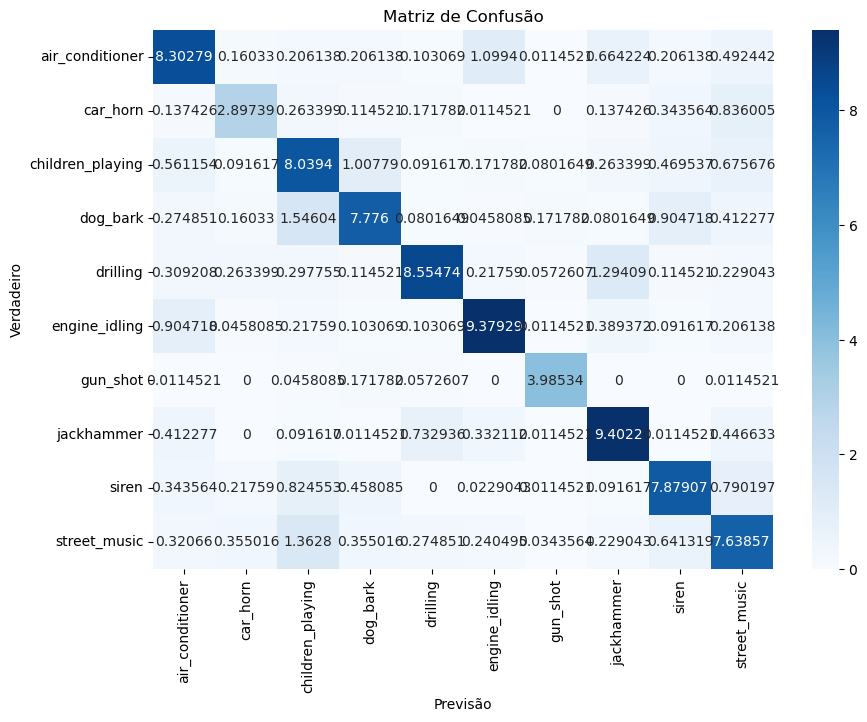

In [18]:
print(best_model.summary())
print("Learning rate: ", best_model_lr)
print("Number of epochs: ", best_model_epochs)
print("Batch Size: ", best_model_batch_size)
print("Accuracy: ", best_model_accuracy)
print("Loss: ", best_model_loss)
print("Standadr Deviation: ", best_model_std)

cm = pd.DataFrame(best_model_cfm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.show()

## Encontrar o melhor modelo MLP (dataset proveniente do PCA)

In [17]:
best_model = None
best_model_accuracy = 0
for model_func in models:
    n_neur, output_dim = n_neuronios(new_X)
    model = model_func(new_X, n_neur, output_dim)
    model, model_accuracy, model_cfm, model_loss, model_std, model_lr, model_epochs, model_batch_size = grid_search(model, new_X)
    if best_model == None or model_accuracy > best_model_accuracy:
        best_model = model
        best_model_accuracy = model_accuracy
        best_model_cfm = model_cfm
        best_model_loss = model_loss
        best_model_std = model_std
        best_model_lr = model_lr
        best_model_epochs = model_epochs
        best_model_batch_size = model_batch_size

Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2581 - loss: 1.8905 - val_accuracy: 0.3524 - val_loss: 1.6516 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 872us/step - accuracy: 0.3653 - loss: 1.6496 - val_accuracy: 0.4027 - val_loss: 1.6027 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.3732 - loss: 1.6302 - val_accuracy: 0.4428 - val_loss: 1.4979 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3906 - loss: 1.6132 - val_accuracy: 0.4188 - val_loss: 1.5164 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3829 - loss: 1.6206 - val_accuracy: 0.4050 - val_loss: 1.5522 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.3985 - loss: 1.5778 - val_accuracy: 0.3364 - val_loss: 1.6879 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3997 - loss: 1.5

Epoch 45/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4544 - loss: 1.3932 - val_accuracy: 0.4668 - val_loss: 1.3695 - learning_rate: 0.0063
Epoch 46/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4562 - loss: 1.4072 - val_accuracy: 0.4600 - val_loss: 1.3704 - learning_rate: 0.0063
Epoch 47/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4534 - loss: 1.3906 - val_accuracy: 0.4565 - val_loss: 1.3740 - learning_rate: 0.0063
Epoch 48/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4499 - loss: 1.4096 - val_accuracy: 0.4588 - val_loss: 1.3690 - learning_rate: 0.0063
Epoch 49/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4600 - loss: 1.3877 - val_accuracy: 0.4565 - val_loss: 1.3686 - learning_rate: 0.0063
Epoch 50/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4621 - loss: 1.3798 - val_accuracy: 0.4645 - val_loss: 1.3712 - learning_rate: 0.0063
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4326 - loss: 1.4760 
28/28 ━━

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4521 - loss: 1.4170 - val_accuracy: 0.4674 - val_loss: 1.3673 - learning_rate: 0.0031
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4776 - loss: 1.3706 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.4660 - loss: 1.3874 - val_accuracy: 0.4479 - val_loss: 1.3947 - learning_rate: 0.0031
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4546 - loss: 1.3978 - val_accuracy: 0.4639 - val_loss: 1.3951 - learning_rate: 0.0031
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4644 - loss: 1.4037 - val_accuracy: 0.4559 - val_loss: 1.3919 - learning_rate: 0.0031
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4607 - loss: 1.4001 - val_accuracy: 0.4685 - val_loss: 1.3956 - learning_rate: 0.0031
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4594 - loss: 1.3969 - val_accuracy: 0.4628 - val_loss: 1.3970 - learning

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4023 - loss: 1.5566 - val_accuracy: 0.4536 - val_loss: 1.4781 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4209 - loss: 1.5207 - val_accuracy: 0.4593 - val_loss: 1.4782 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4212 - loss: 1.5100 - val_accuracy: 0.3940 - val_loss: 1.5238 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.4140 - loss: 1.4993
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4092 - loss: 1.5374 - val_accuracy: 0.4685 - val_loss: 1.4493 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4354 - loss: 1.4963 - val_accuracy: 0.4078 - val_loss: 1.5390 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.3995 - loss: 1.5382 - val_accuracy: 0.3803 - val_loss: 1.6123 - lea

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4183 - loss: 1.5058 - val_accuracy: 0.4027 - val_loss: 1.5866 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4089 - loss: 1.5328 - val_accuracy: 0.3959 - val_loss: 1.5598 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4099 - loss: 1.5233 - val_accuracy: 0.4199 - val_loss: 1.5374 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3997 - loss: 1.4865 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4359 - loss: 1.4759 - val_accuracy: 0.4211 - val_loss: 1.4424 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4179 - loss: 1.5000 - val_accuracy: 0.4302 - val_loss: 1.4685 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4472 - loss: 1.4603 - val_accuracy: 0.3890 - val_loss: 1.5195 - learni

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4473 - loss: 1.4667 - val_accuracy: 0.4009 - val_loss: 1.4668 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4414 - loss: 1.4735 - val_accuracy: 0.4433 - val_loss: 1.4579 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4327 - loss: 1.5049 - val_accuracy: 0.4044 - val_loss: 1.4820 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4445 - loss: 1.4283 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4369 - loss: 1.4692 - val_accuracy: 0.4662 - val_loss: 1.4178 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4333 - loss: 1.4768 - val_accuracy: 0.4273 - val_loss: 1.4037 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4337 - loss: 1.4688 - val_accuracy: 0.4502 - val_loss: 1.4509 - learni

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4267 - loss: 1.4586 - val_accuracy: 0.4124 - val_loss: 1.4976 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4592 - loss: 1.4341 - val_accuracy: 0.4433 - val_loss: 1.4933 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4425 - loss: 1.4416 - val_accuracy: 0.4204 - val_loss: 1.5429 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4538 - loss: 1.4684 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4422 - loss: 1.4522 - val_accuracy: 0.4639 - val_loss: 1.3677 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4646 - loss: 1.4135 - val_accuracy: 0.5017 - val_loss: 1.3407 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4588 - loss: 1.4150 - val_accuracy: 0.4868 - val_loss: 1.3601 - learning_rate: 0.10

Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3762 - loss: 1.6147 - val_accuracy: 0.3757 - val_loss: 1.5988 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 944us/step - accuracy: 0.3790 - loss: 1.6001 - val_accuracy: 0.4227 - val_loss: 1.5664 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3815 - loss: 1.6132 - val_accuracy: 0.3986 - val_loss: 1.5513 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4328 - loss: 1.5341 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3774 - loss: 1.5973 - val_accuracy: 0.3540 - val_loss: 1.5466 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3935 - loss: 1.5651 - val_accuracy: 0.4032 - val_loss: 1.5205 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3967 - loss: 1.5840 - val_accuracy: 0.4021 - val_lo

Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3801 - loss: 1.6085 - val_accuracy: 0.3058 - val_loss: 1.6026 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3634 - loss: 1.6280 - val_accuracy: 0.3769 - val_loss: 1.6415 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.3750 - loss: 1.6238 - val_accuracy: 0.3723 - val_loss: 1.5930 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.3886 - loss: 1.5662
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3850 - loss: 1.6234 - val_accuracy: 0.3895 - val_loss: 1.5453 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.3869 - loss: 1.5957 - val_accuracy: 0.3826 - val_loss: 1.5596 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.3810 - loss: 1.5950 - val_accuracy: 0.3803 - v

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.4224 - loss: 1.5273 - val_accuracy: 0.3986 - val_loss: 1.5546 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.4016 - loss: 1.5368 - val_accuracy: 0.4147 - val_loss: 1.5428 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4100 - loss: 1.5468 - val_accuracy: 0.3436 - val_loss: 1.5862 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3712 - loss: 1.5916 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3999 - loss: 1.5582 - val_accuracy: 0.4318 - val_loss: 1.5114 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4145 - loss: 1.5437 - val_accuracy: 0.4674 - val_loss: 1.5139 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4097 - loss: 1.5342 - val_accuracy: 0.3585 - val_

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3982 - loss: 1.5611 - val_accuracy: 0.3849 - val_loss: 1.5771 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4032 - loss: 1.5493 - val_accuracy: 0.4181 - val_loss: 1.6053 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4087 - loss: 1.5430 - val_accuracy: 0.4009 - val_loss: 1.6001 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.4325 - loss: 1.5227
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4111 - loss: 1.5397 - val_accuracy: 0.4215 - val_loss: 1.4949 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4162 - loss: 1.5215 - val_accuracy: 0.4204 - val_loss: 1.4624 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4125 - loss: 1.5428 - val_accuracy: 0.4490 - val_los

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 964us/step - accuracy: 0.4032 - loss: 1.5602 - val_accuracy: 0.4085 - val_loss: 1.5822 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4245 - loss: 1.5353 - val_accuracy: 0.4050 - val_loss: 1.5505 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4005 - loss: 1.5451 - val_accuracy: 0.4119 - val_loss: 1.5700 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 798us/step - accuracy: 0.4018 - loss: 1.5583
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4151 - loss: 1.5195 - val_accuracy: 0.4176 - val_loss: 1.5004 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4247 - loss: 1.4837 - val_accuracy: 0.4142 - val_loss: 1.5131 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4260 - loss: 1.5027 - val_accuracy: 0.3799 - val_l

Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4267 - loss: 1.5065 - val_accuracy: 0.4318 - val_loss: 1.4742 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4138 - loss: 1.5218 - val_accuracy: 0.4353 - val_loss: 1.5302 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4228 - loss: 1.5231 - val_accuracy: 0.4284 - val_loss: 1.5075 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4266 - loss: 1.5520 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4225 - loss: 1.5098 - val_accuracy: 0.4238 - val_loss: 1.5143 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4232 - loss: 1.4997 - val_accuracy: 0.4124 - val_loss: 1.5073 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4101 - loss: 1.4987 - val_accuracy: 0.4273 - val_loss:

Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4129 - loss: 1.5210 - val_accuracy: 0.4192 - val_loss: 1.4953 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4165 - loss: 1.5098 - val_accuracy: 0.4444 - val_loss: 1.5323 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4189 - loss: 1.5362 - val_accuracy: 0.4410 - val_loss: 1.4725 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.4401 - loss: 1.4488
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4199 - loss: 1.5051 - val_accuracy: 0.4204 - val_loss: 1.4750 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4303 - loss: 1.5030 - val_accuracy: 0.4273 - val_loss: 1.4931 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4200 - loss: 1.5213 - val_accuracy: 0.4238 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4244 - loss: 1.4812 - val_accuracy: 0.4124 - val_loss: 1.5514 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4244 - loss: 1.4981 - val_accuracy: 0.4101 - val_loss: 1.5424 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4270 - loss: 1.4742 - val_accuracy: 0.4204 - val_loss: 1.4932 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4272 - loss: 1.4548 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.4403 - loss: 1.4608 - val_accuracy: 0.4513 - val_loss: 1.3965 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4390 - loss: 1.4513 - val_accuracy: 0.4227 - val_loss: 1.4564 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4298 - loss: 1.4933 - val_accuracy: 0.4513 - val_loss: 1.4011 - learning_rate:

Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.3861 - loss: 1.6234 - val_accuracy: 0.4101 - val_loss: 1.5468 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 971us/step - accuracy: 0.3770 - loss: 1.6283 - val_accuracy: 0.4124 - val_loss: 1.6160 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3917 - loss: 1.6149 - val_accuracy: 0.4192 - val_loss: 1.5378 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.4032 - loss: 1.5334
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3910 - loss: 1.5934 - val_accuracy: 0.3173 - val_loss: 1.7016 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3779 - loss: 1.5935 - val_accuracy: 0.4215 - val_loss: 1.5236 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3924 - loss: 1.6026 - val_accuracy: 0.4135 - val

Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.3878 - loss: 1.6094 - val_accuracy: 0.3986 - val_loss: 1.5722 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.3976 - loss: 1.5859 - val_accuracy: 0.3906 - val_loss: 1.5441 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.3816 - loss: 1.6140 - val_accuracy: 0.3780 - val_loss: 1.6372 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3884 - loss: 1.5930 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3887 - loss: 1.6021 - val_accuracy: 0.3677 - val_loss: 1.6923 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.3792 - loss: 1.5984 - val_accuracy: 0.3528 - val_loss: 1.5736 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.3866 - loss: 1.5928 - val_accuracy: 0.3998 

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4004 - loss: 1.5392 - val_accuracy: 0.3860 - val_loss: 1.5716 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4100 - loss: 1.5639 - val_accuracy: 0.4330 - val_loss: 1.4990 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.4058 - loss: 1.5327 - val_accuracy: 0.4238 - val_loss: 1.5340 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3881 - loss: 1.5563 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4085 - loss: 1.5482 - val_accuracy: 0.4089 - val_loss: 1.4920 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.4051 - loss: 1.5256 - val_accuracy: 0.4021 - val_loss: 1.5844 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4078 - loss: 1.5495 - val_accuracy: 0.4135 - val_

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4143 - loss: 1.5345 - val_accuracy: 0.4032 - val_loss: 1.5467 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.3941 - loss: 1.5534 - val_accuracy: 0.4250 - val_loss: 1.5166 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.4157 - loss: 1.5164 - val_accuracy: 0.3963 - val_loss: 1.5312 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - accuracy: 0.4242 - loss: 1.5064
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3954 - loss: 1.5457 - val_accuracy: 0.3918 - val_loss: 1.4965 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4004 - loss: 1.5506 - val_accuracy: 0.4192 - val_loss: 1.4871 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4070 - loss: 1.5565 - val_accuracy: 0.4181 - val

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4016 - loss: 1.5644 - val_accuracy: 0.4039 - val_loss: 1.5567 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4093 - loss: 1.5224 - val_accuracy: 0.3776 - val_loss: 1.5734 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3992 - loss: 1.5397 - val_accuracy: 0.3650 - val_loss: 1.5928 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.3365 - loss: 1.5804
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4202 - loss: 1.5044 - val_accuracy: 0.4176 - val_loss: 1.4871 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.4131 - loss: 1.5251 - val_accuracy: 0.4188 - val_loss: 1.4999 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4158 - loss: 1.5105 - val_accuracy: 0.3822 - val_l

Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4129 - loss: 1.5123 - val_accuracy: 0.4364 - val_loss: 1.4932 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4252 - loss: 1.5129 - val_accuracy: 0.4227 - val_loss: 1.5126 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4200 - loss: 1.5038 - val_accuracy: 0.4376 - val_loss: 1.4923 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4411 - loss: 1.5096 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4167 - loss: 1.5139 - val_accuracy: 0.4433 - val_loss: 1.5098 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4162 - loss: 1.5211 - val_accuracy: 0.4112 - val_loss: 1.5090 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4202 - loss: 1.5231 - val_accuracy: 0.3895 - val_loss

Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.4289 - loss: 1.5062 - val_accuracy: 0.4124 - val_loss: 1.4926 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4242 - loss: 1.4978 - val_accuracy: 0.4055 - val_loss: 1.4785 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4239 - loss: 1.5304 - val_accuracy: 0.4490 - val_loss: 1.4505 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.4420 - loss: 1.4416
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4198 - loss: 1.5118 - val_accuracy: 0.4261 - val_loss: 1.4863 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4186 - loss: 1.5034 - val_accuracy: 0.4158 - val_loss: 1.4728 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4285 - loss: 1.4936 - val_accuracy: 0.4387 - val_l

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4300 - loss: 1.4832 - val_accuracy: 0.4089 - val_loss: 1.4750 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4216 - loss: 1.4891 - val_accuracy: 0.4387 - val_loss: 1.4678 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4289 - loss: 1.4600 - val_accuracy: 0.4250 - val_loss: 1.4714 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.3812 - loss: 1.5010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4334 - loss: 1.4733 - val_accuracy: 0.4467 - val_loss: 1.4629 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4354 - loss: 1.4767 - val_accuracy: 0.4570 - val_loss: 1.4409 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4303 - loss: 1.4826 - val_accuracy: 0.4261 - val_loss: 1.4407 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4285 - loss: 1.4835 - val_accuracy: 0.4291 - val_loss: 1.5216 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4311 - loss: 1.4747 - val_accuracy: 0.4188 - val_loss: 1.5099 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4288 - loss: 1.4792 - val_accuracy: 0.4211 - val_loss: 1.5397 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step - accuracy: 0.3907 - loss: 1.5178
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4480 - loss: 1.4241 - val_accuracy: 0.4428 - val_loss: 1.4484 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4442 - loss: 1.4239 - val_accuracy: 0.4314 - val_loss: 1.4374 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4302 - loss: 1.4557 - val_accuracy: 0.4336 - val_loss: 1.4361 - learning_

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4696 - loss: 1.4235 - val_accuracy: 0.4696 - val_loss: 1.4138 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4751 - loss: 1.4119 - val_accuracy: 0.4433 - val_loss: 1.4253 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4612 - loss: 1.4181 - val_accuracy: 0.4536 - val_loss: 1.4072 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.4820 - loss: 1.3745
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4741 - loss: 1.4149 - val_accuracy: 0.4605 - val_loss: 1.4278 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4674 - loss: 1.4276 - val_accuracy: 0.4777 - val_loss: 1.4096 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4701 - loss: 1.4193 - val_accuracy: 0.4616 - val_loss: 1.4089 - learn

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 865us/step - accuracy: 0.4596 - loss: 1.4219 - val_accuracy: 0.4628 - val_loss: 1.4183 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.4628 - loss: 1.4252 - val_accuracy: 0.4559 - val_loss: 1.4114 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.4644 - loss: 1.4304 - val_accuracy: 0.4433 - val_loss: 1.4346 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 745us/step - accuracy: 0.4617 - loss: 1.4255
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4605 - loss: 1.4103 - val_accuracy: 0.4616 - val_loss: 1.3972 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.4814 - loss: 1.4078 - val_accuracy: 0.4834 - val_loss: 1.3885 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.4680 - loss: 1.3968 - val_accuracy: 0.4674 - val_loss: 1.39

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 869us/step - accuracy: 0.4711 - loss: 1.4059 - val_accuracy: 0.4536 - val_loss: 1.4492 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4634 - loss: 1.4201 - val_accuracy: 0.4708 - val_loss: 1.4588 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4725 - loss: 1.4235 - val_accuracy: 0.4731 - val_loss: 1.4499 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 620us/step - accuracy: 0.4880 - loss: 1.4043
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4743 - loss: 1.4012 - val_accuracy: 0.4983 - val_loss: 1.3639 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 918us/step - accuracy: 0.4842 - loss: 1.4130 - val_accuracy: 0.4742 - val_loss: 1.3564 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.4700 - loss: 1.3808 - val_accuracy: 0.4788 - val_los

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4753 - loss: 1.3972 - val_accuracy: 0.4634 - val_loss: 1.4605 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4745 - loss: 1.4124 - val_accuracy: 0.4531 - val_loss: 1.4689 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4675 - loss: 1.4059 - val_accuracy: 0.4508 - val_loss: 1.4585 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 627us/step - accuracy: 0.4309 - loss: 1.4358
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4717 - loss: 1.3933 - val_accuracy: 0.4714 - val_loss: 1.3866 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4769 - loss: 1.4087 - val_accuracy: 0.4725 - val_loss: 1.3898 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4643 - loss: 1.4175 - val_accuracy: 0.4760 - val_loss: 1.3

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4698 - loss: 1.4006 - val_accuracy: 0.4708 - val_loss: 1.4087 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.4742 - loss: 1.4107 - val_accuracy: 0.4456 - val_loss: 1.4109 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4669 - loss: 1.4226 - val_accuracy: 0.4639 - val_loss: 1.4070 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.4488 - loss: 1.3657
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4720 - loss: 1.4157 - val_accuracy: 0.4651 - val_loss: 1.3976 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.4677 - loss: 1.4043 - val_accuracy: 0.4731 - val_loss: 1.3954 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.4760 - loss: 1.4216 - val_accuracy: 0.4800 - val_loss: 1.3960 -

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4860 - loss: 1.3979 - val_accuracy: 0.4605 - val_loss: 1.4444 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4728 - loss: 1.4112 - val_accuracy: 0.4674 - val_loss: 1.4470 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4669 - loss: 1.3995 - val_accuracy: 0.4570 - val_loss: 1.4466 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 786us/step - accuracy: 0.4604 - loss: 1.3958
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4671 - loss: 1.4172 - val_accuracy: 0.4880 - val_loss: 1.3581 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4739 - loss: 1.3835 - val_accuracy: 0.4914 - val_loss: 1.3564 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4722 - loss: 1.4049 - val_accuracy: 0.4926 - val_loss: 1.3573 - learning_rate: 0.

Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4845 - loss: 1.4015 - val_accuracy: 0.4490 - val_loss: 1.4189 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4728 - loss: 1.4092 - val_accuracy: 0.4926 - val_loss: 1.4039 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4625 - loss: 1.4160 - val_accuracy: 0.4559 - val_loss: 1.4071 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4261 - loss: 1.4196 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4799 - loss: 1.4026 - val_accuracy: 0.4811 - val_loss: 1.4250 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4552 - loss: 1.4247 - val_accuracy: 0.4765 - val_loss: 1.4270 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4641 - loss: 1.4389 - val_accuracy: 0.4662 - val_loss

Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4644 - loss: 1.4225 - val_accuracy: 0.4628 - val_loss: 1.4181 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4687 - loss: 1.4247 - val_accuracy: 0.4674 - val_loss: 1.4185 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4459 - loss: 1.4452 - val_accuracy: 0.4628 - val_loss: 1.4040 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step - accuracy: 0.4657 - loss: 1.3763
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4670 - loss: 1.4186 - val_accuracy: 0.4651 - val_loss: 1.4116 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4646 - loss: 1.4166 - val_accuracy: 0.4467 - val_loss: 1.4062 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4676 - loss: 1.4039 - val_accuracy: 0.4639 - val_los

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4804 - loss: 1.4109 - val_accuracy: 0.4651 - val_loss: 1.4119 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4678 - loss: 1.4396 - val_accuracy: 0.4845 - val_loss: 1.4017 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4675 - loss: 1.4082 - val_accuracy: 0.4605 - val_loss: 1.4097 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.4489 - loss: 1.4201
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4753 - loss: 1.3864 - val_accuracy: 0.4868 - val_loss: 1.3889 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4660 - loss: 1.4084 - val_accuracy: 0.4639 - val_loss: 1.3931 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4636 - loss: 1.4116 - val_accuracy: 0.4708 - val_los

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4716 - loss: 1.4049 - val_accuracy: 0.4593 - val_loss: 1.4488 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4745 - loss: 1.4196 - val_accuracy: 0.4628 - val_loss: 1.4517 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.4775 - loss: 1.3996 - val_accuracy: 0.4777 - val_loss: 1.4410 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4751 - loss: 1.4023 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4636 - loss: 1.4188 - val_accuracy: 0.5063 - val_loss: 1.3623 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.4739 - loss: 1.4078 - val_accuracy: 0.4845 - val_loss: 1.3559 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.4727 - loss: 1.4087 - val_accuracy: 0.4926 - va

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4715 - loss: 1.4113 - val_accuracy: 0.4497 - val_loss: 1.4656 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4751 - loss: 1.4108 - val_accuracy: 0.4805 - val_loss: 1.4585 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.4756 - loss: 1.4207 - val_accuracy: 0.4531 - val_loss: 1.4646 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.4350 - loss: 1.4365
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4515 - loss: 1.4402 - val_accuracy: 0.4668 - val_loss: 1.3884 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.4812 - loss: 1.3861 - val_accuracy: 0.4874 - val_loss: 1.3936 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.4747 - loss: 1.4005 - val_accuracy: 0.4680 - v

Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4718 - loss: 1.4139 - val_accuracy: 0.4857 - val_loss: 1.3886 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4709 - loss: 1.4145 - val_accuracy: 0.4708 - val_loss: 1.3896 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4671 - loss: 1.4093 - val_accuracy: 0.4948 - val_loss: 1.3913 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.4794 - loss: 1.3949
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4735 - loss: 1.3973 - val_accuracy: 0.4742 - val_loss: 1.4196 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4743 - loss: 1.4295 - val_accuracy: 0.4639 - val_loss: 1.4223 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4684 - loss: 1.4098 - val_accuracy: 0.4742 - val_los

Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.4679 - loss: 1.4378 - val_accuracy: 0.4536 - val_loss: 1.4117 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4760 - loss: 1.4068 - val_accuracy: 0.4433 - val_loss: 1.4141 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4707 - loss: 1.4053 - val_accuracy: 0.4548 - val_loss: 1.4178 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.4481 - loss: 1.3783
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4712 - loss: 1.3894 - val_accuracy: 0.4548 - val_loss: 1.3974 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4636 - loss: 1.4229 - val_accuracy: 0.4765 - val_loss: 1.4019 - learning_rate: 0.0100
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4797 - loss: 1.4061 - val_accuracy: 0.4754 - val_l

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4741 - loss: 1.4109 - val_accuracy: 0.4616 - val_loss: 1.4078 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4715 - loss: 1.4179 - val_accuracy: 0.4685 - val_loss: 1.3994 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4751 - loss: 1.4144 - val_accuracy: 0.4696 - val_loss: 1.4019 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.4704 - loss: 1.4140
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4746 - loss: 1.4057 - val_accuracy: 0.4822 - val_loss: 1.3819 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4631 - loss: 1.4173 - val_accuracy: 0.4674 - val_loss: 1.3873 - learning_rate: 0.0100
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4717 - loss: 1.3975 - val_accuracy: 0.4731 - val_loss: 1.3801 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4678 - loss: 1.4006 - val_accuracy: 0.4931 - val_loss: 1.4529 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4752 - loss: 1.4163 - val_accuracy: 0.4714 - val_loss: 1.4582 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4718 - loss: 1.4162 - val_accuracy: 0.4703 - val_loss: 1.4550 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4289 - loss: 1.4323 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4622 - loss: 1.4183 - val_accuracy: 0.4645 - val_loss: 1.3991 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4703 - loss: 1.3958 - val_accuracy: 0.4817 - val_loss: 1.4072 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4702 - loss: 1.4056 - val_accuracy: 0.4497 - val_loss: 1.4078 - learnin

Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4705 - loss: 1.4220 - val_accuracy: 0.4593 - val_loss: 1.4204 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4612 - loss: 1.4283 - val_accuracy: 0.4593 - val_loss: 1.3994 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4710 - loss: 1.4301 - val_accuracy: 0.4685 - val_loss: 1.4106 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.4454 - loss: 1.4223
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4705 - loss: 1.4298 - val_accuracy: 0.4765 - val_loss: 1.4258 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.4651 - loss: 1.4278 - val_accuracy: 0.4582 - val_loss: 1.4419 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4600 - loss: 1.4294 - val_accuracy: 0.4834 - val_lo

Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4613 - loss: 1.4157 - val_accuracy: 0.4582 - val_loss: 1.4253 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4714 - loss: 1.4279 - val_accuracy: 0.4433 - val_loss: 1.4193 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4652 - loss: 1.4180 - val_accuracy: 0.4708 - val_loss: 1.4094 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4657 - loss: 1.3799 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4584 - loss: 1.4446 - val_accuracy: 0.4696 - val_loss: 1.4147 - learning_rate: 0.0100
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4697 - loss: 1.4215 - val_accuracy: 0.4651 - val_loss: 1.4025 - learning_rate: 0.0100
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4595 - loss: 1.4221 - val_accuracy: 0.4525 - val_loss:

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4686 - loss: 1.4386 - val_accuracy: 0.4742 - val_loss: 1.4110 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4700 - loss: 1.4109 - val_accuracy: 0.4685 - val_loss: 1.4023 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4668 - loss: 1.4248 - val_accuracy: 0.4800 - val_loss: 1.4047 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.4718 - loss: 1.4168
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4717 - loss: 1.4161 - val_accuracy: 0.5017 - val_loss: 1.3887 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4641 - loss: 1.4124 - val_accuracy: 0.4742 - val_loss: 1.3914 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4675 - loss: 1.4281 - val_accuracy: 0.4708 - val_los

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4666 - loss: 1.4378 - val_accuracy: 0.4616 - val_loss: 1.4499 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4704 - loss: 1.4177 - val_accuracy: 0.4605 - val_loss: 1.4459 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4629 - loss: 1.4051 - val_accuracy: 0.4456 - val_loss: 1.4726 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.4593 - loss: 1.4139
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4712 - loss: 1.4089 - val_accuracy: 0.4834 - val_loss: 1.3665 - learning_rate: 0.0100
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4594 - loss: 1.4233 - val_accuracy: 0.4834 - val_loss: 1.3627 - learning_rate: 0.0100
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4606 - loss: 1.4325 - val_accuracy: 0.4754 - val_los

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4723 - loss: 1.4075 - val_accuracy: 0.4691 - val_loss: 1.4667 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4732 - loss: 1.4251 - val_accuracy: 0.4622 - val_loss: 1.4676 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4582 - loss: 1.4317 - val_accuracy: 0.4657 - val_loss: 1.4630 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4434 - loss: 1.4287 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4653 - loss: 1.4293 - val_accuracy: 0.4748 - val_loss: 1.3843 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4786 - loss: 1.4004 - val_accuracy: 0.4783 - val_loss: 1.3848 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4658 - loss: 1.3972 - val_accuracy: 0.4828 - val_loss

Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4754 - loss: 1.3985 - val_accuracy: 0.4914 - val_loss: 1.3936 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4704 - loss: 1.4280 - val_accuracy: 0.4857 - val_loss: 1.3915 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4860 - loss: 1.3962 - val_accuracy: 0.4742 - val_loss: 1.3901 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - accuracy: 0.4551 - loss: 1.4039
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4701 - loss: 1.4113 - val_accuracy: 0.4742 - val_loss: 1.4153 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4727 - loss: 1.4179 - val_accuracy: 0.4880 - val_loss: 1.4131 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4697 - loss: 1.4163 - val_accuracy: 0.4765 - val_los

Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4715 - loss: 1.4207 - val_accuracy: 0.4742 - val_loss: 1.3932 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4648 - loss: 1.4156 - val_accuracy: 0.4662 - val_loss: 1.3975 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4756 - loss: 1.4224 - val_accuracy: 0.4605 - val_loss: 1.3991 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.4467 - loss: 1.3687
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4747 - loss: 1.4212 - val_accuracy: 0.4765 - val_loss: 1.3911 - learning_rate: 0.0100
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4690 - loss: 1.4088 - val_accuracy: 0.4754 - val_loss: 1.3880 - learning_rate: 0.0100
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4674 - loss: 1.4212 - val_accuracy: 0.4674 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4715 - loss: 1.4110 - val_accuracy: 0.4880 - val_loss: 1.4090 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4737 - loss: 1.4130 - val_accuracy: 0.4525 - val_loss: 1.4099 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4748 - loss: 1.3955 - val_accuracy: 0.4754 - val_loss: 1.4059 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.4941 - loss: 1.4018
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4898 - loss: 1.3875 - val_accuracy: 0.4719 - val_loss: 1.3816 - learning_rate: 0.0100
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4637 - loss: 1.4302 - val_accuracy: 0.4868 - val_loss: 1.3857 - learning_rate: 0.0100
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4977 - loss: 1.3878 - val_accuracy: 0.4777 - val_loss: 1.3896 - learning_rat

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4913 - loss: 1.3978 - val_accuracy: 0.4783 - val_loss: 1.4522 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4763 - loss: 1.4102 - val_accuracy: 0.4748 - val_loss: 1.4517 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4750 - loss: 1.3972 - val_accuracy: 0.4794 - val_loss: 1.4537 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.4446 - loss: 1.4086
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4755 - loss: 1.3877 - val_accuracy: 0.4794 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 920us/step - accuracy: 0.4769 - loss: 1.3912 - val_accuracy: 0.4771 - val_loss: 1.3801 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 761us/step - accuracy: 0.4700 - loss: 1.3921 - val_accuracy: 0.4851 - val_loss: 1.3744 - learn

Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.4761 - loss: 1.3971 - val_accuracy: 0.4857 - val_loss: 1.3685 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.4819 - loss: 1.3910 - val_accuracy: 0.4891 - val_loss: 1.3699 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 797us/step - accuracy: 0.4769 - loss: 1.3761 - val_accuracy: 0.4937 - val_loss: 1.3700 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 796us/step - accuracy: 0.4553 - loss: 1.3884
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4794 - loss: 1.4047 - val_accuracy: 0.4868 - val_loss: 1.3989 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4747 - loss: 1.4089 - val_accuracy: 0.4914 - val_loss: 1.3985 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.4778 - loss: 1.4055 - val_accuracy: 0.4800 - val_l

Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step - accuracy: 0.4833 - loss: 1.3960 - val_accuracy: 0.4708 - val_loss: 1.3845 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 973us/step - accuracy: 0.4854 - loss: 1.4100 - val_accuracy: 0.4719 - val_loss: 1.3843 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.4807 - loss: 1.3958 - val_accuracy: 0.4651 - val_loss: 1.3856 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 764us/step - accuracy: 0.4732 - loss: 1.3557
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4736 - loss: 1.4067 - val_accuracy: 0.4822 - val_loss: 1.3759 - learning_rate: 0.0010
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.4845 - loss: 1.3817 - val_accuracy: 0.4731 - val_loss: 1.3780 - learning_rate: 0.0010
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.4760 - loss: 1.3837 - val_accuracy: 0.4708 - val

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.4697 - loss: 1.4059 - val_accuracy: 0.4605 - val_loss: 1.4024 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 789us/step - accuracy: 0.4868 - loss: 1.3829 - val_accuracy: 0.4628 - val_loss: 1.4025 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.4860 - loss: 1.3953 - val_accuracy: 0.4605 - val_loss: 1.4012 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.4779 - loss: 1.3899
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4787 - loss: 1.3957 - val_accuracy: 0.4536 - val_loss: 1.3809 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.4831 - loss: 1.3886 - val_accuracy: 0.4628 - val_loss: 1.3836 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 848us/step - accuracy: 0.4852 - loss: 1.3871 - val_accuracy: 0.4651 - val

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.4893 - loss: 1.3836 - val_accuracy: 0.4788 - val_loss: 1.4451 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.4784 - loss: 1.3810 - val_accuracy: 0.4777 - val_loss: 1.4449 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.4836 - loss: 1.3830 - val_accuracy: 0.4800 - val_loss: 1.4445 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step - accuracy: 0.4741 - loss: 1.3822
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4838 - loss: 1.3809 - val_accuracy: 0.4788 - val_loss: 1.3514 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.4796 - loss: 1.3897 - val_accuracy: 0.4800 - val_loss: 1.3479 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 922us/step - accuracy: 0.4799 - loss: 1.3822 - val_accuracy: 0.4868 - val

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4836 - loss: 1.4013 - val_accuracy: 0.4783 - val_loss: 1.4452 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.4775 - loss: 1.3859 - val_accuracy: 0.4760 - val_loss: 1.4430 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.4708 - loss: 1.3982 - val_accuracy: 0.4805 - val_loss: 1.4424 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - accuracy: 0.4480 - loss: 1.4050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4837 - loss: 1.3784 - val_accuracy: 0.4828 - val_loss: 1.3735 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4916 - loss: 1.3612 - val_accuracy: 0.4805 - val_loss: 1.3734 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4689 - loss: 1.4066 - val_accuracy: 0.4851 - val_loss:

Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4815 - loss: 1.3811 - val_accuracy: 0.4903 - val_loss: 1.3668 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.4740 - loss: 1.3851 - val_accuracy: 0.4880 - val_loss: 1.3674 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4661 - loss: 1.4190 - val_accuracy: 0.4880 - val_loss: 1.3663 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 693us/step - accuracy: 0.4672 - loss: 1.3838
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4702 - loss: 1.4096 - val_accuracy: 0.4834 - val_loss: 1.4004 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4804 - loss: 1.4109 - val_accuracy: 0.4857 - val_loss: 1.3985 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4858 - loss: 1.3707 - val_accuracy: 0.4857 - val_loss: 1

Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.4728 - loss: 1.4114 - val_accuracy: 0.4639 - val_loss: 1.3864 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.4820 - loss: 1.3889 - val_accuracy: 0.4708 - val_loss: 1.3863 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.4840 - loss: 1.3878 - val_accuracy: 0.4662 - val_loss: 1.3851 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 676us/step - accuracy: 0.4659 - loss: 1.3532
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4799 - loss: 1.3897 - val_accuracy: 0.4822 - val_loss: 1.3749 - learning_rate: 0.0010
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4857 - loss: 1.3978 - val_accuracy: 0.4845 - val_loss: 1.3743 - learning_rate: 0.0010
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4739 - loss: 1.3995 - val_accuracy: 0.4765 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4756 - loss: 1.3930 - val_accuracy: 0.4777 - val_loss: 1.4445 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4879 - loss: 1.3787 - val_accuracy: 0.4788 - val_loss: 1.4443 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4760 - loss: 1.4163 - val_accuracy: 0.4765 - val_loss: 1.4445 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 779us/step - accuracy: 0.4769 - loss: 1.3792
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4711 - loss: 1.3927 - val_accuracy: 0.4777 - val_loss: 1.3474 - learning_rate: 0.0010
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4839 - loss: 1.3947 - val_accuracy: 0.4811 - val_loss: 1.3493 - learning_rate: 0.0010
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4703 - loss: 1.4024 - val_accuracy: 0.4845 - val_loss: 1.3489 - learning_rate: 0.

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.4724 - loss: 1.3978 - val_accuracy: 0.4834 - val_loss: 1.3683 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 910us/step - accuracy: 0.4814 - loss: 1.4034 - val_accuracy: 0.4960 - val_loss: 1.3671 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 901us/step - accuracy: 0.4670 - loss: 1.4049 - val_accuracy: 0.4880 - val_loss: 1.3665 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.4821 - loss: 1.3994 - val_accuracy: 0.4754 - val_loss: 1.3702 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.4477 - loss: 1.3829
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4778 - loss: 1.3948 - val_accuracy: 0.4903 - val_loss: 1.4000 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step - accuracy: 0.4727 - loss: 1.4025 - val_accuracy: 0.4765 - val_loss:

Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.4756 - loss: 1.4185 - val_accuracy: 0.4731 - val_loss: 1.3844 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4821 - loss: 1.3774 - val_accuracy: 0.4651 - val_loss: 1.3864 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.4676 - loss: 1.3846 - val_accuracy: 0.4674 - val_loss: 1.3835 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step - accuracy: 0.4723 - loss: 1.3977 - val_accuracy: 0.4708 - val_loss: 1.3833 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.4585 - loss: 1.3520
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4869 - loss: 1.3793 - val_accuracy: 0.4845 - val_loss: 1.3733 - learning_rate: 0.0010
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - accuracy: 0.4857 - loss: 1.3919 - val_accuracy: 0.4891 -

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4824 - loss: 1.3734 - val_accuracy: 0.4742 - val_loss: 1.4456 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 839us/step - accuracy: 0.4737 - loss: 1.3980 - val_accuracy: 0.4754 - val_loss: 1.4434 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - accuracy: 0.4751 - loss: 1.3921 - val_accuracy: 0.4742 - val_loss: 1.4451 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.4688 - loss: 1.3947 - val_accuracy: 0.4742 - val_loss: 1.4431 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.4849 - loss: 1.3990 - val_accuracy: 0.4777 - val_loss: 1.4449 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 662us/step - accuracy: 0.4786 - loss: 1.3784
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4715 - loss: 1.4021 - val_accuracy: 0.4788 -

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4778 - loss: 1.3902 - val_accuracy: 0.4822 - val_loss: 1.3655 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4705 - loss: 1.4108 - val_accuracy: 0.4857 - val_loss: 1.3655 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4810 - loss: 1.3846 - val_accuracy: 0.4880 - val_loss: 1.3664 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4747 - loss: 1.3858 - val_accuracy: 0.4891 - val_loss: 1.3656 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - accuracy: 0.4799 - loss: 1.3915 - val_accuracy: 0.4868 - val_loss: 1.3667 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.4833 - loss: 1.3935 - val_accuracy: 0.4880 - val_loss: 1.3679 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - accuracy: 0.4535 - loss: 1.3850
28

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4846 - loss: 1.3886 - val_accuracy: 0.4628 - val_loss: 1.3832 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4723 - loss: 1.3959 - val_accuracy: 0.4639 - val_loss: 1.3829 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.4741 - loss: 1.3829 - val_accuracy: 0.4708 - val_loss: 1.3835 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4710 - loss: 1.4081 - val_accuracy: 0.4674 - val_loss: 1.3853 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4719 - loss: 1.4186 - val_accuracy: 0.4628 - val_loss: 1.3848 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4796 - loss: 1.3922 - val_accuracy: 0.4639 - val_loss: 1.3854 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - accuracy: 0.4589 - loss: 1.3555
28/2

Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4816 - loss: 1.3816 - val_accuracy: 0.4674 - val_loss: 1.4039 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4809 - loss: 1.4046 - val_accuracy: 0.4674 - val_loss: 1.4048 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4764 - loss: 1.3946 - val_accuracy: 0.4616 - val_loss: 1.4043 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4712 - loss: 1.4046 - val_accuracy: 0.4651 - val_loss: 1.4045 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4753 - loss: 1.3989 - val_accuracy: 0.4582 - val_loss: 1.4043 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4801 - loss: 1.3872 - val_accuracy: 0.4674 - val_loss: 1.4045 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 629us/step - accuracy: 0.4825 - loss: 1.3884
28/28 ━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4717 - loss: 1.3889 - val_accuracy: 0.4725 - val_loss: 1.4414 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4814 - loss: 1.3785 - val_accuracy: 0.4725 - val_loss: 1.4413 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4732 - loss: 1.4050 - val_accuracy: 0.4737 - val_loss: 1.4422 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4703 - loss: 1.3983 - val_accuracy: 0.4680 - val_loss: 1.4413 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4742 - loss: 1.3924 - val_accuracy: 0.4760 - val_loss: 1.4420 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4810 - loss: 1.3854 - val_accuracy: 0.4737 - val_loss: 1.4418 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 678us/step - accuracy: 0.4410 - loss: 1.3996
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 798us/step - accuracy: 0.4677 - loss: 1.4128 - val_accuracy: 0.4891 - val_loss: 1.3653 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step - accuracy: 0.4768 - loss: 1.4031 - val_accuracy: 0.4868 - val_loss: 1.3663 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.4809 - loss: 1.3799 - val_accuracy: 0.4857 - val_loss: 1.3684 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.4720 - loss: 1.3958 - val_accuracy: 0.4937 - val_loss: 1.3664 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4804 - loss: 1.3756 - val_accuracy: 0.4914 - val_loss: 1.3662 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.4785 - loss: 1.3827 - val_accuracy: 0.4903 - val_loss: 1.3684 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - accuracy: 0.4520 - loss: 1.3

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.4789 - loss: 1.4016 - val_accuracy: 0.4639 - val_loss: 1.4046 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.4694 - loss: 1.3897 - val_accuracy: 0.4754 - val_loss: 1.4046 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4731 - loss: 1.3957 - val_accuracy: 0.4651 - val_loss: 1.4062 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.4658 - loss: 1.4100 - val_accuracy: 0.4685 - val_loss: 1.4050 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - accuracy: 0.4706 - loss: 1.3976 - val_accuracy: 0.4582 - val_loss: 1.4057 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4740 - loss: 1.3988 - val_accuracy: 0.4616 - val_loss: 1.4047 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 847us/step - accuracy: 0.4855 - loss: 1.37

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4767 - loss: 1.3911 - val_accuracy: 0.4737 - val_loss: 1.4411 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 863us/step - accuracy: 0.4765 - loss: 1.3962 - val_accuracy: 0.4725 - val_loss: 1.4412 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.4699 - loss: 1.3809 - val_accuracy: 0.4737 - val_loss: 1.4418 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.4716 - loss: 1.4048 - val_accuracy: 0.4771 - val_loss: 1.4405 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4805 - loss: 1.3775 - val_accuracy: 0.4737 - val_loss: 1.4415 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.4826 - loss: 1.3888 - val_accuracy: 0.4794 - val_loss: 1.4408 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.4691 - loss: 1.40

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.4666 - loss: 1.4418
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4926 - loss: 1.3809 - val_accuracy: 0.4639 - val_loss: 1.3825 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4839 - loss: 1.3750 - val_accuracy: 0.4674 - val_loss: 1.3829 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4782 - loss: 1.3926 - val_accuracy: 0.4616 - val_loss: 1.3831 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4696 - loss: 1.4054 - val_accuracy: 0.4685 - val_loss: 1.3813 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4745 - loss: 1.4019 - val_accuracy: 0.4685 - val_loss: 1.3827 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4645 - loss: 1.4217 - val_accuracy: 0.4674 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.4370 - loss: 1.4546
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4758 - loss: 1.3873 - val_accuracy: 0.4628 - val_loss: 1.4059 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4765 - loss: 1.3986 - val_accuracy: 0.4616 - val_loss: 1.4053 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4737 - loss: 1.3939 - val_accuracy: 0.4639 - val_loss: 1.4060 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4716 - loss: 1.4223 - val_accuracy: 0.4628 - val_loss: 1.4056 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4729 - loss: 1.3928 - val_accuracy: 0.4696 - val_loss: 1.4062 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4773 - loss: 1.3995 - val_accuracy: 0.4662 - val_loss: 1.4048 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 748us/step - accuracy: 0.4876 - loss: 1.3417
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4771 - loss: 1.4021 - val_accuracy: 0.4725 - val_loss: 1.4414 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4781 - loss: 1.3990 - val_accuracy: 0.4725 - val_loss: 1.4403 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4849 - loss: 1.3800 - val_accuracy: 0.4725 - val_loss: 1.4414 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4777 - loss: 1.3934 - val_accuracy: 0.4714 - val_loss: 1.4404 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4825 - loss: 1.3819 - val_accuracy: 0.4703 - val_loss: 1.4407 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4776 - loss: 1.3822 - val_accuracy: 0.4737 - val_loss: 1.4406 - l

Epoch 33/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - accuracy: 0.6080 - loss: 1.1175 - val_accuracy: 0.6156 - val_loss: 1.0851 - learning_rate: 0.0125
Epoch 34/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 834us/step - accuracy: 0.6068 - loss: 1.1192 - val_accuracy: 0.6156 - val_loss: 1.0822 - learning_rate: 0.0125
Epoch 35/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 818us/step - accuracy: 0.6132 - loss: 1.0927 - val_accuracy: 0.6213 - val_loss: 1.0849 - learning_rate: 0.0125
Epoch 36/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.6017 - loss: 1.1230 - val_accuracy: 0.6144 - val_loss: 1.0840 - learning_rate: 0.0125
Epoch 37/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.6120 - loss: 1.1170 - val_accuracy: 0.6076 - val_loss: 1.0848 - learning_rate: 0.0125
Epoch 38/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.6032 - loss: 1.1104 - val_accuracy: 0.6098 - val_loss: 1.1001 - learning_rate: 0.0125
Epoch 39/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.6

Epoch 14/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.6327 - loss: 1.0780 - val_accuracy: 0.6644 - val_loss: 0.9782 - learning_rate: 0.0031
Epoch 15/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6205 - loss: 1.0827 - val_accuracy: 0.6655 - val_loss: 0.9795 - learning_rate: 0.0031
Epoch 16/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 910us/step - accuracy: 0.6377 - loss: 1.0494 - val_accuracy: 0.6632 - val_loss: 0.9804 - learning_rate: 0.0031
Epoch 17/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6341 - loss: 1.0624 - val_accuracy: 0.6586 - val_loss: 0.9825 - learning_rate: 0.0031
Epoch 18/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6257 - loss: 1.0825 - val_accuracy: 0.6644 - val_loss: 0.9767 - learning_rate: 0.0031
Epoch 19/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.6270 - loss: 1.0779 - val_accuracy: 0.6632 - val_loss: 0.9774 - learning_rate: 0.0031
Epoch 20/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step - accuracy: 0.6

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 882us/step - accuracy: 0.6341 - loss: 1.0737 - val_accuracy: 0.6438 - val_loss: 1.0385 - learning_rate: 7.8125e-04
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.6219 - loss: 1.0837 - val_accuracy: 0.6415 - val_loss: 1.0379 - learning_rate: 7.8125e-04
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step - accuracy: 0.6250 - loss: 1.0872 - val_accuracy: 0.6403 - val_loss: 1.0379 - learning_rate: 7.8125e-04
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.6342 - loss: 1.0769 - val_accuracy: 0.6438 - val_loss: 1.0370 - learning_rate: 7.8125e-04
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.6294 - loss: 1.0790 - val_accuracy: 0.6438 - val_loss: 1.0372 - learning_rate: 7.8125e-04
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 838us/step - accuracy: 0.6092 - loss: 1.0437
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.6308 - loss: 1.0755 - val_accuracy: 0.6

Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.5958 - loss: 1.1537 - val_accuracy: 0.6529 - val_loss: 1.0094 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5999 - loss: 1.1254 - val_accuracy: 0.6300 - val_loss: 1.0748 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5883 - loss: 1.1704 - val_accuracy: 0.6254 - val_loss: 1.0612 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6071 - loss: 1.1617 - val_accuracy: 0.6518 - val_loss: 1.0367 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6041 - loss: 1.1236 - val_accuracy: 0.6541 - val_loss: 1.0450 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6007 - loss: 1.1312 - val_accuracy: 0.6449 - val_loss: 1.0520 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.5728 - loss: 1.2182
28/28 ━━━━

Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6165 - loss: 1.0898 - val_accuracy: 0.6453 - val_loss: 1.0132 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6244 - loss: 1.0869 - val_accuracy: 0.6648 - val_loss: 1.0327 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6318 - loss: 1.0824 - val_accuracy: 0.6533 - val_loss: 1.0325 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - accuracy: 0.6267 - loss: 1.0828 - val_accuracy: 0.6293 - val_loss: 1.0616 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6397 - loss: 1.0642 - val_accuracy: 0.6396 - val_loss: 1.0190 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6271 - loss: 1.0749 - val_accuracy: 0.6396 - val_loss: 1.0132 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6270 - loss: 1.1033
28/28 ━━

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 1.0704 - val_accuracy: 0.6117 - val_loss: 1.0972 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.6482 - loss: 1.0549 - val_accuracy: 0.6151 - val_loss: 1.1016 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step - accuracy: 0.6350 - loss: 1.0705 - val_accuracy: 0.6094 - val_loss: 1.0887 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6153 - loss: 1.1088 - val_accuracy: 0.6151 - val_loss: 1.0772 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6173 - loss: 1.0947 - val_accuracy: 0.6186 - val_loss: 1.0700 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 1.0492 - val_accuracy: 0.6208 - val_loss: 1.0760 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 685us/step - accuracy: 0.6086 - loss: 1.1200
28/28 ━━━━━━━━━━━

Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6373 - loss: 1.0554 - val_accuracy: 0.6002 - val_loss: 1.0595 - learning_rate: 0.0500
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6294 - loss: 1.0558 - val_accuracy: 0.6163 - val_loss: 1.0464 - learning_rate: 0.0500
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.6752 - loss: 0.9385
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6501 - loss: 1.0145 - val_accuracy: 0.6518 - val_loss: 0.9960 - learning_rate: 0.0500
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6382 - loss: 1.0418 - val_accuracy: 0.6483 - val_loss: 0.9953 - learning_rate: 0.0500
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6389 - loss: 1.0452 - val_accuracy: 0.6552 - val_loss: 0.9840 - learning_rate: 0.0500
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.6401 - loss: 1.0566 - val_accuracy: 0.6495 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6507 - loss: 1.0369 - val_accuracy: 0.6334 - val_loss: 1.0563 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 1.0543 - val_accuracy: 0.6415 - val_loss: 1.0413 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.6446 - loss: 1.0153
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6457 - loss: 1.0309 - val_accuracy: 0.6793 - val_loss: 0.9925 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 1.0598 - val_accuracy: 0.6816 - val_loss: 0.9587 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 1.0501 - val_accuracy: 0.6735 - val_loss: 0.9691 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 1.0558 - val_accuracy: 0.6884 - val_loss: 0.9525 - learning_rate: 0.

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.6093 - loss: 1.1393 - val_accuracy: 0.6236 - val_loss: 1.0561 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 864us/step - accuracy: 0.6069 - loss: 1.1214 - val_accuracy: 0.6259 - val_loss: 1.0841 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.5677 - loss: 1.1810
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6105 - loss: 1.1370 - val_accuracy: 0.6151 - val_loss: 1.0957 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.5909 - loss: 1.1725 - val_accuracy: 0.5876 - val_loss: 1.1724 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 869us/step - accuracy: 0.5909 - loss: 1.1411 - val_accuracy: 0.6140 - val_loss: 1.1124 - learning_rate: 0.1000
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 875us/step - accuracy: 0.6069 - loss: 1.1489 - val_accuracy: 0.6140 - val_loss:

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.6171 - loss: 1.1120 - val_accuracy: 0.6163 - val_loss: 1.0345 - learning_rate: 0.1000
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.6079 - loss: 1.1324 - val_accuracy: 0.5876 - val_loss: 1.1421 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.6049 - loss: 1.1244 - val_accuracy: 0.6037 - val_loss: 1.0829 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 996us/step - accuracy: 0.6063 - loss: 1.1183 - val_accuracy: 0.5842 - val_loss: 1.1579 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - accuracy: 0.5872 - loss: 1.1379
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5882 - loss: 1.1667 - val_accuracy: 0.5709 - val_loss: 1.2294 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.6272 - loss: 1.0892 - val_accuracy: 0.6076 - val_loss:

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6090 - loss: 1.1046 - val_accuracy: 0.6037 - val_loss: 1.1532 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.6127 - loss: 1.1074 - val_accuracy: 0.5464 - val_loss: 1.3492 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 765us/step - accuracy: 0.6062 - loss: 1.1137 - val_accuracy: 0.5979 - val_loss: 1.1431 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.6140 - loss: 1.0975 - val_accuracy: 0.5979 - val_loss: 1.1446 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.6660 - loss: 1.0368
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6059 - loss: 1.1052 - val_accuracy: 0.5716 - val_loss: 1.1430 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 899us/step - accuracy: 0.6215 - loss: 1.0796 - val_accuracy: 0.6071 -

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6291 - loss: 1.0722 - val_accuracy: 0.6396 - val_loss: 1.0236 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 1.0510 - val_accuracy: 0.6430 - val_loss: 1.0085 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0462 - val_accuracy: 0.6133 - val_loss: 1.0692 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6334 - loss: 1.0556 - val_accuracy: 0.6178 - val_loss: 1.0613 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6100 - loss: 1.1003 - val_accuracy: 0.6316 - val_loss: 1.0253 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6198 - loss: 1.0819 - val_accuracy: 0.6224 - val_loss: 1.0428 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - accuracy: 0.5980 - loss: 1.1123
28/28 ━━━━━━━━━━━━

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.5956 - loss: 1.1686 - val_accuracy: 0.6163 - val_loss: 1.0989 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6322 - loss: 1.0633 - val_accuracy: 0.5899 - val_loss: 1.0978 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6345 - loss: 1.0508 - val_accuracy: 0.6266 - val_loss: 1.0707 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6281 - loss: 1.0616 - val_accuracy: 0.6300 - val_loss: 1.0518 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6279 - loss: 1.0694 - val_accuracy: 0.6014 - val_loss: 1.1013 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6416 - loss: 1.0483 - val_accuracy: 0.6231 - val_loss: 1.0753 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.5953 - loss: 1.0989
28/2

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6212 - loss: 1.0668 - val_accuracy: 0.6586 - val_loss: 0.9894 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6210 - loss: 1.0548 - val_accuracy: 0.6231 - val_loss: 1.0163 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 1.0384 - val_accuracy: 0.6380 - val_loss: 1.0286 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6298 - loss: 1.0641 - val_accuracy: 0.6323 - val_loss: 1.0001 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.6332 - loss: 1.0655 - val_accuracy: 0.6483 - val_loss: 1.0015 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6316 - loss: 1.0693 - val_accuracy: 0.6438 - val_loss: 1.0010 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.6206 - loss: 1.0355
28/2

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 1.0344 - val_accuracy: 0.6781 - val_loss: 0.9893 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6451 - loss: 1.0215 - val_accuracy: 0.6735 - val_loss: 0.9685 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6415 - loss: 1.0283 - val_accuracy: 0.6861 - val_loss: 0.9681 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 1.0441 - val_accuracy: 0.6735 - val_loss: 0.9742 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6471 - loss: 1.0401 - val_accuracy: 0.6701 - val_loss: 0.9858 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6261 - loss: 1.0734 - val_accuracy: 0.6724 - val_loss: 0.9764 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.6033 - loss: 1.1205
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 898us/step - accuracy: 0.5858 - loss: 1.1506 - val_accuracy: 0.6060 - val_loss: 1.1979 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step - accuracy: 0.5881 - loss: 1.1959 - val_accuracy: 0.6197 - val_loss: 1.1193 - learning_rate: 0.1000
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.6043 - loss: 1.1099 - val_accuracy: 0.6151 - val_loss: 1.1452 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.5960 - loss: 1.1522 - val_accuracy: 0.5762 - val_loss: 1.1379 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.5854 - loss: 1.1829 - val_accuracy: 0.6025 - val_loss: 1.1114 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5854 - loss: 1.1584 - val_accuracy: 0.6117 - val_loss: 1.0941 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.5972 - loss: 1

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.6156 - loss: 1.0841 - val_accuracy: 0.5991 - val_loss: 1.2203 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.6053 - loss: 1.1351 - val_accuracy: 0.6266 - val_loss: 1.1305 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6158 - loss: 1.0930 - val_accuracy: 0.6197 - val_loss: 1.1409 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6180 - loss: 1.0902 - val_accuracy: 0.6117 - val_loss: 1.1372 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6261 - loss: 1.0717 - val_accuracy: 0.6220 - val_loss: 1.0866 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6139 - loss: 1.0926 - val_accuracy: 0.6140 - val_loss: 1.0936 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.6158 - loss: 1.0990

Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.6316 - loss: 1.0649 - val_accuracy: 0.6644 - val_loss: 1.0402 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.6323 - loss: 1.0774 - val_accuracy: 0.6495 - val_loss: 0.9944 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.6294 - loss: 1.0723 - val_accuracy: 0.6621 - val_loss: 1.0056 - learning_rate: 0.1000
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.6340 - loss: 1.0783 - val_accuracy: 0.6804 - val_loss: 0.9803 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 1.0596 - val_accuracy: 0.6690 - val_loss: 0.9927 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 1.1003 - val_accuracy: 0.6483 - val_loss: 1.0059 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6238 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6449 - loss: 1.0343 - val_accuracy: 0.6449 - val_loss: 1.0218 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6354 - loss: 1.0474 - val_accuracy: 0.5991 - val_loss: 1.1422 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6286 - loss: 1.0985 - val_accuracy: 0.6392 - val_loss: 1.0265 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6340 - loss: 1.0667 - val_accuracy: 0.6014 - val_loss: 1.1106 - learning_rate: 0.1000
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6322 - loss: 1.0586 - val_accuracy: 0.6380 - val_loss: 1.0465 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 1.0537 - val_accuracy: 0.6415 - val_loss: 1.0285 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6170 - loss: 1.0837
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6458 - loss: 1.0503 - val_accuracy: 0.6506 - val_loss: 1.0626 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6513 - loss: 1.0534 - val_accuracy: 0.6438 - val_loss: 1.0587 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6598 - loss: 1.0199 - val_accuracy: 0.6392 - val_loss: 1.0786 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6583 - loss: 1.0136 - val_accuracy: 0.6472 - val_loss: 1.0545 - learning_rate: 0.1000
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6521 - loss: 1.0196 - val_accuracy: 0.6575 - val_loss: 1.0511 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6421 - loss: 1.0590 - val_accuracy: 0.6483 - val_loss: 1.0796 - l

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6210 - loss: 1.0244
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6643 - loss: 1.0118 - val_accuracy: 0.6499 - val_loss: 0.9896 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.6575 - loss: 1.0064 - val_accuracy: 0.6476 - val_loss: 0.9962 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6704 - loss: 0.9885 - val_accuracy: 0.6487 - val_loss: 0.9876 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6569 - loss: 1.0191 - val_accuracy: 0.6465 - val_loss: 0.9801 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 895us/step - accuracy: 0.6617 - loss: 1.0029 - val_accuracy: 0.6465 - val_loss: 0.9881 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6584 - loss: 1.0160 - val_accuracy: 0.6568 - val_

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.6458 - loss: 1.0760
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6582 - loss: 1.0190 - val_accuracy: 0.6564 - val_loss: 0.9967 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 852us/step - accuracy: 0.6588 - loss: 1.0100 - val_accuracy: 0.6586 - val_loss: 1.0074 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.6589 - loss: 1.0168 - val_accuracy: 0.6598 - val_loss: 0.9954 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 876us/step - accuracy: 0.6569 - loss: 1.0347 - val_accuracy: 0.6655 - val_loss: 0.9998 - learning_rate: 0.0100
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 950us/step - accuracy: 0.6704 - loss: 0.9999 - val_accuracy: 0.6529 - val_loss: 0.9992 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.6606 - loss: 0.9916 - val_accuracy: 0.6678 - val_

Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6694 - loss: 0.9933 - val_accuracy: 0.6773 - val_loss: 1.0236 - learning_rate: 0.0012
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step - accuracy: 0.6439 - loss: 0.9929
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6588 - loss: 1.0093 - val_accuracy: 0.6556 - val_loss: 0.9720 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6586 - loss: 1.0132 - val_accuracy: 0.6568 - val_loss: 0.9754 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6617 - loss: 1.0183 - val_accuracy: 0.6590 - val_loss: 0.9788 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.6660 - loss: 0.9871 - val_accuracy: 0.6670 - val_loss: 0.9756 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.6706 - loss: 1.0145 - val_accuracy: 0.6476 - val_l

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.6576 - loss: 1.0094 - val_accuracy: 0.6564 - val_loss: 1.0011 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.6412 - loss: 1.0756
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6601 - loss: 1.0030 - val_accuracy: 0.6564 - val_loss: 1.0030 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 878us/step - accuracy: 0.6637 - loss: 1.0040 - val_accuracy: 0.6564 - val_loss: 1.0008 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6535 - loss: 1.0254 - val_accuracy: 0.6598 - val_loss: 1.0048 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 997us/step - accuracy: 0.6654 - loss: 1.0061 - val_accuracy: 0.6586 - val_loss: 1.0025 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6717 - loss: 0.9928 - val_accuracy: 0.6575 - val_los

Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.6626 - loss: 1.0085 - val_accuracy: 0.6403 - val_loss: 1.0235 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.6982 - loss: 0.9043
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6604 - loss: 1.0128 - val_accuracy: 0.6861 - val_loss: 0.9548 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6719 - loss: 0.9909 - val_accuracy: 0.6758 - val_loss: 0.9577 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6707 - loss: 0.9971 - val_accuracy: 0.6735 - val_loss: 0.9556 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6647 - loss: 1.0072 - val_accuracy: 0.6873 - val_loss: 0.9517 - learning_rate: 0.0100
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 861us/step - accuracy: 0.6657 - loss: 0.9914 - val_accuracy: 0.6804 - val_los

Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6709 - loss: 1.0037 - val_accuracy: 0.6724 - val_loss: 0.9911 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 671us/step - accuracy: 0.6341 - loss: 1.0077
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6761 - loss: 0.9782 - val_accuracy: 0.6598 - val_loss: 1.0428 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6570 - loss: 1.0148 - val_accuracy: 0.6586 - val_loss: 1.0400 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6761 - loss: 0.9614 - val_accuracy: 0.6598 - val_loss: 1.0404 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6642 - loss: 0.9979 - val_accuracy: 0.6518 - val_loss: 1.0482 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6652 - loss: 1.0158 - val_accuracy: 0.6575 - val_loss: 1

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.6648 - loss: 1.0160 - val_accuracy: 0.6564 - val_loss: 1.0445 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.6681 - loss: 0.9707
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6642 - loss: 0.9880 - val_accuracy: 0.7045 - val_loss: 0.9279 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6609 - loss: 1.0206 - val_accuracy: 0.6987 - val_loss: 0.9325 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - accuracy: 0.6629 - loss: 0.9973 - val_accuracy: 0.7079 - val_loss: 0.9362 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.6710 - loss: 0.9654 - val_accuracy: 0.7068 - val_loss: 0.9337 - learning_rate: 0.0100
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.6713 - loss: 0.9994 - val_accuracy: 0.7056 - val_loss: 0.9323 

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6650 - loss: 1.0177 - val_accuracy: 0.6808 - val_loss: 1.0215 - learning_rate: 0.0050
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.6577 - loss: 1.0164 - val_accuracy: 0.6693 - val_loss: 1.0247 - learning_rate: 0.0050
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.6527 - loss: 0.9935
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6603 - loss: 1.0017 - val_accuracy: 0.6568 - val_loss: 0.9693 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6716 - loss: 0.9868 - val_accuracy: 0.6590 - val_loss: 0.9710 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6677 - loss: 1.0055 - val_accuracy: 0.6602 - val_loss: 0.9678 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6643 - loss: 0.9919 - val_accuracy: 0.6556 - val_loss: 0.9695 - learning_

Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6738 - loss: 0.9877 - val_accuracy: 0.6449 - val_loss: 1.0160 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.7199 - loss: 0.8898
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6624 - loss: 1.0074 - val_accuracy: 0.6827 - val_loss: 0.9540 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6699 - loss: 0.9780 - val_accuracy: 0.6884 - val_loss: 0.9537 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6567 - loss: 1.0173 - val_accuracy: 0.6907 - val_loss: 0.9536 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6673 - loss: 0.9877 - val_accuracy: 0.6896 - val_loss: 0.9551 - learning_rate: 0.0100
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6645 - loss: 1.0030 - val_accuracy: 0.6804 - val_loss: 0.9528 - learni

Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6644 - loss: 0.9985 - val_accuracy: 0.6529 - val_loss: 1.0534 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6679 - loss: 0.9769
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6610 - loss: 1.0380 - val_accuracy: 0.7068 - val_loss: 0.9618 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.6699 - loss: 1.0091 - val_accuracy: 0.7010 - val_loss: 0.9361 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6678 - loss: 1.0144 - val_accuracy: 0.7045 - val_loss: 0.9335 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.6624 - loss: 1.0084 - val_accuracy: 0.7056 - val_loss: 0.9286 - learning_rate: 0.0100
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6659 - loss: 0.9955 - val_accuracy: 0.6850 -

246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6637 - loss: 0.9804 - val_accuracy: 0.6483 - val_loss: 0.9953 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6680 - loss: 1.0037 - val_accuracy: 0.6541 - val_loss: 1.0015 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step - accuracy: 0.6773 - loss: 0.9716 - val_accuracy: 0.6323 - val_loss: 0.9962 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 811us/step - accuracy: 0.6296 - loss: 1.0621
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6633 - loss: 1.0165 - val_accuracy: 0.6564 - val_loss: 0.9986 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6782 - loss: 0.9850 - val_accuracy: 0.6678 - val_loss: 1.0027 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6703 - loss: 0.9992 - val_accuracy: 0.6598 - val_loss: 1

Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6640 - loss: 1.0155 - val_accuracy: 0.6529 - val_loss: 1.0122 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.6645 - loss: 1.0050 - val_accuracy: 0.6472 - val_loss: 1.0140 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6588 - loss: 1.0160 - val_accuracy: 0.6449 - val_loss: 1.0153 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - accuracy: 0.6933 - loss: 0.9033
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6629 - loss: 1.0145 - val_accuracy: 0.6884 - val_loss: 0.9523 - learning_rate: 0.0100
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6719 - loss: 1.0033 - val_accuracy: 0.6678 - val_loss: 0.9553 - learning_rate: 0.0100
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.6593 - loss: 1.0127 - val_accuracy: 0.6758 - v

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.6609 - loss: 1.0219 - val_accuracy: 0.6564 - val_loss: 1.0484 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6728 - loss: 1.0018 - val_accuracy: 0.6586 - val_loss: 1.0504 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6685 - loss: 0.9891 - val_accuracy: 0.6552 - val_loss: 1.0471 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6730 - loss: 0.9944 - val_accuracy: 0.6598 - val_loss: 1.0467 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - accuracy: 0.6790 - loss: 0.9708
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6685 - loss: 0.9761 - val_accuracy: 0.7010 - val_loss: 0.9343 - learning_rate: 0.0100
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.9919 - val_accuracy: 0.7022 - val_l

Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6631 - loss: 1.0059 - val_accuracy: 0.6728 - val_loss: 1.0275 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6615 - loss: 1.0253 - val_accuracy: 0.6762 - val_loss: 1.0251 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6652 - loss: 1.0055 - val_accuracy: 0.6751 - val_loss: 1.0262 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6592 - loss: 1.0240 - val_accuracy: 0.6716 - val_loss: 1.0250 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 644us/step - accuracy: 0.6647 - loss: 0.9926
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6663 - loss: 1.0004 - val_accuracy: 0.6590 - val_loss: 0.9619 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6620 - loss: 1.0001 - val_accuracy: 0.6590 - val_los

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6664 - loss: 1.0090 - val_accuracy: 0.6472 - val_loss: 1.0109 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6686 - loss: 0.9972 - val_accuracy: 0.6483 - val_loss: 1.0122 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6683 - loss: 0.9875 - val_accuracy: 0.6518 - val_loss: 1.0115 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6547 - loss: 1.0232 - val_accuracy: 0.6449 - val_loss: 1.0128 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 831us/step - accuracy: 0.6941 - loss: 0.8945
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6714 - loss: 0.9842 - val_accuracy: 0.6884 - val_loss: 0.9528 - learning_rate: 0.0100
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 0.9858 - val_accuracy: 0.6884 - val_loss: 0.9523 - learning_rat

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6563 - loss: 1.0068 - val_accuracy: 0.6472 - val_loss: 1.0486 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.6663 - loss: 1.0163 - val_accuracy: 0.6575 - val_loss: 1.0500 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 970us/step - accuracy: 0.6560 - loss: 1.0109 - val_accuracy: 0.6552 - val_loss: 1.0601 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6643 - loss: 1.0062 - val_accuracy: 0.6541 - val_loss: 1.0491 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6664 - loss: 1.0119 - val_accuracy: 0.6586 - val_loss: 1.0512 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.6794 - loss: 0.9812
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6510 - loss: 1.0149 - val_accuracy: 0.7068 - val_loss: 0.9310

Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6711 - loss: 0.9956 - val_accuracy: 0.6793 - val_loss: 0.9536 - learning_rate: 0.0025
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6674 - loss: 1.0112 - val_accuracy: 0.6827 - val_loss: 0.9529 - learning_rate: 0.0025
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.6726 - loss: 0.9990 - val_accuracy: 0.6816 - val_loss: 0.9522 - learning_rate: 0.0025
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6676 - loss: 0.9943 - val_accuracy: 0.6793 - val_loss: 0.9549 - learning_rate: 0.0025
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.6737 - loss: 0.9760 - val_accuracy: 0.6747 - val_loss: 0.9533 - learning_rate: 0.0025
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 886us/step - accuracy: 0.6696 - loss: 0.9814 - val_accuracy: 0.6838 - val_loss: 0.9516 - learning_rate: 0.0025
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6661 - lo

Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6610 - loss: 1.0163 - val_accuracy: 0.6644 - val_loss: 1.0447 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6701 - loss: 0.9873 - val_accuracy: 0.6541 - val_loss: 1.0400 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6628 - loss: 0.9990 - val_accuracy: 0.6678 - val_loss: 1.0480 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6576 - loss: 0.9959 - val_accuracy: 0.6678 - val_loss: 1.0393 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6716 - loss: 0.9792 - val_accuracy: 0.6483 - val_loss: 1.0410 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6594 - loss: 0.9876 - val_accuracy: 0.6518 - val_loss: 1.0411 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6597 - lo

Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6695 - loss: 0.9878 - val_accuracy: 0.7045 - val_loss: 0.9348 - learning_rate: 0.0100
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.6637 - loss: 1.0011 - val_accuracy: 0.7045 - val_loss: 0.9304 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.9839 - val_accuracy: 0.6976 - val_loss: 0.9320 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6693 - loss: 0.9847 - val_accuracy: 0.7148 - val_loss: 0.9356 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - accuracy: 0.6738 - loss: 0.9854 - val_accuracy: 0.7125 - val_loss: 0.9279 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6766 - loss: 0.9613 - val_accuracy: 0.7010 - val_loss: 0.9354 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6655 - 

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.6635 - loss: 1.0059 - val_accuracy: 0.6522 - val_loss: 0.9635 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.9939 - val_accuracy: 0.6579 - val_loss: 0.9707 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.9884 - val_accuracy: 0.6648 - val_loss: 0.9648 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6638 - loss: 0.9972 - val_accuracy: 0.6545 - val_loss: 0.9590 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6643 - loss: 0.9913 - val_accuracy: 0.6579 - val_loss: 0.9623 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6563 - loss: 1.0026 - val_accuracy: 0.6568 - val_loss: 0.9630 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6733 - lo

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6670 - loss: 0.9910 - val_accuracy: 0.6518 - val_loss: 1.0000 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6738 - loss: 0.9773 - val_accuracy: 0.6644 - val_loss: 1.0004 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6666 - loss: 1.0154 - val_accuracy: 0.6518 - val_loss: 0.9977 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6806 - loss: 0.9749 - val_accuracy: 0.6564 - val_loss: 0.9959 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6630 - loss: 1.0079 - val_accuracy: 0.6495 - val_loss: 0.9987 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.9942 - val_accuracy: 0.6506 - val_loss: 0.9979 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6641 - loss: 1.

Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6668 - loss: 0.9862 - val_accuracy: 0.6838 - val_loss: 0.9547 - learning_rate: 0.0100
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.9998 - val_accuracy: 0.6861 - val_loss: 0.9555 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6728 - loss: 0.9825 - val_accuracy: 0.6873 - val_loss: 0.9513 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6572 - loss: 1.0107 - val_accuracy: 0.6838 - val_loss: 0.9534 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 1.0203 - val_accuracy: 0.6873 - val_loss: 0.9544 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6752 - loss: 0.9733 - val_accuracy: 0.6816 - val_loss: 0.9541 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6644 - loss: 0.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6663 - loss: 0.9968 - val_accuracy: 0.7022 - val_loss: 0.9282 - learning_rate: 0.0100
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6685 - loss: 0.9916 - val_accuracy: 0.7090 - val_loss: 0.9281 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6602 - loss: 0.9887 - val_accuracy: 0.7045 - val_loss: 0.9301 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.9867 - val_accuracy: 0.6964 - val_loss: 0.9330 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6678 - loss: 0.9935 - val_accuracy: 0.7113 - val_loss: 0.9299 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6790 - loss: 0.9772 - val_accuracy: 0.6964 - val_loss: 0.9311 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6703 - loss: 0.9997 - val_accuracy: 0.703

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6692 - loss: 0.9827 - val_accuracy: 0.6518 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6754 - loss: 0.9860 - val_accuracy: 0.6529 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6648 - loss: 0.9930 - val_accuracy: 0.6506 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6729 - loss: 0.9790 - val_accuracy: 0.6541 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6640 - loss: 0.9824 - val_accuracy: 0.6529 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6715 - loss: 0.9845 - val_accuracy: 0.6552 - val_loss: 0.9968 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6529 - loss: 1.0133 - val_accurac

Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6698 - loss: 1.0029 - val_accuracy: 0.6827 - val_loss: 0.9535 - learning_rate: 5.0000e-04
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6670 - loss: 1.0018 - val_accuracy: 0.6838 - val_loss: 0.9533 - learning_rate: 5.0000e-04
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6575 - loss: 1.0191 - val_accuracy: 0.6816 - val_loss: 0.9534 - learning_rate: 5.0000e-04
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6742 - loss: 0.9905 - val_accuracy: 0.6827 - val_loss: 0.9534 - learning_rate: 5.0000e-04
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step - accuracy: 0.6727 - loss: 0.9838 - val_accuracy: 0.6838 - val_loss: 0.9533 - learning_rate: 5.0000e-04
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.6763 - loss: 0.9809 - val_accuracy: 0.6838 - val_loss: 0.9529 - learning_rate: 5.0000e-04
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 904us/step - accu

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6735 - loss: 0.9913 - val_accuracy: 0.7010 - val_loss: 0.9271 - learning_rate: 0.0010
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6666 - loss: 0.9853 - val_accuracy: 0.7010 - val_loss: 0.9278 - learning_rate: 0.0010
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 0.9957 - val_accuracy: 0.7010 - val_loss: 0.9276 - learning_rate: 0.0010
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6656 - loss: 0.9887 - val_accuracy: 0.7010 - val_loss: 0.9276 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6768 - loss: 0.9632 - val_accuracy: 0.7022 - val_loss: 0.9271 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 0.9758 - val_accuracy: 0.7033 - val_loss: 0.9267 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6655 - loss: 0.9821 - val_accurac

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6697 - loss: 0.9891 - val_accuracy: 0.6495 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6683 - loss: 0.9904 - val_accuracy: 0.6518 - val_loss: 0.9900 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6624 - loss: 0.9946 - val_accuracy: 0.6529 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6654 - loss: 0.9954 - val_accuracy: 0.6541 - val_loss: 0.9904 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6685 - loss: 0.9983 - val_accuracy: 0.6541 - val_loss: 0.9897 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6694 - loss: 0.9872 - val_accuracy: 0.6506 - val_loss: 0.9899 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6748 - loss: 0.9731 - val_accura

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6681 - loss: 0.9989 - val_accuracy: 0.6770 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6506 - loss: 1.0280 - val_accuracy: 0.6781 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6659 - loss: 1.0047 - val_accuracy: 0.6758 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6667 - loss: 1.0005 - val_accuracy: 0.6770 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6713 - loss: 1.0071 - val_accuracy: 0.6758 - val_loss: 0.9893 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6699 - loss: 0.9990 - val_accuracy: 0.6747 - val_loss: 0.9888 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6590 - loss: 1.0073 - val_accuracy: 0.6758 - v

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6599 - loss: 1.0050 - val_accuracy: 0.6739 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6673 - loss: 1.0037 - val_accuracy: 0.6728 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6635 - loss: 1.0036 - val_accuracy: 0.6751 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6640 - loss: 0.9964 - val_accuracy: 0.6728 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 1.0097 - val_accuracy: 0.6728 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6684 - loss: 1.0113 - val_accuracy: 0.6762 - val_loss: 1.0226 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6747 - loss: 0.9805 - val_accuracy: 0.6739 - v

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6657 - loss: 0.9903 - val_accuracy: 0.7045 - val_loss: 0.9271 - learning_rate: 5.0000e-04
Epoch 15/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6635 - loss: 0.9916 - val_accuracy: 0.7045 - val_loss: 0.9267 - learning_rate: 5.0000e-04
Epoch 16/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6673 - loss: 0.9940 - val_accuracy: 0.7033 - val_loss: 0.9277 - learning_rate: 5.0000e-04
Epoch 17/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6650 - loss: 0.9879 - val_accuracy: 0.7045 - val_loss: 0.9271 - learning_rate: 5.0000e-04
Epoch 18/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6723 - loss: 0.9748 - val_accuracy: 0.7033 - val_loss: 0.9269 - learning_rate: 5.0000e-04
Epoch 19/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step - accuracy: 0.6669 - loss: 0.9848 - val_accuracy: 0.7022 - val_loss: 0.9272 - learning_rate: 5.0000e-04
Epoch 20/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accurac

246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6749 - loss: 0.9773 - val_accuracy: 0.6625 - val_loss: 0.9596 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6551 - loss: 1.0125 - val_accuracy: 0.6648 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6697 - loss: 0.9835 - val_accuracy: 0.6602 - val_loss: 0.9586 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6708 - loss: 0.9711 - val_accuracy: 0.6636 - val_loss: 0.9592 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6622 - loss: 1.0102 - val_accuracy: 0.6636 - val_loss: 0.9595 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6675 - loss: 0.9864 - val_accuracy: 0.6648 - val_loss: 0.9597 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6697 - loss: 0.9872 - val_a

Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.6740 - loss: 0.9771 - val_accuracy: 0.6506 - val_loss: 0.9969 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.6661 - loss: 0.9960 - val_accuracy: 0.6529 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.6657 - loss: 1.0050 - val_accuracy: 0.6518 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6753 - loss: 0.9967 - val_accuracy: 0.6506 - val_loss: 0.9971 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.6685 - loss: 1.0064 - val_accuracy: 0.6529 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6689 - loss: 0.9857 - val_accuracy: 0.6518 - val_loss: 0.9968 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6725 - 

Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6744 - loss: 0.9802 - val_accuracy: 0.6838 - val_loss: 0.9532 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6704 - loss: 0.9805 - val_accuracy: 0.6838 - val_loss: 0.9523 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6698 - loss: 1.0002 - val_accuracy: 0.6804 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6676 - loss: 1.0068 - val_accuracy: 0.6838 - val_loss: 0.9526 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.6672 - loss: 0.9878 - val_accuracy: 0.6838 - val_loss: 0.9524 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.6672 - loss: 1.0145 - val_accuracy: 0.6827 - val_loss: 0.9525 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6658 - lo

Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6673 - loss: 0.9958 - val_accuracy: 0.6644 - val_loss: 1.0373 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6622 - loss: 0.9952 - val_accuracy: 0.6609 - val_loss: 1.0370 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 0.9996 - val_accuracy: 0.6609 - val_loss: 1.0371 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6639 - loss: 0.9941 - val_accuracy: 0.6644 - val_loss: 1.0370 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6586 - loss: 1.0070 - val_accuracy: 0.6621 - val_loss: 1.0371 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6803 - loss: 0.9499 - val_accuracy: 0.6609 - val_loss: 1.0369 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6714 - loss: 0.

Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6724 - loss: 0.9762 - val_accuracy: 0.7010 - val_loss: 0.9273 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6738 - loss: 0.9866 - val_accuracy: 0.7010 - val_loss: 0.9268 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6719 - loss: 0.9824 - val_accuracy: 0.7010 - val_loss: 0.9269 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6616 - loss: 1.0006 - val_accuracy: 0.7010 - val_loss: 0.9275 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6646 - loss: 0.9898 - val_accuracy: 0.7022 - val_loss: 0.9271 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 0.9892 - val_accuracy: 0.7033 - val_loss: 0.9271 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6674 - loss: 0.

Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6675 - loss: 0.9830 - val_accuracy: 0.6636 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6720 - loss: 0.9861 - val_accuracy: 0.6636 - val_loss: 0.9589 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6589 - loss: 1.0001 - val_accuracy: 0.6648 - val_loss: 0.9589 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6605 - loss: 1.0095 - val_accuracy: 0.6648 - val_loss: 0.9588 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6567 - loss: 1.0142 - val_accuracy: 0.6659 - val_loss: 0.9591 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6702 - loss: 0.9851 - val_accuracy: 0.6636 - val_loss: 0.9590 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6695 - loss: 0.9896 - val_acc

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.9933 - val_accuracy: 0.6838 - val_loss: 0.9529 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6687 - loss: 0.9969 - val_accuracy: 0.6804 - val_loss: 0.9531 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6707 - loss: 1.0004 - val_accuracy: 0.6838 - val_loss: 0.9532 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6650 - loss: 1.0006 - val_accuracy: 0.6861 - val_loss: 0.9530 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6704 - loss: 1.0005 - val_accuracy: 0.6838 - val_loss: 0.9528 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6736 - loss: 0.9851 - val_accuracy: 0.6827 - val_loss: 0.9528 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6741 - loss: 1.0003 - val_accuracy: 0.685

Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6609 - loss: 1.0046 - val_accuracy: 0.6621 - val_loss: 1.0374 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 884us/step - accuracy: 0.6650 - loss: 0.9910 - val_accuracy: 0.6609 - val_loss: 1.0371 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 909us/step - accuracy: 0.6644 - loss: 0.9920 - val_accuracy: 0.6621 - val_loss: 1.0377 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 986us/step - accuracy: 0.6666 - loss: 1.0090 - val_accuracy: 0.6598 - val_loss: 1.0380 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.6648 - loss: 0.9902 - val_accuracy: 0.6564 - val_loss: 1.0373 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 857us/step - accuracy: 0.6685 - loss: 0.9873 - val_accuracy: 0.6632 - val_loss: 1.0371 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.6

Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6678 - loss: 0.9879 - val_accuracy: 0.6762 - val_loss: 1.0225 - learning_rate: 5.0000e-04
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.6802 - loss: 0.9945 - val_accuracy: 0.6728 - val_loss: 1.0225 - learning_rate: 5.0000e-04
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step - accuracy: 0.6658 - loss: 0.9801 - val_accuracy: 0.6739 - val_loss: 1.0225 - learning_rate: 5.0000e-04
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 951us/step - accuracy: 0.6678 - loss: 1.0050 - val_accuracy: 0.6739 - val_loss: 1.0224 - learning_rate: 5.0000e-04
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 940us/step - accuracy: 0.6694 - loss: 0.9960 - val_accuracy: 0.6739 - val_loss: 1.0223 - learning_rate: 5.0000e-04
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 896us/step - accuracy: 0.6587 - loss: 1.0018 - val_accuracy: 0.6728 - val_loss: 1.0227 - learning_rate: 5.0000e-04
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 920u

Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.6561 - loss: 1.0094 - val_accuracy: 0.6483 - val_loss: 1.0112 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6626 - loss: 1.0060 - val_accuracy: 0.6483 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6611 - loss: 1.0157 - val_accuracy: 0.6495 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.6644 - loss: 1.0050 - val_accuracy: 0.6506 - val_loss: 1.0124 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6630 - loss: 1.0077 - val_accuracy: 0.6495 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step - accuracy: 0.6633 - loss: 0.9979 - val_accuracy: 0.6518 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.6639 

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6646 - loss: 1.0099 - val_accuracy: 0.6758 - val_loss: 0.9889 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6718 - loss: 1.0084 - val_accuracy: 0.6712 - val_loss: 0.9892 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6686 - loss: 1.0058 - val_accuracy: 0.6770 - val_loss: 0.9887 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6666 - loss: 1.0010 - val_accuracy: 0.6758 - val_loss: 0.9889 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6648 - loss: 1.0081 - val_accuracy: 0.6747 - val_loss: 0.9890 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6750 - loss: 0.9889 - val_accuracy: 0.6747 - val_loss: 0.9889 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6704 - loss: 0.

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6655 - loss: 1.0020 - val_accuracy: 0.6564 - val_loss: 1.0472 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6654 - loss: 0.9951 - val_accuracy: 0.6564 - val_loss: 1.0469 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6714 - loss: 0.9859 - val_accuracy: 0.6575 - val_loss: 1.0474 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6713 - loss: 1.0016 - val_accuracy: 0.6575 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.6718 - loss: 0.9899 - val_accuracy: 0.6575 - val_loss: 1.0471 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6680 - loss: 0.9866 - val_accuracy: 0.6552 - val_loss: 1.0474 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6746 - loss: 

Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6638 - loss: 0.9895 - val_accuracy: 0.6762 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6620 - loss: 1.0106 - val_accuracy: 0.6762 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6659 - loss: 0.9967 - val_accuracy: 0.6762 - val_loss: 1.0227 - learning_rate: 0.0010
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6659 - loss: 0.9993 - val_accuracy: 0.6762 - val_loss: 1.0222 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6673 - loss: 0.9866 - val_accuracy: 0.6739 - val_loss: 1.0228 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6665 - loss: 1.0066 - val_accuracy: 0.6728 - val_loss: 1.0225 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6690 - loss: 0.

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6696 - loss: 0.9840 - val_accuracy: 0.6495 - val_loss: 1.0120 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6696 - loss: 0.9882 - val_accuracy: 0.6506 - val_loss: 1.0115 - learning_rate: 0.0010
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6542 - loss: 1.0054 - val_accuracy: 0.6495 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6586 - loss: 1.0178 - val_accuracy: 0.6460 - val_loss: 1.0119 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6651 - loss: 0.9967 - val_accuracy: 0.6483 - val_loss: 1.0117 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6591 - loss: 1.0057 - val_accuracy: 0.6483 - val_loss: 1.0116 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6603 - loss: 1.0077 - val_accuracy: 0.647

Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1158 - loss: 2.2753 - val_accuracy: 0.1134 - val_loss: 2.2826 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 988us/step - accuracy: 0.1108 - loss: 2.2748 - val_accuracy: 0.1134 - val_loss: 2.2736 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.1025 - loss: 2.2784 - val_accuracy: 0.1111 - val_loss: 2.2866 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 982us/step - accuracy: 0.1053 - loss: 2.2794 - val_accuracy: 0.1363 - val_loss: 2.2708 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1240 - loss: 2.2761 - val_accuracy: 0.1363 - val_loss: 2.2757 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1143 - loss: 2.2833 - val_accuracy: 0.1363 - val_loss: 2.2711 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1078 - loss: 2.2

Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.1142 - loss: 2.2732 - val_accuracy: 0.1156 - val_loss: 2.2674 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1113 - loss: 2.2732 - val_accuracy: 0.1236 - val_loss: 2.2724 - learning_rate: 0.1000
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.1157 - loss: 2.2716 - val_accuracy: 0.1053 - val_loss: 2.2928 - learning_rate: 0.1000
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1130 - loss: 2.2809 - val_accuracy: 0.1133 - val_loss: 2.2688 - learning_rate: 0.1000
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 965us/step - accuracy: 0.1114 - loss: 2.2765 - val_accuracy: 0.1259 - val_loss: 2.2631 - learning_rate: 0.1000
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1127 - loss: 2.2770 - val_accuracy: 0.1121 - val_loss: 2.2756 - learning_rate: 0.1000
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.1120 - loss: 2

Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1062 - loss: 2.2792 - val_accuracy: 0.1042 - val_loss: 2.2742 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.1120 - loss: 2.2662 - val_accuracy: 0.1123 - val_loss: 2.2885 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1094 - loss: 2.2724 - val_accuracy: 0.1100 - val_loss: 2.2806 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 927us/step - accuracy: 0.1066 - loss: 2.2783 - val_accuracy: 0.1260 - val_loss: 2.2723 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.1077 - loss: 2.2776 - val_accuracy: 0.1214 - val_loss: 2.2751 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 912us/step - accuracy: 0.1132 - loss: 2.2738 - val_accuracy: 0.1077 - val_loss: 2.2757 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1185 - loss: 2

Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1152 - loss: 2.2690 - val_accuracy: 0.1134 - val_loss: 2.2674 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1133 - loss: 2.2720 - val_accuracy: 0.1088 - val_loss: 2.2636 - learning_rate: 0.1000
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1072 - loss: 2.2703 - val_accuracy: 0.1134 - val_loss: 2.2728 - learning_rate: 0.1000
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - accuracy: 0.1103 - loss: 2.2722 - val_accuracy: 0.1271 - val_loss: 2.2635 - learning_rate: 0.1000
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1139 - loss: 2.2731 - val_accuracy: 0.1134 - val_loss: 2.2720 - learning_rate: 0.1000
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.1174 - loss: 2.2748 - val_accuracy: 0.1088 - val_loss: 2.2789 - learning_rate: 0.1000
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.269

Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1096 - loss: 2.2672 - val_accuracy: 0.1168 - val_loss: 2.2584 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1111 - loss: 2.2741 - val_accuracy: 0.0974 - val_loss: 2.2662 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1103 - loss: 2.2624 - val_accuracy: 0.1260 - val_loss: 2.2506 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1096 - loss: 2.2666 - val_accuracy: 0.1271 - val_loss: 2.2519 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1232 - loss: 2.2606 - val_accuracy: 0.1306 - val_loss: 2.2559 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1019 - loss: 2.2660 - val_accuracy: 0.1168 - val_loss: 2.2543 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1128 - loss: 2.2689 - 

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - loss: 2.2698 - val_accuracy: 0.1156 - val_loss: 2.2583 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1164 - loss: 2.2698 - val_accuracy: 0.1259 - val_loss: 2.2681 - learning_rate: 0.1000
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2648 - val_accuracy: 0.1133 - val_loss: 2.2699 - learning_rate: 0.1000
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1091 - loss: 2.2688 - val_accuracy: 0.1259 - val_loss: 2.2688 - learning_rate: 0.1000
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1142 - loss: 2.2703 - val_accuracy: 0.1133 - val_loss: 2.2587 - learning_rate: 0.1000
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1070 - loss: 2.2642 - val_accuracy: 0.1121 - val_loss: 2.2660 - learning_rate: 0.1000
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1069 - loss: 2.2701 - val_accurac

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1191 - loss: 2.2673 - val_accuracy: 0.1088 - val_loss: 2.2713 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1117 - loss: 2.2626 - val_accuracy: 0.1088 - val_loss: 2.2646 - learning_rate: 0.1000
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1180 - loss: 2.2608 - val_accuracy: 0.1088 - val_loss: 2.2621 - learning_rate: 0.1000
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1105 - loss: 2.2650 - val_accuracy: 0.1088 - val_loss: 2.2652 - learning_rate: 0.1000
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1177 - loss: 2.2637 - val_accuracy: 0.1168 - val_loss: 2.2610 - learning_rate: 0.1000
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1149 - loss: 2.2679 - val_accuracy: 0.1134 - val_loss: 2.2597 - learning_rate: 0.1000
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1123 - loss: 2.2676 - val_accuracy: 0.1088 - va

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1144 - loss: 2.2844 - val_accuracy: 0.0974 - val_loss: 2.2919 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.1101 - loss: 2.2817 - val_accuracy: 0.1363 - val_loss: 2.2687 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 939us/step - accuracy: 0.1136 - loss: 2.2749 - val_accuracy: 0.1123 - val_loss: 2.2859 - learning_rate: 0.1000
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1127 - loss: 2.2776 - val_accuracy: 0.1363 - val_loss: 2.2664 - learning_rate: 0.1000
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1164 - loss: 2.2782 - val_accuracy: 0.1134 - val_loss: 2.2885 - learning_rate: 0.1000
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.1169 - loss: 2.2797 - val_accuracy: 0.1123 - val_loss: 2.2799 - learning_rate: 0.1000
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 916us/step - accuracy: 0.1117 - loss: 2.2743

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1078 - loss: 2.2789 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1129 - loss: 2.2738 - val_accuracy: 0.0997 - val_loss: 2.2762 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1173 - loss: 2.2644 - val_accuracy: 0.1214 - val_loss: 2.2713 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.1154 - loss: 2.2725 - val_accuracy: 0.1168 - val_loss: 2.2858 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 881us/step - accuracy: 0.1010 - loss: 2.2793 - val_accuracy: 0.1077 - val_loss: 2.2778 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.1121 - loss: 2.2733 - val_accuracy: 0.1077 - val_loss: 2.2904 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.1299 - loss: 2.2736 - val_accuracy: 0.1214 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 753us/step - accuracy: 0.1155 - loss: 2.2964
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1164 - loss: 2.2714 - val_accuracy: 0.1271 - val_loss: 2.2610 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1150 - loss: 2.2634 - val_accuracy: 0.1203 - val_loss: 2.2625 - learning_rate: 0.1000
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1100 - loss: 2.2707 - val_accuracy: 0.1088 - val_loss: 2.2773 - learning_rate: 0.1000
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - accuracy: 0.1091 - loss: 2.2760 - val_accuracy: 0.1168 - val_loss: 2.2660 - learning_rate: 0.1000
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step - accuracy: 0.1114 - loss: 2.2751 - val_accuracy: 0.1088 - val_loss: 2.2605 - learning_rate: 0.1000
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.1170 - loss: 2.2696 - val_accuracy: 0.1168 - v

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 681us/step - accuracy: 0.1130 - loss: 2.2640
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1104 - loss: 2.2667 - val_accuracy: 0.1168 - val_loss: 2.2699 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1192 - loss: 2.2771 - val_accuracy: 0.1180 - val_loss: 2.2595 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1121 - loss: 2.2656 - val_accuracy: 0.1180 - val_loss: 2.2679 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1106 - loss: 2.2721 - val_accuracy: 0.0974 - val_loss: 2.2615 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - accuracy: 0.1125 - loss: 2.2665 - val_accuracy: 0.1042 - val_loss: 2.2607 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1101 - loss: 2.2683 - val_accuracy: 0.1180 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.1111 - loss: 2.2749
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1099 - loss: 2.2679 - val_accuracy: 0.1363 - val_loss: 2.2676 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2659 - val_accuracy: 0.0974 - val_loss: 2.2845 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1104 - loss: 2.2708 - val_accuracy: 0.1111 - val_loss: 2.2698 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1188 - loss: 2.2690 - val_accuracy: 0.1134 - val_loss: 2.2784 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1154 - loss: 2.2653 - val_accuracy: 0.1123 - val_loss: 2.2858 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1190 - loss: 2.2697 - val_accuracy: 0.1134 - val_loss

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 540us/step - accuracy: 0.0916 - loss: 2.2759
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1141 - loss: 2.2628 - val_accuracy: 0.1121 - val_loss: 2.2599 - learning_rate: 0.1000
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1137 - loss: 2.2639 - val_accuracy: 0.1133 - val_loss: 2.2597 - learning_rate: 0.1000
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - accuracy: 0.1039 - loss: 2.2640 - val_accuracy: 0.1053 - val_loss: 2.2652 - learning_rate: 0.1000
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1100 - loss: 2.2672 - val_accuracy: 0.1156 - val_loss: 2.2643 - learning_rate: 0.1000
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1093 - loss: 2.2707 - val_accuracy: 0.1259 - val_loss: 2.2584 - learning_rate: 0.1000
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2697 - val_accuracy: 0.1041 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 818us/step - accuracy: 0.1149 - loss: 2.2840
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1128 - loss: 2.2658 - val_accuracy: 0.1088 - val_loss: 2.2642 - learning_rate: 0.1000
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1123 - loss: 2.2668 - val_accuracy: 0.1226 - val_loss: 2.2582 - learning_rate: 0.1000
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1103 - loss: 2.2666 - val_accuracy: 0.1271 - val_loss: 2.2652 - learning_rate: 0.1000
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1223 - loss: 2.2623 - val_accuracy: 0.1271 - val_loss: 2.2552 - learning_rate: 0.1000
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1194 - loss: 2.2701 - val_accuracy: 0.1134 - val_loss: 2.2600 - learning_rate: 0.1000
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1153 - loss: 2.2636 - val_accuracy: 0.1168 - val_loss: 2.2581 - l

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 803us/step - accuracy: 0.1129 - loss: 2.2761 - val_accuracy: 0.1111 - val_loss: 2.2881 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - accuracy: 0.1077 - loss: 2.2876
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1213 - loss: 2.2772 - val_accuracy: 0.1363 - val_loss: 2.2761 - learning_rate: 0.1000
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.1070 - loss: 2.2771 - val_accuracy: 0.0974 - val_loss: 2.2814 - learning_rate: 0.1000
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.1146 - loss: 2.2776 - val_accuracy: 0.1134 - val_loss: 2.2914 - learning_rate: 0.1000
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.1130 - loss: 2.2795 - val_accuracy: 0.1134 - val_loss: 2.3086 - learning_rate: 0.1000
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 881us/step - accuracy: 0.1117 - loss: 2.2798 - val_accuracy: 0.1111 - val_loss: 

Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.1160 - loss: 2.2689 - val_accuracy: 0.0939 - val_loss: 2.2774 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.1145 - loss: 2.2785 - val_accuracy: 0.1065 - val_loss: 2.2597 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 688us/step - accuracy: 0.1043 - loss: 2.2661
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1160 - loss: 2.2748 - val_accuracy: 0.1123 - val_loss: 2.2777 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - accuracy: 0.1128 - loss: 2.2746 - val_accuracy: 0.0997 - val_loss: 2.2764 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.1104 - loss: 2.2743 - val_accuracy: 0.0997 - val_loss: 2.2871 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.1085 - loss: 2.2755 - val_accuracy: 0.1100

Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.1128 - loss: 2.2693 - val_accuracy: 0.1077 - val_loss: 2.2625 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1085 - loss: 2.2703 - val_accuracy: 0.1088 - val_loss: 2.2588 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.1010 - loss: 2.2964
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1097 - loss: 2.2757 - val_accuracy: 0.1226 - val_loss: 2.2630 - learning_rate: 0.1000
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1101 - loss: 2.2641 - val_accuracy: 0.0939 - val_loss: 2.2621 - learning_rate: 0.1000
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1140 - loss: 2.2711 - val_accuracy: 0.1088 - val_loss: 2.2715 - learning_rate: 0.1000
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.1213 - loss: 2.2711 - val_accuracy: 0.1168 - val

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1197 - loss: 2.2705 - val_accuracy: 0.1030 - val_loss: 2.2705 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1084 - loss: 2.2671 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.1074 - loss: 2.2645
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1206 - loss: 2.2662 - val_accuracy: 0.1042 - val_loss: 2.2562 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1110 - loss: 2.2686 - val_accuracy: 0.0974 - val_loss: 2.2585 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1184 - loss: 2.2636 - val_accuracy: 0.0974 - val_loss: 2.2551 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1183 - loss: 2.2681 - val_accuracy: 0.1042 - val_los

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1139 - loss: 2.2685 - val_accuracy: 0.1111 - val_loss: 2.2663 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1112 - loss: 2.2609 - val_accuracy: 0.1111 - val_loss: 2.2759 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.1077 - loss: 2.2830
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1148 - loss: 2.2674 - val_accuracy: 0.1134 - val_loss: 2.2696 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1182 - loss: 2.2657 - val_accuracy: 0.1134 - val_loss: 2.2776 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2724 - val_accuracy: 0.1363 - val_loss: 2.2707 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1028 - loss: 2.2675 - val_accuracy: 0.1111 - val_los

Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.1002 - loss: 2.2749 - val_accuracy: 0.1065 - val_loss: 2.2707 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1126 - loss: 2.2675 - val_accuracy: 0.1123 - val_loss: 2.2705 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 802us/step - accuracy: 0.0999 - loss: 2.2761
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1159 - loss: 2.2679 - val_accuracy: 0.1121 - val_loss: 2.2674 - learning_rate: 0.1000
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1109 - loss: 2.2633 - val_accuracy: 0.1156 - val_loss: 2.2704 - learning_rate: 0.1000
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1084 - loss: 2.2674 - val_accuracy: 0.1053 - val_loss: 2.2663 - learning_rate: 0.1000
Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.1115 - loss: 2.2659 - val_accuracy: 0.1259 - val

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1055 - loss: 2.2684 - val_accuracy: 0.1077 - val_loss: 2.2663 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1179 - loss: 2.2685 - val_accuracy: 0.1168 - val_loss: 2.2623 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 757us/step - accuracy: 0.1025 - loss: 2.2979
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1131 - loss: 2.2729 - val_accuracy: 0.1088 - val_loss: 2.2622 - learning_rate: 0.1000
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1165 - loss: 2.2634 - val_accuracy: 0.1168 - val_loss: 2.2613 - learning_rate: 0.1000
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1172 - loss: 2.2620 - val_accuracy: 0.0939 - val_loss: 2.2677 - learning_rate: 0.1000
Epoch 4/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1100 - loss: 2.2751 - val_accuracy: 0.1088 - val_loss: 2.2572 - learning_rat

Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1175 - loss: 2.2566 - val_accuracy: 0.1157 - val_loss: 2.2634 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.1120 - loss: 2.2554 - val_accuracy: 0.1111 - val_loss: 2.2643 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 723us/step - accuracy: 0.1077 - loss: 2.2729
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1140 - loss: 2.2584 - val_accuracy: 0.1134 - val_loss: 2.2647 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1061 - loss: 2.2596 - val_accuracy: 0.1134 - val_loss: 2.2633 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 877us/step - accuracy: 0.1108 - loss: 2.2615 - val_accuracy: 0.1111 - val_loss: 2.2638 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 902us/step - accuracy: 0.1179 - loss: 2.2585 - val_accuracy: 0.1363 - val_loss

Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 842us/step - accuracy: 0.0997 - loss: 2.2563 - val_accuracy: 0.1317 - val_loss: 2.2618 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.1106 - loss: 2.2572 - val_accuracy: 0.1317 - val_loss: 2.2612 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 687us/step - accuracy: 0.1046 - loss: 2.2665
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1051 - loss: 2.2615 - val_accuracy: 0.1121 - val_loss: 2.2567 - learning_rate: 0.0100
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.1103 - loss: 2.2671 - val_accuracy: 0.1041 - val_loss: 2.2578 - learning_rate: 0.0100
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.1115 - loss: 2.2591 - val_accuracy: 0.1041 - val_loss: 2.2594 - learning_rate: 0.0100
Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step - accuracy: 0.1115 - loss: 2.2612 - val_accuracy: 0.1133 - val

Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 919us/step - accuracy: 0.1085 - loss: 2.2625 - val_accuracy: 0.1226 - val_loss: 2.2539 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.1151 - loss: 2.2603 - val_accuracy: 0.1111 - val_loss: 2.2549 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.1066 - loss: 2.2632
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1094 - loss: 2.2643 - val_accuracy: 0.1260 - val_loss: 2.2684 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.1059 - loss: 2.2587 - val_accuracy: 0.0997 - val_loss: 2.2686 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.1077 - loss: 2.2630 - val_accuracy: 0.1168 - val_loss: 2.2689 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.1102 - loss: 2.2612 - val_accuracy: 0.0997 - val

Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 849us/step - accuracy: 0.1191 - loss: 2.2556 - val_accuracy: 0.1191 - val_loss: 2.2557 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.1118 - loss: 2.2608 - val_accuracy: 0.1191 - val_loss: 2.2555 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 749us/step - accuracy: 0.0965 - loss: 2.2801
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1153 - loss: 2.2572 - val_accuracy: 0.1134 - val_loss: 2.2558 - learning_rate: 0.0100
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.1159 - loss: 2.2615 - val_accuracy: 0.1168 - val_loss: 2.2560 - learning_rate: 0.0100
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.1060 - loss: 2.2653 - val_accuracy: 0.1088 - val_loss: 2.2566 - learning_rate: 0.0100
Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 927us/step - accuracy: 0.1092 - loss: 2.2612 - val_accuracy: 0.1134 - val

Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1123 - loss: 2.2617 - val_accuracy: 0.1224 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1150 - loss: 2.2617 - val_accuracy: 0.1030 - val_loss: 2.2633 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - accuracy: 0.1225 - loss: 2.2591
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1066 - loss: 2.2588 - val_accuracy: 0.1042 - val_loss: 2.2495 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1045 - loss: 2.2593 - val_accuracy: 0.1168 - val_loss: 2.2485 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1058 - loss: 2.2612 - val_accuracy: 0.1180 - val_loss: 2.2480 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1128 - loss: 2.2593 - val_accuracy: 0.1271 - val_loss: 2.2

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1228 - loss: 2.2602 - val_accuracy: 0.1111 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1136 - loss: 2.2619 - val_accuracy: 0.1157 - val_loss: 2.2618 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - accuracy: 0.1057 - loss: 2.2708
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1039 - loss: 2.2608 - val_accuracy: 0.1363 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1105 - loss: 2.2529 - val_accuracy: 0.1054 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1171 - loss: 2.2530 - val_accuracy: 0.1134 - val_loss: 2.2643 - learning_rate: 0.0100
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2618 - val_accuracy: 0.1111 - val_loss: 2.2636 - learn

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1243 - loss: 2.2540 - val_accuracy: 0.1157 - val_loss: 2.2535 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1028 - loss: 2.2617 - val_accuracy: 0.1157 - val_loss: 2.2531 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step - accuracy: 0.0972 - loss: 2.2633
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1147 - loss: 2.2589 - val_accuracy: 0.1168 - val_loss: 2.2684 - learning_rate: 0.0100
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1084 - loss: 2.2648 - val_accuracy: 0.1260 - val_loss: 2.2683 - learning_rate: 0.0100
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1091 - loss: 2.2588 - val_accuracy: 0.1168 - val_loss: 2.2683 - learning_rate: 0.0100
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1208 - loss: 2.2551 - val_accuracy: 0.1042 - val_loss: 2.2684 - learning_rate: 0.

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.1186 - loss: 2.2598 - val_accuracy: 0.1247 - val_loss: 2.2633 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step - accuracy: 0.1087 - loss: 2.2613 - val_accuracy: 0.1053 - val_loss: 2.2631 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.1021 - loss: 2.2610
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1122 - loss: 2.2604 - val_accuracy: 0.1042 - val_loss: 2.2504 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.1110 - loss: 2.2608 - val_accuracy: 0.1042 - val_loss: 2.2495 - learning_rate: 0.0100
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 841us/step - accuracy: 0.1209 - loss: 2.2618 - val_accuracy: 0.1271 - val_loss: 2.2500 - learning_rate: 0.0100
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 810us/step - accuracy: 0.1140 - loss: 2.2611 - val_accuracy: 0.1042 - val_loss:

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 908us/step - accuracy: 0.1149 - loss: 2.2630 - val_accuracy: 0.1123 - val_loss: 2.2643 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.1080 - loss: 2.2581 - val_accuracy: 0.1134 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 917us/step - accuracy: 0.1170 - loss: 2.2575 - val_accuracy: 0.1123 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 849us/step - accuracy: 0.1221 - loss: 2.2617 - val_accuracy: 0.1214 - val_loss: 2.2633 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step - accuracy: 0.1164 - loss: 2.2658
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 979us/step - accuracy: 0.1115 - loss: 2.2581 - val_accuracy: 0.1121 - val_loss: 2.2599 - learning_rate: 0.0100
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.1070 - loss: 2.2606 - val_accuracy: 0.1259 - val_los

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1240 - loss: 2.2601 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1082 - loss: 2.2595 - val_accuracy: 0.0997 - val_loss: 2.2573 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1089 - loss: 2.2556 - val_accuracy: 0.1191 - val_loss: 2.2549 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.1171 - loss: 2.2559 - val_accuracy: 0.1226 - val_loss: 2.2564 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.1134 - loss: 2.2599 - val_accuracy: 0.1226 - val_loss: 2.2552 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - accuracy: 0.1076 - loss: 2.2784
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1113 - loss: 2.2597 - val_accuracy: 0.1271 - val

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1102 - loss: 2.2602 - val_accuracy: 0.1224 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1086 - loss: 2.2550 - val_accuracy: 0.1098 - val_loss: 2.2634 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1147 - loss: 2.2630 - val_accuracy: 0.1224 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2584 - val_accuracy: 0.1247 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.1134 - loss: 2.2603 - val_accuracy: 0.1098 - val_loss: 2.2624 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.1027 - loss: 2.2596   
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1150 - loss: 2.2561 - val_accuracy: 0.1306 - va

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1112 - loss: 2.2603 - val_accuracy: 0.1111 - val_loss: 2.2628 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1103 - loss: 2.2607 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1229 - loss: 2.2626 - val_accuracy: 0.1180 - val_loss: 2.2619 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1171 - loss: 2.2576 - val_accuracy: 0.1111 - val_loss: 2.2624 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1221 - loss: 2.2553 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.1111 - loss: 2.2706
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1180 - loss: 2.2583 - val_accuracy: 0.1363 - val_los

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.1103 - loss: 2.2599 - val_accuracy: 0.1134 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1105 - loss: 2.2627 - val_accuracy: 0.1168 - val_loss: 2.2625 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss: 2.2579 - val_accuracy: 0.1134 - val_loss: 2.2630 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1223 - loss: 2.2566 - val_accuracy: 0.1168 - val_loss: 2.2624 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1118 - loss: 2.2589 - val_accuracy: 0.1214 - val_loss: 2.2619 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.1164 - loss: 2.2664
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1078 - loss: 2.2614 - val_accuracy: 0.1053 - val_lo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1134 - loss: 2.2557 - val_accuracy: 0.1191 - val_loss: 2.2548 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1153 - loss: 2.2585 - val_accuracy: 0.1249 - val_loss: 2.2550 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1162 - loss: 2.2585 - val_accuracy: 0.1134 - val_loss: 2.2551 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1124 - loss: 2.2578 - val_accuracy: 0.1191 - val_loss: 2.2550 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1117 - loss: 2.2589 - val_accuracy: 0.1249 - val_loss: 2.2545 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.1155 - loss: 2.2783
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1039 - loss: 2.2644 - val_accuracy: 0.1168 - val_loss: 2.2555 - learning_rat

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1180 - loss: 2.2554 - val_accuracy: 0.1111 - val_loss: 2.2632 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 922us/step - accuracy: 0.1142 - loss: 2.2603 - val_accuracy: 0.1111 - val_loss: 2.2627 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.1033 - loss: 2.2635 - val_accuracy: 0.1111 - val_loss: 2.2646 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.1097 - loss: 2.2626 - val_accuracy: 0.1111 - val_loss: 2.2637 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 824us/step - accuracy: 0.1159 - loss: 2.2543 - val_accuracy: 0.1203 - val_loss: 2.2622 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step - accuracy: 0.1076 - loss: 2.2579 - val_accuracy: 0.1111 - val_loss: 2.2621 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0965 - loss: 2.2731 
28/28 ━━━

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1122 - loss: 2.2613 - val_accuracy: 0.1180 - val_loss: 2.2538 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1146 - loss: 2.2587 - val_accuracy: 0.1180 - val_loss: 2.2542 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - accuracy: 0.1180 - loss: 2.2619 - val_accuracy: 0.1157 - val_loss: 2.2541 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - accuracy: 0.1096 - loss: 2.2625 - val_accuracy: 0.1180 - val_loss: 2.2534 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step - accuracy: 0.1122 - loss: 2.2634 - val_accuracy: 0.1180 - val_loss: 2.2532 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 924us/step - accuracy: 0.1278 - loss: 2.2614 - val_accuracy: 0.1283 - val_loss: 2.2527 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.1078

Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1162 - loss: 2.2595 - val_accuracy: 0.1168 - val_loss: 2.2554 - learning_rate: 0.0100
Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1088 - loss: 2.2587 - val_accuracy: 0.1168 - val_loss: 2.2569 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1064 - loss: 2.2605 - val_accuracy: 0.1168 - val_loss: 2.2557 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - accuracy: 0.1191 - loss: 2.2570 - val_accuracy: 0.1249 - val_loss: 2.2565 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1142 - loss: 2.2623 - val_accuracy: 0.1226 - val_loss: 2.2552 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1114 - loss: 2.2551 - val_accuracy: 0.0997 - val_loss: 2.2575 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1175 - loss:

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1104 - loss: 2.2551 - val_accuracy: 0.1030 - val_loss: 2.2635 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1150 - loss: 2.2546 - val_accuracy: 0.1247 - val_loss: 2.2623 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.2624 - val_accuracy: 0.1098 - val_loss: 2.2632 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2588 - val_accuracy: 0.1053 - val_loss: 2.2640 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2594 - val_accuracy: 0.1053 - val_loss: 2.2655 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1168 - loss: 2.2564 - val_accuracy: 0.1076 - val_loss: 2.2635 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1106 - loss: 2

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1191 - loss: 2.2609 - val_accuracy: 0.1168 - val_loss: 2.2621 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1179 - loss: 2.2590 - val_accuracy: 0.1203 - val_loss: 2.2615 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1085 - loss: 2.2554 - val_accuracy: 0.1180 - val_loss: 2.2616 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1081 - loss: 2.2586 - val_accuracy: 0.1180 - val_loss: 2.2614 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1135 - loss: 2.2568 - val_accuracy: 0.1180 - val_loss: 2.2621 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2579 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1111 - loss: 2

Epoch 4/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1140 - loss: 2.2628 - val_accuracy: 0.1123 - val_loss: 2.2620 - learning_rate: 0.0100
Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1146 - loss: 2.2579 - val_accuracy: 0.1214 - val_loss: 2.2616 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1117 - loss: 2.2594 - val_accuracy: 0.1317 - val_loss: 2.2618 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1130 - loss: 2.2610 - val_accuracy: 0.1214 - val_loss: 2.2612 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1148 - loss: 2.2581 - val_accuracy: 0.1065 - val_loss: 2.2626 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1213 - loss: 2.2622 - val_accuracy: 0.1123 - val_loss: 2.2630 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1214 - loss: 2

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1113 - loss: 2.2520 - val_accuracy: 0.1249 - val_loss: 2.2551 - learning_rate: 0.0100
Epoch 5/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2559 - val_accuracy: 0.1168 - val_loss: 2.2555 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1134 - loss: 2.2554 - val_accuracy: 0.1168 - val_loss: 2.2553 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1081 - loss: 2.2579 - val_accuracy: 0.1191 - val_loss: 2.2559 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1094 - loss: 2.2563 - val_accuracy: 0.1226 - val_loss: 2.2550 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1147 - loss: 2.2546 - val_accuracy: 0.1191 - val_loss: 2.2550 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1128 - loss: 2.2604 - val_accuracy: 0.11

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step - accuracy: 0.1098 - loss: 2.2576 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 905us/step - accuracy: 0.1130 - loss: 2.2550 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step - accuracy: 0.1067 - loss: 2.2605 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.1168 - loss: 2.2580 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 893us/step - accuracy: 0.1177 - loss: 2.2567 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.1138 - loss: 2.2587 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.1151 - 

Epoch 4/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - accuracy: 0.1112 - loss: 2.2583 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 854us/step - accuracy: 0.1222 - loss: 2.2611 - val_accuracy: 0.1134 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 865us/step - accuracy: 0.1229 - loss: 2.2589 - val_accuracy: 0.1134 - val_loss: 2.2623 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.1125 - loss: 2.2620 - val_accuracy: 0.1168 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 886us/step - accuracy: 0.1162 - loss: 2.2576 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 836us/step - accuracy: 0.1107 - loss: 2.2579 - val_accuracy: 0.1134 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.1178 - 

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.1176 - loss: 2.2605 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.1083 - loss: 2.2614 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step - accuracy: 0.1108 - loss: 2.2594 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.1192 - loss: 2.2584 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.1159 - loss: 2.2591 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.1171 - loss: 2.2560 - val_accuracy: 0.1157 - val_loss: 2.2529 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - accuracy: 0.1096 - 

Epoch 4/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 0.1124 - loss: 2.2593 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2599 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.1153 - loss: 2.2594 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.1150 - loss: 2.2601 - val_accuracy: 0.1191 - val_loss: 2.2552 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1125 - loss: 2.2563 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.1141 - loss: 2.2584 - val_accuracy: 0.1191 - val_loss: 2.2551 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.1092 - loss

Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1185 - loss: 2.2550 - val_accuracy: 0.1247 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1139 - loss: 2.2573 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1165 - loss: 2.2519 - val_accuracy: 0.1247 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1195 - loss: 2.2593 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1076 - loss: 2.2588 - val_accuracy: 0.1053 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1076 - loss: 2.2624 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1163 - loss: 2.2599 -

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1117 - loss: 2.2647 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1199 - loss: 2.2581 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1179 - loss: 2.2607 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step - accuracy: 0.1188 - loss: 2.2614 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1180 - loss: 2.2549 - val_accuracy: 0.1134 - val_loss: 2.2622 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1195 - loss: 2.2566 - val_accuracy: 0.1134 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1196 - loss: 2.2584 - val_accu

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1106 - loss: 2.2554 - val_accuracy: 0.1191 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1106 - loss: 2.2604 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1153 - loss: 2.2565 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1157 - loss: 2.2595 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1053 - loss: 2.2595 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1051 - loss: 2.2622 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1192 - loss: 2.2548 - val_accuracy: 0.1191 - v

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.1100 - loss: 2.2605 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 4/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 949us/step - accuracy: 0.1112 - loss: 2.2615 - val_accuracy: 0.1111 - val_loss: 2.2617 - learning_rate: 0.0010
Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.1182 - loss: 2.2540 - val_accuracy: 0.1157 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 807us/step - accuracy: 0.1181 - loss: 2.2571 - val_accuracy: 0.1180 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.1140 - loss: 2.2589 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 946us/step - accuracy: 0.1075 - loss: 2.2569 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - accuracy: 0.1155 - loss: 

Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 859us/step - accuracy: 0.1114 - loss: 2.2642 - val_accuracy: 0.1180 - val_loss: 2.2525 - learning_rate: 0.0010
Epoch 3/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.0996 - loss: 2.2577 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 4/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.1134 - loss: 2.2562 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.1146 - loss: 2.2580 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 877us/step - accuracy: 0.1087 - loss: 2.2583 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1151 - loss: 2.2628 - val_accuracy: 0.1157 - val_loss: 2.2528 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1119 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1050 - loss: 2.2588 - val_accuracy: 0.1053 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1159 - loss: 2.2616 - val_accuracy: 0.1247 - val_loss: 2.2625 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - accuracy: 0.1143 - loss: 2.2586 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1169 - loss: 2.2603 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1129 - loss: 2.2603 - val_accuracy: 0.1053 - val_loss: 2.2626 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1120 - loss: 2.2626 - val_accuracy: 0.1053 - val_loss: 2.2628 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.1001 - loss: 2.2634
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.1138 - loss: 2.2590 - val_accuracy: 0.1317 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2614 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1169 - loss: 2.2553 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1147 - loss: 2.2563 - val_accuracy: 0.1134 - val_loss: 2.2619 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1195 - loss: 2.2554 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.1199 - loss: 2.2581 - val_accuracy: 0.1134 - val_lo

28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1018 - loss: 2.2688 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1096 - loss: 2.2633 - val_accuracy: 0.1249 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1111 - loss: 2.2606 - val_accuracy: 0.1249 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1131 - loss: 2.2585 - val_accuracy: 0.1191 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1145 - loss: 2.2555 - val_accuracy: 0.1191 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1085 - loss: 2.2645 - val_accuracy: 0.1249 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1076 - loss: 2.2589 - val_accuracy: 0.1191 - val_loss: 2.2552 - le

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step - accuracy: 0.1124 - loss: 2.2573 - val_accuracy: 0.1168 - val_loss: 2.2681 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - accuracy: 0.0923 - loss: 2.2576
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.1135 - loss: 2.2623 - val_accuracy: 0.1203 - val_loss: 2.2614 - learning_rate: 0.0010
Epoch 2/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 854us/step - accuracy: 0.1098 - loss: 2.2567 - val_accuracy: 0.1111 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 3/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.1094 - loss: 2.2602 - val_accuracy: 0.1111 - val_loss: 2.2615 - learning_rate: 0.0010
Epoch 4/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 989us/step - accuracy: 0.1133 - loss: 2.2543 - val_accuracy: 0.1111 - val_loss: 2.2616 - learning_rate: 0.0010
Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.1063 - loss: 2.2535 - val_accuracy: 0.1111 - val_loss: 2

Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 914us/step - accuracy: 0.1205 - loss: 2.2530 - val_accuracy: 0.1042 - val_loss: 2.2482 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 880us/step - accuracy: 0.1199 - loss: 2.2612 - val_accuracy: 0.1042 - val_loss: 2.2484 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 661us/step - accuracy: 0.0972 - loss: 2.2701
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.1125 - loss: 2.2672 - val_accuracy: 0.1180 - val_loss: 2.2526 - learning_rate: 0.0010
Epoch 2/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.1185 - loss: 2.2586 - val_accuracy: 0.1157 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 3/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.1191 - loss: 2.2609 - val_accuracy: 0.1180 - val_loss: 2.2527 - learning_rate: 0.0010
Epoch 4/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step - accuracy: 0.1168 - loss: 2.2621 - val_accuracy: 0.1157 

Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - accuracy: 0.1092 - loss: 2.2579 - val_accuracy: 0.1259 - val_loss: 2.2557 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1142 - loss: 2.2562 - val_accuracy: 0.1259 - val_loss: 2.2556 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 911us/step - accuracy: 0.1169 - loss: 2.2596 - val_accuracy: 0.1259 - val_loss: 2.2557 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 680us/step - accuracy: 0.1105 - loss: 2.2616
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.1183 - loss: 2.2596 - val_accuracy: 0.1247 - val_loss: 2.2623 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1122 - loss: 2.2595 - val_accuracy: 0.1247 - val_loss: 2.2624 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1153 - loss: 2.2621 - val_accuracy: 0.1247 - val

Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1191 - loss: 2.2584 - val_accuracy: 0.1168 - val_loss: 2.2682 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1158 - loss: 2.2575 - val_accuracy: 0.1168 - val_loss: 2.2682 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1232 - loss: 2.2598 - val_accuracy: 0.1168 - val_loss: 2.2682 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0923 - loss: 2.2576 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 42s 4ms/step - accuracy: 0.1139 - loss: 2.2577 - val_accuracy: 0.1203 - val_loss: 2.2614 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1081 - loss: 2.2567 - val_accuracy: 0.1203 - val_loss: 2.2614 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1206 - loss: 2.2545 - val_accuracy: 0.1111 - val_loss

Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1201 - loss: 2.2591 - val_accuracy: 0.1134 - val_loss: 2.2564 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1163 - loss: 2.2597 - val_accuracy: 0.1134 - val_loss: 2.2563 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1226 - loss: 2.2546 - val_accuracy: 0.1134 - val_loss: 2.2564 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step - accuracy: 0.1001 - loss: 2.2633
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.1152 - loss: 2.2547 - val_accuracy: 0.1317 - val_loss: 2.2621 - learning_rate: 0.0010
Epoch 2/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1106 - loss: 2.2576 - val_accuracy: 0.1134 - val_loss: 2.2620 - learning_rate: 0.0010
Epoch 3/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1069 - loss: 2.2572 - val_accuracy: 0.1134 - val_loss

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1127 - loss: 2.2632 - val_accuracy: 0.1123 - val_loss: 2.2627 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1139 - loss: 2.2567 - val_accuracy: 0.1134 - val_loss: 2.2628 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1040 - loss: 2.2538 - val_accuracy: 0.1134 - val_loss: 2.2629 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 795us/step - accuracy: 0.1190 - loss: 2.2687
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.1131 - loss: 2.2570 - val_accuracy: 0.1168 - val_loss: 2.2554 - learning_rate: 0.0010
Epoch 2/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.1115 - loss: 2.2636 - val_accuracy: 0.1249 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 3/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.1184 - loss: 2.2571 - val_accuracy: 0.1191 - val_loss: 2.2554 - learning_rate

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4606 - loss: 1.4379 - val_accuracy: 0.4948 - val_loss: 1.3914 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 963us/step - accuracy: 0.4717 - loss: 1.3929 - val_accuracy: 0.4960 - val_loss: 1.4113 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4861 - loss: 1.4004 - val_accuracy: 0.4857 - val_loss: 1.3646 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.4550 - loss: 1.3900
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4485 - loss: 1.5019 - val_accuracy: 0.4548 - val_loss: 1.4584 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.4568 - loss: 1.4304 - val_accuracy: 0.4387 - val_loss: 1.4556 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.4465 - loss: 1.4416 - val_accuracy: 0.4926 - val_loss: 1.3937 - 

Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5060 - loss: 1.3720 - val_accuracy: 0.4937 - val_loss: 1.3477 - learning_rate: 0.1000
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.5171 - loss: 1.3784 - val_accuracy: 0.5189 - val_loss: 1.3821 - learning_rate: 0.1000
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.5101 - loss: 1.3584 - val_accuracy: 0.4754 - val_loss: 1.4461 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.5316 - loss: 1.3918
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5145 - loss: 1.3711 - val_accuracy: 0.5452 - val_loss: 1.2757 - learning_rate: 0.1000
Epoch 2/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 987us/step - accuracy: 0.5002 - loss: 1.3755 - val_accuracy: 0.5521 - val_loss: 1.2921 - learning_rate: 0.1000
Epoch 3/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.5151 - loss: 1.3244 - val_accuracy: 0.4994 - val_lo

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.5206 - loss: 1.3049 - val_accuracy: 0.5040 - val_loss: 1.3382 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.5128 - loss: 1.3327 - val_accuracy: 0.5384 - val_loss: 1.2659 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5265 - loss: 1.3086 - val_accuracy: 0.5349 - val_loss: 1.2645 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 731us/step - accuracy: 0.4940 - loss: 1.3089
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5387 - loss: 1.2633 - val_accuracy: 0.5750 - val_loss: 1.2513 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step - accuracy: 0.5416 - loss: 1.2615 - val_accuracy: 0.5830 - val_loss: 1.2536 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5354 - loss: 1.2766 - val_accuracy: 0.5475 - val_loss

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.5360 - loss: 1.2670 - val_accuracy: 0.5613 - val_loss: 1.2514 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.5325 - loss: 1.2583 - val_accuracy: 0.5498 - val_loss: 1.2575 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - accuracy: 0.5200 - loss: 1.2647 - val_accuracy: 0.5086 - val_loss: 1.3297 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 844us/step - accuracy: 0.5355 - loss: 1.2848
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5228 - loss: 1.2830 - val_accuracy: 0.5727 - val_loss: 1.1948 - learning_rate: 0.1000
Epoch 2/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 948us/step - accuracy: 0.5302 - loss: 1.2775 - val_accuracy: 0.5475 - val_loss: 1.2371 - learning_rate: 0.1000
Epoch 3/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 902us/step - accuracy: 0.5272 - loss: 1.3078 - val_accuracy: 0.5785 - val_

Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5517 - loss: 1.2443 - val_accuracy: 0.5240 - val_loss: 1.2779 - learning_rate: 0.1000
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.5524 - loss: 1.2211 - val_accuracy: 0.5526 - val_loss: 1.2364 - learning_rate: 0.1000
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - accuracy: 0.5579 - loss: 1.2241 - val_accuracy: 0.5629 - val_loss: 1.2176 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5619 - loss: 1.2089 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5686 - loss: 1.2194 - val_accuracy: 0.5961 - val_loss: 1.1589 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5486 - loss: 1.3775 - val_accuracy: 0.5549 - val_loss: 1.2318 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5660 - loss: 1.2080 - val_accuracy: 0.5824 - val_loss: 1

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5597 - loss: 1.1998 - val_accuracy: 0.5624 - val_loss: 1.1741 - learning_rate: 0.1000
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5698 - loss: 1.1797 - val_accuracy: 0.5865 - val_loss: 1.1611 - learning_rate: 0.1000
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5737 - loss: 1.1772 - val_accuracy: 0.5796 - val_loss: 1.1603 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 666us/step - accuracy: 0.5701 - loss: 1.2248
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5799 - loss: 1.1630 - val_accuracy: 0.5395 - val_loss: 1.2556 - learning_rate: 0.1000
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5810 - loss: 1.1701 - val_accuracy: 0.5407 - val_loss: 1.2283 - learning_rate: 0.1000
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5606 - loss: 1.2193 - val_accuracy: 0.5246 - val_loss: 1.2543 - learni

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6059 - loss: 1.1216 - val_accuracy: 0.6231 - val_loss: 1.0856 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6080 - loss: 1.1144 - val_accuracy: 0.6208 - val_loss: 1.0938 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6070 - loss: 1.0979 - val_accuracy: 0.6117 - val_loss: 1.1111 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.6379 - loss: 1.0741
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.5937 - loss: 1.1327 - val_accuracy: 0.5899 - val_loss: 1.1349 - learning_rate: 0.1000
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6056 - loss: 1.1190 - val_accuracy: 0.5956 - val_loss: 1.1289 - learning_rate: 0.1000
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6096 - loss: 1.0837 - val_accuracy: 0.5785 - val_loss: 1.1467 - learning_rate: 0.1

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6134 - loss: 1.1042 - val_accuracy: 0.6201 - val_loss: 1.1591 - learning_rate: 0.1000
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6015 - loss: 1.1250 - val_accuracy: 0.6178 - val_loss: 1.1342 - learning_rate: 0.1000
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5979 - loss: 1.1209 - val_accuracy: 0.5892 - val_loss: 1.1372 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.5954 - loss: 1.1408
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5664 - loss: 1.2121 - val_accuracy: 0.6030 - val_loss: 1.1066 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.5742 - loss: 1.1849 - val_accuracy: 0.5103 - val_loss: 1.4316 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.5403 - loss: 4.6656 - val_accuracy: 0.5011 - val_loss: 1.4232 - learn

Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.5550 - loss: 1.2568 - val_accuracy: 0.5475 - val_loss: 1.2032 - learning_rate: 0.1000
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 858us/step - accuracy: 0.5566 - loss: 1.2350 - val_accuracy: 0.5739 - val_loss: 1.1433 - learning_rate: 0.1000
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 923us/step - accuracy: 0.5724 - loss: 1.1829 - val_accuracy: 0.5704 - val_loss: 1.1974 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - accuracy: 0.5574 - loss: 1.3206
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5585 - loss: 1.2053 - val_accuracy: 0.5739 - val_loss: 1.2063 - learning_rate: 0.1000
Epoch 2/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.5579 - loss: 1.2644 - val_accuracy: 0.5739 - val_loss: 1.1985 - learning_rate: 0.1000
Epoch 3/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 862us/step - accuracy: 0.5759 - loss: 1.1776 - val_accuracy: 0.5590 

Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.5821 - loss: 1.1942 - val_accuracy: 0.6186 - val_loss: 1.0961 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - accuracy: 0.5849 - loss: 1.1534 - val_accuracy: 0.5750 - val_loss: 1.1782 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.5804 - loss: 1.1458 - val_accuracy: 0.6071 - val_loss: 1.0948 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - accuracy: 0.5881 - loss: 1.1477 - val_accuracy: 0.6014 - val_loss: 1.1100 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 815us/step - accuracy: 0.6134 - loss: 1.1044
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5791 - loss: 1.1484 - val_accuracy: 0.5578 - val_loss: 1.1593 - learning_rate: 0.1000
Epoch 2/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5815 - loss: 1.1469 - val_accuracy: 0.5796 

Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5678 - loss: 1.1728 - val_accuracy: 0.5629 - val_loss: 1.2062 - learning_rate: 0.1000
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5698 - loss: 1.1739 - val_accuracy: 0.5973 - val_loss: 1.1631 - learning_rate: 0.1000
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5837 - loss: 1.1674 - val_accuracy: 0.5847 - val_loss: 1.1793 - learning_rate: 0.1000
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.5781 - loss: 1.1789 - val_accuracy: 0.5698 - val_loss: 1.1613 - learning_rate: 0.1000
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.5808 - loss: 1.1576 - val_accuracy: 0.5675 - val_loss: 1.2192 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 677us/step - accuracy: 0.5652 - loss: 1.1785
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5905 - loss: 1.1298 - val_accuracy: 0.6167 - val_

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6046 - loss: 1.1033 - val_accuracy: 0.6186 - val_loss: 1.0689 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6120 - loss: 1.0999 - val_accuracy: 0.6312 - val_loss: 1.0658 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6073 - loss: 1.1008 - val_accuracy: 0.5899 - val_loss: 1.1386 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5876 - loss: 1.1781 - val_accuracy: 0.6334 - val_loss: 1.0533 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6123 - loss: 1.0829 - val_accuracy: 0.6094 - val_loss: 1.0729 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.5518 - loss: 1.2072
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6058 - loss: 1.1033 - val_accuracy: 0.6002 - val_loss

Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5933 - loss: 1.1574 - val_accuracy: 0.5727 - val_loss: 1.1459 - learning_rate: 0.1000
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5996 - loss: 1.1285 - val_accuracy: 0.5808 - val_loss: 1.1503 - learning_rate: 0.1000
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5917 - loss: 1.1407 - val_accuracy: 0.5773 - val_loss: 1.1522 - learning_rate: 0.1000
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6004 - loss: 1.1121 - val_accuracy: 0.5808 - val_loss: 1.1476 - learning_rate: 0.1000
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - accuracy: 0.5941 - loss: 1.1425 - val_accuracy: 0.5750 - val_loss: 1.1328 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step - accuracy: 0.6698 - loss: 1.0089
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6050 - loss: 1.1230 - val_accuracy: 0.6208 - val_lo

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6118 - loss: 1.0932 - val_accuracy: 0.6151 - val_loss: 1.0969 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6048 - loss: 1.1081 - val_accuracy: 0.6472 - val_loss: 1.0293 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6158 - loss: 1.0670 - val_accuracy: 0.6346 - val_loss: 1.0349 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6089 - loss: 1.1024 - val_accuracy: 0.6438 - val_loss: 1.0240 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6060 - loss: 1.1514 - val_accuracy: 0.6186 - val_loss: 1.0970 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 709us/step - accuracy: 0.6125 - loss: 1.1331
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6065 - loss: 1.1028 - val_accuracy: 0.5830 - val_loss: 1.1132 - learning_rate

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6196 - loss: 1.0802 - val_accuracy: 0.6304 - val_loss: 1.1230 - learning_rate: 0.1000
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6013 - loss: 1.1071 - val_accuracy: 0.6076 - val_loss: 1.1192 - learning_rate: 0.1000
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6067 - loss: 1.0979 - val_accuracy: 0.6201 - val_loss: 1.1218 - learning_rate: 0.1000
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6189 - loss: 1.0875 - val_accuracy: 0.6087 - val_loss: 1.0932 - learning_rate: 0.1000
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6150 - loss: 1.0764 - val_accuracy: 0.6178 - val_loss: 1.1131 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.6053 - loss: 1.0870
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5721 - loss: 1.2021 - val_accuracy: 0.5904 - val_loss: 1.1245 - learning_ra

Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5769 - loss: 1.1958 - val_accuracy: 0.5361 - val_loss: 1.2498 - learning_rate: 0.1000
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 947us/step - accuracy: 0.5688 - loss: 1.2030 - val_accuracy: 0.5750 - val_loss: 1.2364 - learning_rate: 0.1000
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5869 - loss: 1.1435 - val_accuracy: 0.5613 - val_loss: 1.1677 - learning_rate: 0.1000
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5845 - loss: 1.1539 - val_accuracy: 0.5808 - val_loss: 1.1846 - learning_rate: 0.1000
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 924us/step - accuracy: 0.5767 - loss: 1.1838 - val_accuracy: 0.3391 - val_loss: 2.6005 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 733us/step - accuracy: 0.3070 - loss: 2.7705
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4722 - loss: 1.5921 - val_accuracy: 0.4811 - val_

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.5910 - loss: 1.1432 - val_accuracy: 0.6082 - val_loss: 1.0969 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step - accuracy: 0.5918 - loss: 1.1392 - val_accuracy: 0.6495 - val_loss: 1.0317 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step - accuracy: 0.5981 - loss: 1.1102 - val_accuracy: 0.6438 - val_loss: 1.0469 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.5920 - loss: 1.1494 - val_accuracy: 0.6105 - val_loss: 1.1398 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.5808 - loss: 1.1447 - val_accuracy: 0.6357 - val_loss: 1.0570 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5661 - loss: 1.5937 - val_accuracy: 0.4639 - val_loss: 1.5408 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 820us/step - accuracy: 0.4460 - loss: 1.5

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5472 - loss: 1.2359 - val_accuracy: 0.5693 - val_loss: 1.1915 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.5822 - loss: 1.1556 - val_accuracy: 0.5384 - val_loss: 1.2638 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5808 - loss: 1.1778 - val_accuracy: 0.5407 - val_loss: 1.2739 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5751 - loss: 1.1867 - val_accuracy: 0.5533 - val_loss: 1.2204 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5908 - loss: 1.1350 - val_accuracy: 0.5464 - val_loss: 1.2503 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.5783 - loss: 1.1663 - val_accuracy: 0.5017 - val_loss: 1.2893 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 739us/step - accuracy: 0.5249 - loss: 1.2270
28

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5691 - loss: 1.1741 - val_accuracy: 0.5801 - val_loss: 1.2005 - learning_rate: 0.1000
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.5763 - loss: 1.1676 - val_accuracy: 0.5961 - val_loss: 1.1645 - learning_rate: 0.1000
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5754 - loss: 1.1608 - val_accuracy: 0.5458 - val_loss: 1.3216 - learning_rate: 0.1000
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5703 - loss: 1.1772 - val_accuracy: 0.5778 - val_loss: 1.2114 - learning_rate: 0.1000
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5713 - loss: 1.1630 - val_accuracy: 0.6030 - val_loss: 1.1871 - learning_rate: 0.1000
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.5742 - loss: 1.1650 - val_accuracy: 0.5458 - val_loss: 1.3051 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - accuracy: 0.5195 - loss: 1.3376
28/2

Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5967 - loss: 1.1046 - val_accuracy: 0.5773 - val_loss: 1.1598 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5682 - loss: 1.1445 - val_accuracy: 0.5819 - val_loss: 1.1514 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5761 - loss: 1.1677 - val_accuracy: 0.5830 - val_loss: 1.1106 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5894 - loss: 1.1334 - val_accuracy: 0.5590 - val_loss: 1.2838 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5506 - loss: 1.2827 - val_accuracy: 0.5865 - val_loss: 1.1339 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.5785 - loss: 1.1668 - val_accuracy: 0.5796 - val_loss: 1.1470 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5198 - loss: 1.2625 
28/28

Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5930 - loss: 1.1717 - val_accuracy: 0.5647 - val_loss: 1.1734 - learning_rate: 0.1000
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5860 - loss: 1.1762 - val_accuracy: 0.5613 - val_loss: 1.2178 - learning_rate: 0.1000
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5652 - loss: 1.2012 - val_accuracy: 0.5647 - val_loss: 1.1769 - learning_rate: 0.1000
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5953 - loss: 1.1540 - val_accuracy: 0.5682 - val_loss: 1.1629 - learning_rate: 0.1000
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5847 - loss: 1.1750 - val_accuracy: 0.5533 - val_loss: 1.1953 - learning_rate: 0.1000
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5837 - loss: 1.1721 - val_accuracy: 0.5636 - val_loss: 1.1608 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.6416 - loss: 1.0506
28/28 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5999 - loss: 1.1104 - val_accuracy: 0.6151 - val_loss: 1.0819 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5939 - loss: 1.1131 - val_accuracy: 0.5979 - val_loss: 1.0875 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6035 - loss: 1.0996 - val_accuracy: 0.6231 - val_loss: 1.0685 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6080 - loss: 1.0899 - val_accuracy: 0.6174 - val_loss: 1.0888 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6038 - loss: 1.1167 - val_accuracy: 0.6094 - val_loss: 1.0791 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5859 - loss: 1.1177 - val_accuracy: 0.6357 - val_loss: 1.0614 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - accuracy: 0.6230 - loss: 1.1130
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6044 - loss: 1.1180 - val_accuracy: 0.6041 - val_loss: 1.1577 - learning_rate: 0.1000
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5962 - loss: 1.1528 - val_accuracy: 0.5847 - val_loss: 1.1709 - learning_rate: 0.1000
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5896 - loss: 1.1406 - val_accuracy: 0.5915 - val_loss: 1.1703 - learning_rate: 0.1000
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5901 - loss: 1.1339 - val_accuracy: 0.6018 - val_loss: 1.1381 - learning_rate: 0.1000
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5990 - loss: 1.1134 - val_accuracy: 0.6178 - val_loss: 1.1337 - learning_rate: 0.1000
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6033 - loss: 1.1190 - val_accuracy: 0.5847 - val_loss: 1.1623 - learning_rate: 0.1000
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.6083 - loss: 1.0911
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.6266 - loss: 1.0800 - val_accuracy: 0.6231 - val_loss: 1.0482 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 935us/step - accuracy: 0.6138 - loss: 1.0871 - val_accuracy: 0.6163 - val_loss: 1.0624 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step - accuracy: 0.6287 - loss: 1.0745 - val_accuracy: 0.6117 - val_loss: 1.0582 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 929us/step - accuracy: 0.6265 - loss: 1.0498 - val_accuracy: 0.6220 - val_loss: 1.0484 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 898us/step - accuracy: 0.6189 - loss: 1.0703 - val_accuracy: 0.6243 - val_loss: 1.0466 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 992us/step - accuracy: 0.6215 - loss: 1.0859 - val_accuracy: 0.6071 - val_loss: 1.0604 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.5973 - loss: 1.1756


Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6312 - loss: 1.0594 - val_accuracy: 0.5945 - val_loss: 1.0879 - learning_rate: 0.0100
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.6137 - loss: 1.0955 - val_accuracy: 0.6025 - val_loss: 1.0859 - learning_rate: 0.0100
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - accuracy: 0.6240 - loss: 1.0649 - val_accuracy: 0.5991 - val_loss: 1.0889 - learning_rate: 0.0100
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 915us/step - accuracy: 0.6176 - loss: 1.0683 - val_accuracy: 0.5945 - val_loss: 1.0876 - learning_rate: 0.0100
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 903us/step - accuracy: 0.6126 - loss: 1.0717 - val_accuracy: 0.5991 - val_loss: 1.0986 - learning_rate: 0.0100
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 960us/step - accuracy: 0.6104 - loss: 1.0906 - val_accuracy: 0.5968 - val_loss: 1.1046 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 868us/step - accuracy: 0.6639 - loss: 0.9820


Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.6247 - loss: 1.0699 - val_accuracy: 0.6472 - val_loss: 1.0244 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - accuracy: 0.6198 - loss: 1.0866 - val_accuracy: 0.6621 - val_loss: 1.0123 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - accuracy: 0.6215 - loss: 1.0639 - val_accuracy: 0.6472 - val_loss: 1.0238 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6341 - loss: 1.0549 - val_accuracy: 0.6529 - val_loss: 1.0196 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - accuracy: 0.6246 - loss: 1.0764 - val_accuracy: 0.6609 - val_loss: 1.0142 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6233 - loss: 1.0693 - val_accuracy: 0.6644 - val_loss: 1.0145 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6690 - loss: 1.0104
28

Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step - accuracy: 0.6219 - loss: 1.0799 - val_accuracy: 0.6048 - val_loss: 1.1132 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - accuracy: 0.6228 - loss: 1.0869 - val_accuracy: 0.6105 - val_loss: 1.1076 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6265 - loss: 1.0618 - val_accuracy: 0.6105 - val_loss: 1.1080 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.6267 - loss: 1.0691 - val_accuracy: 0.6060 - val_loss: 1.1140 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6137 - loss: 1.0842 - val_accuracy: 0.5991 - val_loss: 1.1197 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 884us/step - accuracy: 0.6230 - loss: 1.0779 - val_accuracy: 0.6048 - val_loss: 1.1165 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6423 - loss: 1.0214 
2

Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 953us/step - accuracy: 0.6139 - loss: 1.0896 - val_accuracy: 0.6167 - val_loss: 1.1049 - learning_rate: 0.0100
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 901us/step - accuracy: 0.6323 - loss: 1.0760 - val_accuracy: 0.6224 - val_loss: 1.0910 - learning_rate: 0.0100
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step - accuracy: 0.6301 - loss: 1.0675 - val_accuracy: 0.6316 - val_loss: 1.0858 - learning_rate: 0.0100
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6345 - loss: 1.0503 - val_accuracy: 0.6281 - val_loss: 1.0873 - learning_rate: 0.0100
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6242 - loss: 1.0457 - val_accuracy: 0.6213 - val_loss: 1.0860 - learning_rate: 0.0100
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6275 - loss: 1.0613 - val_accuracy: 0.6259 - val_loss: 1.0795 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6172 - loss: 1.0721 
2

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6403 - loss: 1.0356 - val_accuracy: 0.6323 - val_loss: 1.0366 - learning_rate: 0.0100
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6295 - loss: 1.0511 - val_accuracy: 0.6174 - val_loss: 1.0360 - learning_rate: 0.0100
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6284 - loss: 1.0441 - val_accuracy: 0.6277 - val_loss: 1.0349 - learning_rate: 0.0100
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6400 - loss: 1.0345 - val_accuracy: 0.6323 - val_loss: 1.0379 - learning_rate: 0.0100
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6191 - loss: 1.0588 - val_accuracy: 0.6323 - val_loss: 1.0349 - learning_rate: 0.0100
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6296 - loss: 1.0551 - val_accuracy: 0.6277 - val_loss: 1.0332 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - accuracy: 0.5757 - loss: 1.1552
28/28 ━━━━━━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6274 - loss: 1.0609 - val_accuracy: 0.6598 - val_loss: 1.0057 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 1.0532 - val_accuracy: 0.6701 - val_loss: 1.0026 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6342 - loss: 1.0522 - val_accuracy: 0.6621 - val_loss: 1.0033 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6345 - loss: 1.0536 - val_accuracy: 0.6472 - val_loss: 1.0078 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6251 - loss: 1.0603 - val_accuracy: 0.6564 - val_loss: 1.0094 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6203 - loss: 1.0735 - val_accuracy: 0.6609 - val_loss: 1.0052 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 888us/step - accuracy: 0.6621 - loss: 1.0138
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6242 - loss: 1.0696 - val_accuracy: 0.6350 - val_loss: 1.0801 - learning_rate: 0.0100
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6386 - loss: 1.0332 - val_accuracy: 0.6407 - val_loss: 1.0807 - learning_rate: 0.0100
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6400 - loss: 1.0339 - val_accuracy: 0.6327 - val_loss: 1.0855 - learning_rate: 0.0100
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6234 - loss: 1.0564 - val_accuracy: 0.6362 - val_loss: 1.0860 - learning_rate: 0.0100
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6302 - loss: 1.0497 - val_accuracy: 0.6396 - val_loss: 1.0869 - learning_rate: 0.0100
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 1.0720 - val_accuracy: 0.6144 - val_loss: 1.0970 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 790us/step - accuracy: 0.6100 - loss: 1.0895
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/s

Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6415 - loss: 1.0424 - val_accuracy: 0.6231 - val_loss: 1.0442 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - accuracy: 0.6282 - loss: 1.0837 - val_accuracy: 0.6151 - val_loss: 1.0336 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6328 - loss: 1.0523 - val_accuracy: 0.6254 - val_loss: 1.0415 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6301 - loss: 1.0481 - val_accuracy: 0.6254 - val_loss: 1.0301 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 906us/step - accuracy: 0.6358 - loss: 1.0366 - val_accuracy: 0.6380 - val_loss: 1.0347 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6314 - loss: 1.0578 - val_accuracy: 0.6128 - val_loss: 1.0387 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step - accuracy: 0.5792 - loss: 1.1651


Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - accuracy: 0.6252 - loss: 1.0682 - val_accuracy: 0.6014 - val_loss: 1.0939 - learning_rate: 0.0100
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6228 - loss: 1.0834 - val_accuracy: 0.6014 - val_loss: 1.0864 - learning_rate: 0.0100
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6229 - loss: 1.0676 - val_accuracy: 0.5922 - val_loss: 1.1023 - learning_rate: 0.0100
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.6268 - loss: 1.0496 - val_accuracy: 0.5876 - val_loss: 1.1041 - learning_rate: 0.0100
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6250 - loss: 1.0767 - val_accuracy: 0.6014 - val_loss: 1.0844 - learning_rate: 0.0100
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.6285 - loss: 1.0430 - val_accuracy: 0.5934 - val_loss: 1.0914 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 824us/step - accuracy: 0.6770 - loss: 0.9615


Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6308 - loss: 1.0562 - val_accuracy: 0.6632 - val_loss: 1.0002 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 1.0535 - val_accuracy: 0.6541 - val_loss: 1.0118 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6335 - loss: 1.0630 - val_accuracy: 0.6655 - val_loss: 1.0022 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6308 - loss: 1.0547 - val_accuracy: 0.6678 - val_loss: 1.0001 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 1.0455 - val_accuracy: 0.6632 - val_loss: 1.0015 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 942us/step - accuracy: 0.6289 - loss: 1.0511 - val_accuracy: 0.6621 - val_loss: 1.0036 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.6507 - loss: 1.0173
28/2

Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6300 - loss: 1.0589 - val_accuracy: 0.5956 - val_loss: 1.1109 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 1.0664 - val_accuracy: 0.6231 - val_loss: 1.1199 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6277 - loss: 1.0651 - val_accuracy: 0.6254 - val_loss: 1.1100 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6294 - loss: 1.0546 - val_accuracy: 0.5934 - val_loss: 1.1404 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6241 - loss: 1.0721 - val_accuracy: 0.6151 - val_loss: 1.1184 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6216 - loss: 1.0811 - val_accuracy: 0.6037 - val_loss: 1.1114 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - accuracy: 0.6463 - loss: 1.0233
28/2

Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 984us/step - accuracy: 0.6217 - loss: 1.0756 - val_accuracy: 0.6316 - val_loss: 1.0767 - learning_rate: 0.0100
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 1.0383 - val_accuracy: 0.6281 - val_loss: 1.0806 - learning_rate: 0.0100
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6272 - loss: 1.0504 - val_accuracy: 0.6407 - val_loss: 1.0791 - learning_rate: 0.0100
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - accuracy: 0.6341 - loss: 1.0466 - val_accuracy: 0.6362 - val_loss: 1.0803 - learning_rate: 0.0100
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 1.0430 - val_accuracy: 0.6373 - val_loss: 1.0770 - learning_rate: 0.0100
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 1.0535 - val_accuracy: 0.6373 - val_loss: 1.0729 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 913us/step - accuracy: 0.6113 - loss: 1.0726
28

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6417 - loss: 1.0325 - val_accuracy: 0.6277 - val_loss: 1.0141 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6361 - loss: 1.0458 - val_accuracy: 0.6346 - val_loss: 1.0242 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - accuracy: 0.6365 - loss: 1.0428 - val_accuracy: 0.6277 - val_loss: 1.0181 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6455 - loss: 1.0324 - val_accuracy: 0.6312 - val_loss: 1.0219 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6372 - loss: 1.0534 - val_accuracy: 0.6369 - val_loss: 1.0241 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6362 - loss: 1.0436 - val_accuracy: 0.6323 - val_loss: 1.0166 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5768 - loss: 1.1649
28/2

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6259 - loss: 1.0587 - val_accuracy: 0.6037 - val_loss: 1.0814 - learning_rate: 0.0100
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 1.0679 - val_accuracy: 0.6002 - val_loss: 1.0898 - learning_rate: 0.0100
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6327 - loss: 1.0607 - val_accuracy: 0.6037 - val_loss: 1.0870 - learning_rate: 0.0100
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6228 - loss: 1.0754 - val_accuracy: 0.5876 - val_loss: 1.0861 - learning_rate: 0.0100
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6283 - loss: 1.0775 - val_accuracy: 0.6025 - val_loss: 1.0966 - learning_rate: 0.0100
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6240 - loss: 1.0518 - val_accuracy: 0.6060 - val_loss: 1.0841 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 728us/step - accuracy: 0.6894 - loss: 0.9549
28/28 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6363 - loss: 1.0352 - val_accuracy: 0.6518 - val_loss: 1.0048 - learning_rate: 0.0100
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6357 - loss: 1.0547 - val_accuracy: 0.6667 - val_loss: 1.0003 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6452 - loss: 1.0485 - val_accuracy: 0.6655 - val_loss: 1.0044 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6307 - loss: 1.0669 - val_accuracy: 0.6644 - val_loss: 1.0029 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6362 - loss: 1.0305 - val_accuracy: 0.6724 - val_loss: 0.9998 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6402 - loss: 1.0521 - val_accuracy: 0.6678 - val_loss: 0.9991 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6555 - loss: 0.9957
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6408 - loss: 1.0462 - val_accuracy: 0.6384 - val_loss: 1.0753 - learning_rate: 0.0100
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6442 - loss: 1.0520 - val_accuracy: 0.6442 - val_loss: 1.0747 - learning_rate: 0.0100
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 1.0345 - val_accuracy: 0.6419 - val_loss: 1.0698 - learning_rate: 0.0100
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6265 - loss: 1.0627 - val_accuracy: 0.6316 - val_loss: 1.0751 - learning_rate: 0.0100
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6369 - loss: 1.0354 - val_accuracy: 0.6327 - val_loss: 1.0708 - learning_rate: 0.0100
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6297 - loss: 1.0502 - val_accuracy: 0.6407 - val_loss: 1.0681 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6074 - loss: 1.0621
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 920us/step - accuracy: 0.6364 - loss: 1.0563 - val_accuracy: 0.6094 - val_loss: 1.0446 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6369 - loss: 1.0377 - val_accuracy: 0.6220 - val_loss: 1.0166 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6334 - loss: 1.0594 - val_accuracy: 0.6426 - val_loss: 1.0220 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 897us/step - accuracy: 0.6411 - loss: 1.0301 - val_accuracy: 0.6323 - val_loss: 1.0291 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - accuracy: 0.6279 - loss: 1.0515 - val_accuracy: 0.6254 - val_loss: 1.0182 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6370 - loss: 1.0439 - val_accuracy: 0.6231 - val_loss: 1.0383 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 725us/step - accuracy: 0.5837 - loss: 1.1

Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6162 - loss: 1.0994 - val_accuracy: 0.5979 - val_loss: 1.0894 - learning_rate: 0.0100
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 959us/step - accuracy: 0.6332 - loss: 1.0429 - val_accuracy: 0.5956 - val_loss: 1.0999 - learning_rate: 0.0100
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6281 - loss: 1.0689 - val_accuracy: 0.6014 - val_loss: 1.0968 - learning_rate: 0.0100
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6269 - loss: 1.0606 - val_accuracy: 0.6048 - val_loss: 1.0872 - learning_rate: 0.0100
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.6348 - loss: 1.0557 - val_accuracy: 0.5991 - val_loss: 1.0951 - learning_rate: 0.0100
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6191 - loss: 1.0964 - val_accuracy: 0.6094 - val_loss: 1.0817 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.6916 - loss: 0.9460
28

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6270 - loss: 1.0629 - val_accuracy: 0.6655 - val_loss: 1.0037 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 993us/step - accuracy: 0.6292 - loss: 1.0728 - val_accuracy: 0.6564 - val_loss: 1.0078 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6248 - loss: 1.0678 - val_accuracy: 0.6690 - val_loss: 1.0012 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.6293 - loss: 1.0642 - val_accuracy: 0.6724 - val_loss: 1.0051 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6323 - loss: 1.0510 - val_accuracy: 0.6575 - val_loss: 1.0051 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6358 - loss: 1.0583 - val_accuracy: 0.6586 - val_loss: 1.0091 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 843us/step - accuracy: 0.6595 - loss: 0.9991
28

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6317 - loss: 1.0514 - val_accuracy: 0.6208 - val_loss: 1.1034 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - accuracy: 0.6421 - loss: 1.0683 - val_accuracy: 0.5979 - val_loss: 1.1635 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6282 - loss: 1.0616 - val_accuracy: 0.6060 - val_loss: 1.1191 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6357 - loss: 1.0610 - val_accuracy: 0.6231 - val_loss: 1.1105 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 889us/step - accuracy: 0.6361 - loss: 1.0527 - val_accuracy: 0.5979 - val_loss: 1.1160 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6445 - loss: 1.0306 - val_accuracy: 0.6243 - val_loss: 1.1154 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - accuracy: 0.6374 - loss: 1.0261
28

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 1.0457 - val_accuracy: 0.6316 - val_loss: 1.0687 - learning_rate: 0.0100
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 1.0464 - val_accuracy: 0.6304 - val_loss: 1.0738 - learning_rate: 0.0100
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 923us/step - accuracy: 0.6384 - loss: 1.0523 - val_accuracy: 0.6327 - val_loss: 1.0748 - learning_rate: 0.0100
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6351 - loss: 1.0547 - val_accuracy: 0.6316 - val_loss: 1.0766 - learning_rate: 0.0100
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - accuracy: 0.6309 - loss: 1.0560 - val_accuracy: 0.6407 - val_loss: 1.0828 - learning_rate: 0.0100
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - accuracy: 0.6352 - loss: 1.0464 - val_accuracy: 0.6350 - val_loss: 1.0829 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 857us/step - accuracy: 0.6038 - loss: 1.0729


Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - accuracy: 0.6364 - loss: 1.0539 - val_accuracy: 0.6243 - val_loss: 1.0197 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6481 - loss: 1.0255 - val_accuracy: 0.6392 - val_loss: 1.0206 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 1.0592 - val_accuracy: 0.6254 - val_loss: 1.0213 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0383 - val_accuracy: 0.6334 - val_loss: 1.0174 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6376 - loss: 1.0293 - val_accuracy: 0.6220 - val_loss: 1.0187 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 1.0434 - val_accuracy: 0.6277 - val_loss: 1.0163 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.5903 - loss: 1.1461
28/2

Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 1.0582 - val_accuracy: 0.6002 - val_loss: 1.0832 - learning_rate: 0.0100
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 1.0463 - val_accuracy: 0.6002 - val_loss: 1.0830 - learning_rate: 0.0100
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6397 - loss: 1.0418 - val_accuracy: 0.5922 - val_loss: 1.0923 - learning_rate: 0.0100
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 1.0490 - val_accuracy: 0.6060 - val_loss: 1.0796 - learning_rate: 0.0100
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6215 - loss: 1.0729 - val_accuracy: 0.6048 - val_loss: 1.0820 - learning_rate: 0.0100
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6362 - loss: 1.0521 - val_accuracy: 0.6014 - val_loss: 1.0831 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 917us/step - accuracy: 0.6832 - loss: 0.9493
28/28 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6315 - loss: 1.0542 - val_accuracy: 0.6655 - val_loss: 1.0035 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6418 - loss: 1.0472 - val_accuracy: 0.6609 - val_loss: 1.0086 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6384 - loss: 1.0452 - val_accuracy: 0.6735 - val_loss: 0.9999 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6374 - loss: 1.0504 - val_accuracy: 0.6609 - val_loss: 1.0080 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6366 - loss: 1.0650 - val_accuracy: 0.6598 - val_loss: 1.0022 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6295 - loss: 1.0625 - val_accuracy: 0.6678 - val_loss: 1.0087 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.6675 - loss: 1.0013
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6388 - loss: 1.0332 - val_accuracy: 0.6396 - val_loss: 1.0657 - learning_rate: 0.0100
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6369 - loss: 1.0426 - val_accuracy: 0.6373 - val_loss: 1.0691 - learning_rate: 0.0100
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6472 - loss: 1.0426 - val_accuracy: 0.6362 - val_loss: 1.0664 - learning_rate: 0.0100
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 1.0458 - val_accuracy: 0.6453 - val_loss: 1.0658 - learning_rate: 0.0100
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6368 - loss: 1.0472 - val_accuracy: 0.6327 - val_loss: 1.0674 - learning_rate: 0.0100
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6384 - loss: 1.0525 - val_accuracy: 0.6407 - val_loss: 1.0675 - learning_rate: 0.0100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step - accuracy: 0.6185 - loss: 1.0649
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.6403 - loss: 1.0337 - val_accuracy: 0.6346 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step - accuracy: 0.6411 - loss: 1.0367 - val_accuracy: 0.6369 - val_loss: 1.0147 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step - accuracy: 0.6395 - loss: 1.0414 - val_accuracy: 0.6415 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6396 - loss: 1.0452 - val_accuracy: 0.6369 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 948us/step - accuracy: 0.6420 - loss: 1.0372 - val_accuracy: 0.6357 - val_loss: 1.0146 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 994us/step - accuracy: 0.6501 - loss: 1.0219 - val_accuracy: 0.6460 - val_loss: 1.0142 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6031 - loss: 1.1394 
28/28 ━━━━━━━━

Epoch 5/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 872us/step - accuracy: 0.6432 - loss: 1.0463 - val_accuracy: 0.6105 - val_loss: 1.0799 - learning_rate: 0.0010
Epoch 6/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - accuracy: 0.6326 - loss: 1.0376 - val_accuracy: 0.6060 - val_loss: 1.0822 - learning_rate: 0.0010
Epoch 7/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6333 - loss: 1.0595 - val_accuracy: 0.6037 - val_loss: 1.0804 - learning_rate: 0.0010
Epoch 8/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 907us/step - accuracy: 0.6347 - loss: 1.0570 - val_accuracy: 0.6128 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 9/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 943us/step - accuracy: 0.6325 - loss: 1.0650 - val_accuracy: 0.6060 - val_loss: 1.0801 - learning_rate: 0.0010
Epoch 10/50
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 932us/step - accuracy: 0.6356 - loss: 1.0488 - val_accuracy: 0.6117 - val_loss: 1.0791 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6844 - loss: 0.9357
28

Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.6430 - loss: 1.0481 - val_accuracy: 0.6712 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - accuracy: 0.6379 - loss: 1.0499 - val_accuracy: 0.6724 - val_loss: 0.9967 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 918us/step - accuracy: 0.6404 - loss: 1.0489 - val_accuracy: 0.6724 - val_loss: 1.0002 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - accuracy: 0.6346 - loss: 1.0539 - val_accuracy: 0.6690 - val_loss: 1.0005 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6469 - loss: 1.0394 - val_accuracy: 0.6701 - val_loss: 0.9970 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 850us/step - accuracy: 0.6390 - loss: 1.0362 - val_accuracy: 0.6712 - val_loss: 0.9982 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 783us/step - accuracy: 0.6652 - loss: 0.9874


Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - accuracy: 0.6455 - loss: 1.0230 - val_accuracy: 0.6277 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6353 - loss: 1.0427 - val_accuracy: 0.6220 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6383 - loss: 1.0576 - val_accuracy: 0.6289 - val_loss: 1.1055 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6415 - loss: 1.0368 - val_accuracy: 0.6243 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6436 - loss: 1.0363 - val_accuracy: 0.6266 - val_loss: 1.1072 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6533 - loss: 1.0196 - val_accuracy: 0.6266 - val_loss: 1.1065 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6562 - loss: 1.0059 
28/28 ━

Epoch 5/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6393 - loss: 1.0589 - val_accuracy: 0.6442 - val_loss: 1.0649 - learning_rate: 0.0010
Epoch 6/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - accuracy: 0.6448 - loss: 1.0334 - val_accuracy: 0.6442 - val_loss: 1.0634 - learning_rate: 0.0010
Epoch 7/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - accuracy: 0.6446 - loss: 1.0248 - val_accuracy: 0.6442 - val_loss: 1.0640 - learning_rate: 0.0010
Epoch 8/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.6411 - loss: 1.0389 - val_accuracy: 0.6407 - val_loss: 1.0647 - learning_rate: 0.0010
Epoch 9/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - accuracy: 0.6384 - loss: 1.0251 - val_accuracy: 0.6442 - val_loss: 1.0633 - learning_rate: 0.0010
Epoch 10/50
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 1.0419 - val_accuracy: 0.6419 - val_loss: 1.0648 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 674us/step - accuracy: 0.6140 - loss: 1.0559
28/2

123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6503 - loss: 1.0215 - val_accuracy: 0.6117 - val_loss: 1.0787 - learning_rate: 0.0010
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0526 - val_accuracy: 0.6082 - val_loss: 1.0792 - learning_rate: 0.0010
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6330 - loss: 1.0421 - val_accuracy: 0.6060 - val_loss: 1.0799 - learning_rate: 0.0010
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6341 - loss: 1.0652 - val_accuracy: 0.6071 - val_loss: 1.0802 - learning_rate: 0.0010
Epoch 9/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6410 - loss: 1.0316 - val_accuracy: 0.6094 - val_loss: 1.0783 - learning_rate: 0.0010
Epoch 10/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6288 - loss: 1.0619 - val_accuracy: 0.6060 - val_loss: 1.0801 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6830 - loss: 0.9342 
28/28 ━━━━━━━━━━━━━━━━━━

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6437 - loss: 1.0313 - val_accuracy: 0.6266 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 1.0321 - val_accuracy: 0.6254 - val_loss: 1.1068 - learning_rate: 0.0010
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6476 - loss: 1.0356 - val_accuracy: 0.6254 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6387 - loss: 1.0477 - val_accuracy: 0.6266 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6423 - loss: 1.0412 - val_accuracy: 0.6243 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6396 - loss: 1.0400 - val_accuracy: 0.6254 - val_loss: 1.1065 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step - accuracy: 0.6574 - loss: 1.0023
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/s

Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6459 - loss: 1.0238 - val_accuracy: 0.6472 - val_loss: 1.0150 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6524 - loss: 1.0365 - val_accuracy: 0.6357 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step - accuracy: 0.6450 - loss: 1.0211 - val_accuracy: 0.6426 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 952us/step - accuracy: 0.6448 - loss: 1.0081 - val_accuracy: 0.6449 - val_loss: 1.0160 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6405 - loss: 1.0347 - val_accuracy: 0.6346 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6484 - loss: 1.0380 - val_accuracy: 0.6323 - val_loss: 1.0155 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.6002 - loss: 1.1420
28

Epoch 5/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6435 - loss: 1.0309 - val_accuracy: 0.6163 - val_loss: 1.0769 - learning_rate: 0.0010
Epoch 6/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6338 - loss: 1.0566 - val_accuracy: 0.6128 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 7/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6443 - loss: 1.0341 - val_accuracy: 0.6117 - val_loss: 1.0778 - learning_rate: 0.0010
Epoch 8/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6401 - loss: 1.0429 - val_accuracy: 0.6094 - val_loss: 1.0776 - learning_rate: 0.0010
Epoch 9/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6350 - loss: 1.0414 - val_accuracy: 0.6128 - val_loss: 1.0785 - learning_rate: 0.0010
Epoch 10/100
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6321 - loss: 1.0490 - val_accuracy: 0.6151 - val_loss: 1.0805 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6859 - loss: 0.9335 
28/28 ━

Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 1.0384 - val_accuracy: 0.6735 - val_loss: 0.9964 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step - accuracy: 0.6362 - loss: 1.0569 - val_accuracy: 0.6701 - val_loss: 0.9957 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - accuracy: 0.6339 - loss: 1.0637 - val_accuracy: 0.6701 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - accuracy: 0.6488 - loss: 1.0330 - val_accuracy: 0.6690 - val_loss: 0.9975 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6564 - loss: 1.0159 - val_accuracy: 0.6712 - val_loss: 0.9972 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6476 - loss: 1.0270 - val_accuracy: 0.6735 - val_loss: 0.9983 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 730us/step - accuracy: 0.6656 - loss: 0.9851


Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6413 - loss: 1.0378 - val_accuracy: 0.6266 - val_loss: 1.1065 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - accuracy: 0.6380 - loss: 1.0414 - val_accuracy: 0.6231 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - accuracy: 0.6386 - loss: 1.0440 - val_accuracy: 0.6289 - val_loss: 1.1064 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6348 - loss: 1.0450 - val_accuracy: 0.6208 - val_loss: 1.1069 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6370 - loss: 1.0439 - val_accuracy: 0.6266 - val_loss: 1.1061 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6503 - loss: 1.0320 - val_accuracy: 0.6254 - val_loss: 1.1060 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6615 - loss: 1.0043 
28/

Epoch 5/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6249 - loss: 1.0771 - val_accuracy: 0.6419 - val_loss: 1.0607 - learning_rate: 0.0010
Epoch 6/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6404 - loss: 1.0417 - val_accuracy: 0.6373 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 7/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6385 - loss: 1.0296 - val_accuracy: 0.6396 - val_loss: 1.0621 - learning_rate: 0.0010
Epoch 8/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - accuracy: 0.6406 - loss: 1.0360 - val_accuracy: 0.6453 - val_loss: 1.0628 - learning_rate: 0.0010
Epoch 9/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6383 - loss: 1.0437 - val_accuracy: 0.6396 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 10/100
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6497 - loss: 1.0235 - val_accuracy: 0.6453 - val_loss: 1.0615 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.6092 - loss: 1.0539
28

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6427 - loss: 1.0305 - val_accuracy: 0.6392 - val_loss: 1.0146 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6487 - loss: 1.0323 - val_accuracy: 0.6403 - val_loss: 1.0133 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6424 - loss: 1.0343 - val_accuracy: 0.6369 - val_loss: 1.0146 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6416 - loss: 1.0369 - val_accuracy: 0.6392 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6463 - loss: 1.0151 - val_accuracy: 0.6392 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6490 - loss: 1.0217 - val_accuracy: 0.6403 - val_loss: 1.0137 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - accuracy: 0.6109 - loss: 1.1342
28/28 

Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6412 - loss: 1.0266 - val_accuracy: 0.6071 - val_loss: 1.0778 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6365 - loss: 1.0529 - val_accuracy: 0.6071 - val_loss: 1.0771 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6451 - loss: 1.0390 - val_accuracy: 0.6105 - val_loss: 1.0778 - learning_rate: 0.0010
Epoch 8/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6425 - loss: 1.0581 - val_accuracy: 0.6117 - val_loss: 1.0769 - learning_rate: 0.0010
Epoch 9/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6399 - loss: 1.0499 - val_accuracy: 0.6082 - val_loss: 1.0780 - learning_rate: 0.0010
Epoch 10/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6476 - loss: 1.0267 - val_accuracy: 0.6151 - val_loss: 1.0793 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 926us/step - accuracy: 0.6847 - loss: 0.9311
28/28 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6413 - loss: 1.0321 - val_accuracy: 0.6735 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6365 - loss: 1.0580 - val_accuracy: 0.6747 - val_loss: 0.9965 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6387 - loss: 1.0525 - val_accuracy: 0.6747 - val_loss: 0.9962 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6443 - loss: 1.0232 - val_accuracy: 0.6724 - val_loss: 0.9954 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6410 - loss: 1.0299 - val_accuracy: 0.6712 - val_loss: 0.9960 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6376 - loss: 1.0403 - val_accuracy: 0.6735 - val_loss: 0.9955 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - accuracy: 0.6654 - loss: 0.9851
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6400 - loss: 1.0352 - val_accuracy: 0.6419 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6453 - loss: 1.0424 - val_accuracy: 0.6453 - val_loss: 1.0603 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6483 - loss: 1.0347 - val_accuracy: 0.6453 - val_loss: 1.0609 - learning_rate: 0.0010
Epoch 8/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6413 - loss: 1.0419 - val_accuracy: 0.6430 - val_loss: 1.0605 - learning_rate: 0.0010
Epoch 9/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6472 - loss: 1.0294 - val_accuracy: 0.6442 - val_loss: 1.0605 - learning_rate: 0.0010
Epoch 10/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6444 - loss: 1.0475 - val_accuracy: 0.6419 - val_loss: 1.0609 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step - accuracy: 0.6161 - loss: 1.0520
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6387 - loss: 1.0586 - val_accuracy: 0.6392 - val_loss: 1.0147 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6398 - loss: 1.0403 - val_accuracy: 0.6357 - val_loss: 1.0147 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6365 - loss: 1.0314 - val_accuracy: 0.6357 - val_loss: 1.0131 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6434 - loss: 1.0328 - val_accuracy: 0.6323 - val_loss: 1.0151 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 995us/step - accuracy: 0.6504 - loss: 1.0321 - val_accuracy: 0.6346 - val_loss: 1.0127 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6396 - loss: 1.0342 - val_accuracy: 0.6403 - val_loss: 1.0142 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.6033 - loss: 1.1381
28/28 ━━━━━━━━━━

Epoch 5/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6336 - loss: 1.0361 - val_accuracy: 0.6151 - val_loss: 1.0782 - learning_rate: 0.0010
Epoch 6/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6416 - loss: 1.0479 - val_accuracy: 0.6071 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 7/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6438 - loss: 1.0356 - val_accuracy: 0.6094 - val_loss: 1.0758 - learning_rate: 0.0010
Epoch 8/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6473 - loss: 1.0179 - val_accuracy: 0.6094 - val_loss: 1.0764 - learning_rate: 0.0010
Epoch 9/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6362 - loss: 1.0421 - val_accuracy: 0.6105 - val_loss: 1.0769 - learning_rate: 0.0010
Epoch 10/200
492/492 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6474 - loss: 1.0190 - val_accuracy: 0.6117 - val_loss: 1.0771 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 845us/step - accuracy: 0.6855 - loss: 0.9284
28/28 

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6390 - loss: 1.0538 - val_accuracy: 0.6735 - val_loss: 0.9956 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6488 - loss: 1.0344 - val_accuracy: 0.6724 - val_loss: 0.9955 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6367 - loss: 1.0476 - val_accuracy: 0.6735 - val_loss: 0.9945 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 1.0485 - val_accuracy: 0.6712 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6403 - loss: 1.0368 - val_accuracy: 0.6712 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6458 - loss: 1.0321 - val_accuracy: 0.6735 - val_loss: 0.9948 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6656 - loss: 0.9851 
28/28 ━

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6380 - loss: 1.0464 - val_accuracy: 0.6289 - val_loss: 1.1050 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.6529 - loss: 1.0151 - val_accuracy: 0.6266 - val_loss: 1.1042 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 1.0622 - val_accuracy: 0.6266 - val_loss: 1.1045 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - accuracy: 0.6449 - loss: 1.0369 - val_accuracy: 0.6312 - val_loss: 1.1046 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6442 - loss: 1.0436 - val_accuracy: 0.6266 - val_loss: 1.1050 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.6419 - loss: 1.0281 - val_accuracy: 0.6277 - val_loss: 1.1044 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 967us/step - accuracy: 0.6534 - loss: 1.0028
28/2

Epoch 5/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6414 - loss: 1.0319 - val_accuracy: 0.6453 - val_loss: 1.0591 - learning_rate: 0.0010
Epoch 6/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - accuracy: 0.6281 - loss: 1.0554 - val_accuracy: 0.6453 - val_loss: 1.0581 - learning_rate: 0.0010
Epoch 7/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6523 - loss: 1.0256 - val_accuracy: 0.6476 - val_loss: 1.0578 - learning_rate: 0.0010
Epoch 8/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - accuracy: 0.6417 - loss: 1.0414 - val_accuracy: 0.6419 - val_loss: 1.0582 - learning_rate: 0.0010
Epoch 9/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6387 - loss: 1.0485 - val_accuracy: 0.6476 - val_loss: 1.0581 - learning_rate: 0.0010
Epoch 10/200
246/246 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6430 - loss: 1.0318 - val_accuracy: 0.6419 - val_loss: 1.0593 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 782us/step - accuracy: 0.6153 - loss: 1.0504
28

Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6488 - loss: 1.0133 - val_accuracy: 0.6380 - val_loss: 1.0141 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6346 - loss: 1.0404 - val_accuracy: 0.6369 - val_loss: 1.0142 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6374 - loss: 1.0444 - val_accuracy: 0.6346 - val_loss: 1.0134 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6454 - loss: 1.0209 - val_accuracy: 0.6369 - val_loss: 1.0140 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6401 - loss: 1.0396 - val_accuracy: 0.6392 - val_loss: 1.0138 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6310 - loss: 1.0529 - val_accuracy: 0.6357 - val_loss: 1.0134 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 928us/step - accuracy: 0.6015 - loss: 1.1350
28/28 

Epoch 5/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6406 - loss: 1.0323 - val_accuracy: 0.6105 - val_loss: 1.0760 - learning_rate: 0.0010
Epoch 6/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6326 - loss: 1.0581 - val_accuracy: 0.6105 - val_loss: 1.0772 - learning_rate: 0.0010
Epoch 7/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6332 - loss: 1.0590 - val_accuracy: 0.6094 - val_loss: 1.0766 - learning_rate: 0.0010
Epoch 8/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6272 - loss: 1.0713 - val_accuracy: 0.6094 - val_loss: 1.0754 - learning_rate: 0.0010
Epoch 9/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6389 - loss: 1.0386 - val_accuracy: 0.6105 - val_loss: 1.0769 - learning_rate: 0.0010
Epoch 10/200
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6337 - loss: 1.0559 - val_accuracy: 0.6094 - val_loss: 1.0755 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - accuracy: 0.6865 - loss: 0.9309
28/28 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6314 - loss: 1.0705 - val_accuracy: 0.6701 - val_loss: 0.9939 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6358 - loss: 1.0696 - val_accuracy: 0.6724 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6506 - loss: 1.0251 - val_accuracy: 0.6701 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6361 - loss: 1.0454 - val_accuracy: 0.6747 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6407 - loss: 1.0409 - val_accuracy: 0.6735 - val_loss: 0.9951 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6416 - loss: 1.0412 - val_accuracy: 0.6747 - val_loss: 0.9948 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step - accuracy: 0.6632 - loss: 0.9841
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 

62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6375 - loss: 1.0355 - val_accuracy: 0.6430 - val_loss: 1.0572 - learning_rate: 0.0010
Epoch 6/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6448 - loss: 1.0319 - val_accuracy: 0.6453 - val_loss: 1.0569 - learning_rate: 0.0010
Epoch 7/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6379 - loss: 1.0545 - val_accuracy: 0.6430 - val_loss: 1.0575 - learning_rate: 0.0010
Epoch 8/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6419 - loss: 1.0283 - val_accuracy: 0.6442 - val_loss: 1.0570 - learning_rate: 0.0010
Epoch 9/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6340 - loss: 1.0621 - val_accuracy: 0.6442 - val_loss: 1.0573 - learning_rate: 0.0010
Epoch 10/200
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6487 - loss: 1.0163 - val_accuracy: 0.6419 - val_loss: 1.0574 - learning_rate: 0.0010
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6111 - loss: 1.0515 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 10)             │           110 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │            66 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │            70 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 740 (2.89 KB)

 Trainable params: 246 (984.00 B)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 494 (1.93 KB)

None
Learning rate:  0.001
Number of epochs:  100
Batch Size:  64
Accuracy:  0.6675446510314942
Loss:  0.9976444602012634
Standadr Deviation:  0.015333191763713797


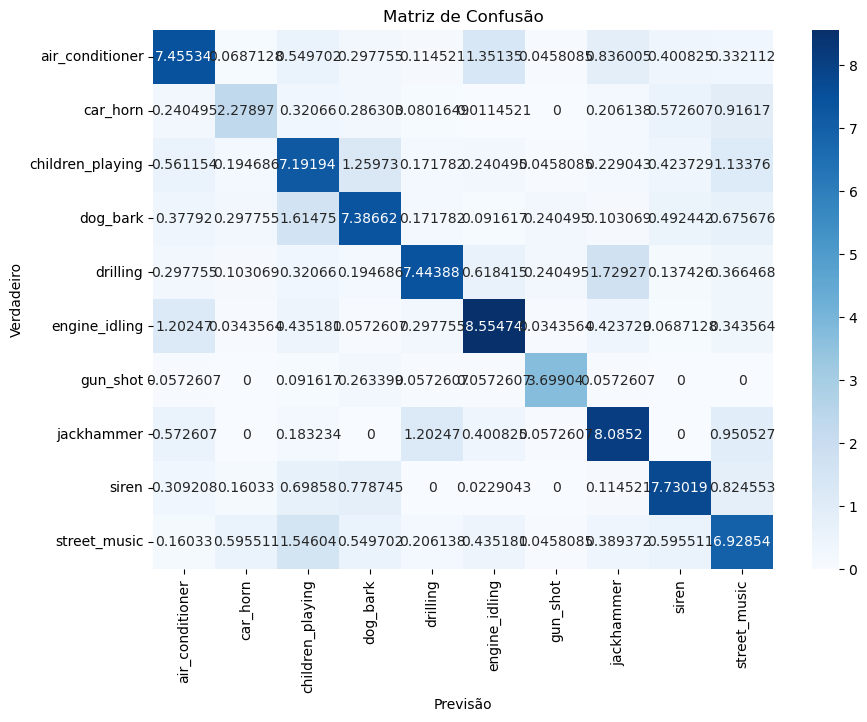

In [18]:
print(best_model.summary())
print("Learning rate: ", best_model_lr)
print("Number of epochs: ", best_model_epochs)
print("Batch Size: ", best_model_batch_size)
print("Accuracy: ", best_model_accuracy)
print("Loss: ", best_model_loss)
print("Standadr Deviation: ", best_model_std)

cm = pd.DataFrame(best_model_cfm, index=label_encoder.classes_, columns=label_encoder.classes_)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

plt.title('Matriz de Confusão')
plt.xlabel('Previsão')
plt.ylabel('Verdadeiro')
plt.show()

## Referências

https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c  
https://medium.com/thedeephub/learning-rate-and-its-strategies-in-neural-network-training-270a91ea0e5c  
https://www.kaggle.com/code/androbomb/simple-nn-with-python-multi-layer-perceptron  
https://medium.com/ensina-ai/rede-neural-perceptron-multicamadas-f9de8471f1a9  
https://iaexpert.academy/2020/05/04/quantas-camadas-escondidas-e-quantos-neuronios-incluir-numa-rede-neural-artificial/
https://towardsdatascience.com/how-to-choose-the-right-activation-function-for-neural-networks-3941ff0e6f9c  
https://github.com/enochkan/building-from-scratch/blob/main/optimizers/adam-optimizer-from-scratch.ipynb  
https://www.geeksforgeeks.org/ml-mini-batch-gradient-descent-with-python/  
https://towardsdatascience.com/cnns-for-audio-classification-6244954665ab  
https://stackoverflow.com/questions/60390707/how-to-choose-the-number-of-convolution-layers-and-filters-in-cnn  
https://machinelearningmastery.com/improve-deep-learning-performance/